 
## Heart Failure Prediction Dataset


## Task 01 
Choose 3 datasets from UCI, Kaggle, etc. You will make them imbalanced, so make sure they are not imbalanced from the beginning. Small imbalances (e.g., 55% of one class) are fine. Load, inspect, and clean the datasets. For each of them, create three versions/surrogates (in addition to the original one) by subsampling one of the classes:

    Low imbalance (65%)
    Medium imbalance (75%)
    High imbalance (90%)

### Import Libraries

In [297]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebras
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


from scipy.stats import pearsonr
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, LeaveOneOut, cross_val_score, permutation_test_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve,  precision_score, confusion_matrix, silhouette_samples, silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from collections import Counter

from sklearn.metrics import roc_curve, auc, precision_recall_curve,  average_precision_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib.gridspec import GridSpec
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [298]:
def pie_charts(data, feature, target):
    colors = sns.color_palette('pastel')[0:5]
    fig,axes = plt.subplots(1,2,figsize=(12,8))
    labels = df[feature].unique()
    textprops = {"fontsize":15}

    axes[0].pie(df[df[target]=="No"][feature].value_counts(),colors=colors, labels=labels,autopct='%1.1f%%',textprops =textprops)
    axes[0].set_title('No {}'.format(target),fontsize=15)
    axes[1].pie(df[df[target]=="Yes"][feature].value_counts(),colors=colors, labels=labels,autopct='%1.1f%%',textprops =textprops)
    axes[1].set_title('Yes {}'.format(target),fontsize=15)

    plt.legend(title = feature, fontsize=15, title_fontsize=15)
    plt.show()

### Loading Data and Preprocessing The Data

In [299]:
#Reading data
df = pd.read_csv("heart_disease.csv")
df
grouped = df.groupby(df.HeartDisease)
dff_class_0 = grouped.get_group(0)
dff_class_1 = grouped.get_group(1)
# dff_class_1
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [300]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Data Content 
***
* **Age**: age of the patient [years]
* **Sex**: sex of the patient [M: Male, F: Female]
* **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* **RestingBP**: resting blood pressure [mm Hg]
* **Cholesterol**: serum cholesterol [mm/dl]
* **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* **RestingECG**: resting electrocardiogram results 
    * Normal: Normal,
    * ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 
    * LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria
* **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
* **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
* **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
* **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* **HeartDisease**: output class [1: heart disease, 0: Normal]


### Analzying Data

In [301]:
#Basic Stats about data
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [302]:
#Information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Missing Value Analysis

In [303]:
#Missing Value
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Unique Value Analysis

In [304]:
for i in list(df.columns):
    print("{} -- {}". format(i, df[i].value_counts().shape[0]))

Age -- 50
Sex -- 2
ChestPainType -- 4
RestingBP -- 67
Cholesterol -- 222
FastingBS -- 2
RestingECG -- 3
MaxHR -- 119
ExerciseAngina -- 2
Oldpeak -- 53
ST_Slope -- 3
HeartDisease -- 2


### Categorical Feature Analysis

In [305]:
df['HeartDisease'] = df['HeartDisease'].astype('category')
df['FastingBS'] = df['FastingBS'].astype('category')
df['HeartDisease'] = df['HeartDisease'].cat.rename_categories({1: 'Yes', 0: 'No'})

In [306]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina',
       'ST_Slope', 'HeartDisease'],
      dtype='object')

### Numeric Feature Analysis

In [307]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = df.select_dtypes(include=numerics).columns
numerical_columns

Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], dtype='object')

## 4 - Descriptive Statistics

In [308]:
df.describe().T.style.background_gradient(cmap = "Blues")

,count,mean,std,min,25%,50%,75%,max
Age,918.000000,53.510893,9.432617,28.000000,47.000000,54.000000,60.000000,77.000000
RestingBP,918.000000,132.396514,18.514154,0.000000,120.000000,130.000000,140.000000,200.000000
Cholesterol,918.000000,198.799564,109.384145,0.000000,173.250000,223.000000,267.000000,603.000000
MaxHR,918.000000,136.809368,25.460334,60.000000,120.000000,138.000000,156.000000,202.000000
Oldpeak,918.000000,0.887364,1.066570,-2.600000,0.000000,0.600000,1.500000,6.200000


In [309]:
df.describe(include = ['object', 'category']).T

,count,unique,top,freq
Sex,918,2,M,725
ChestPainType,918,4,ASY,496
FastingBS,918,2,0,704
RestingECG,918,3,Normal,552
ExerciseAngina,918,2,N,547
ST_Slope,918,3,Flat,460
HeartDisease,918,2,Yes,508


## 5 - Exploratory Analysis

### 5-1 Categorical Features :
#### 5-1-1 Binary Features

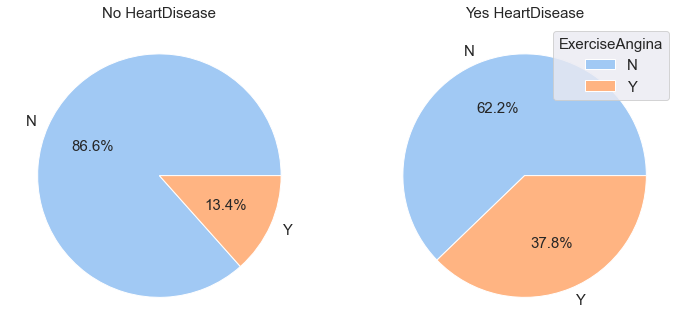

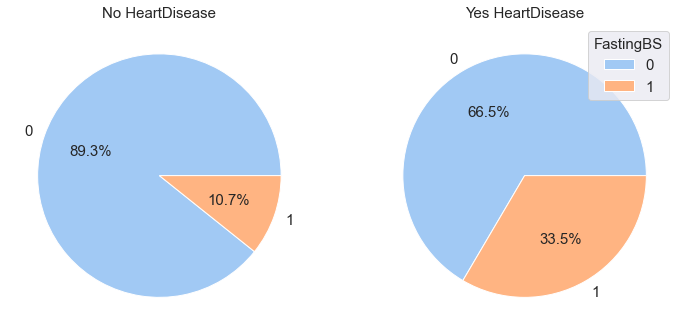

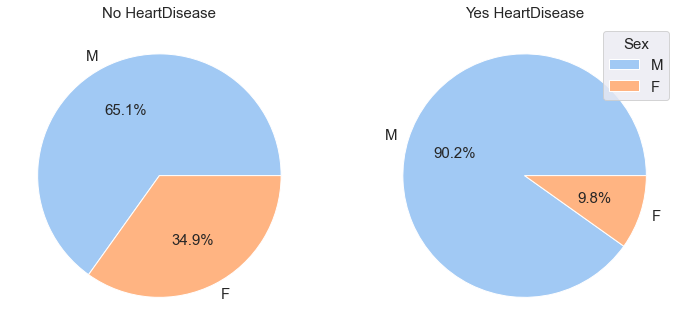

In [310]:
binary_feature = ["ExerciseAngina", "FastingBS", "Sex"]
for feature in binary_feature:
    pie_charts(df,feature,"HeartDisease")

In [311]:
def probability_calculation(feature, feature_values) : 
    
    first_with_heart_disease = len(df[(df['HeartDisease']=='Yes') & (df[feature]==feature_values[0])])
    num_first_value = len(df[df[feature]==feature_values[0]])

    second_with_heart_disease = len(df[(df['HeartDisease']=='Yes') & (df[feature]==feature_values[1])])
    num_second_value = len(df[df[feature]==feature_values[1]])

    print("\n" + feature + " : \n")
    print('Probability of {} : {} to have Heart disease:'.format(feature,feature_values[0]), first_with_heart_disease/num_first_value)
    print('Probability of {} : {} to have Heart disease:'.format(feature,feature_values[1]), second_with_heart_disease/num_second_value)

In [312]:
probability_calculation('Sex', ['M', 'F'])


Sex : 

Probability of Sex : M to have Heart disease: 0.6317241379310344
Probability of Sex : F to have Heart disease: 0.25906735751295334


***

### Interpretation :
Patient's Sex :
 - Male has three times more probabilty of heart diseases Females
***

In [313]:
probability_calculation('ExerciseAngina', ['Y', 'N'])


ExerciseAngina : 

Probability of ExerciseAngina : Y to have Heart disease: 0.8517520215633423
Probability of ExerciseAngina : N to have Heart disease: 0.3510054844606947


***

###  Interpretation :
Angina pectoris caused by exercise :
- 37% of heart Disease Patients have Angina pectoris.(significance Feature)
***

In [315]:
probability_calculation("FastingBS", [1,0])


FastingBS : 

Probability of FastingBS : 1 to have Heart disease: 0.794392523364486
Probability of FastingBS : 0 to have Heart disease: 0.48011363636363635



###  Interpretation :
Fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise] :
- 33.5% of The Patients suffering from heart Disease who have  Fasting blood sugar greater than 120mg. 



### 5-1-2 Multiclass Features

In [318]:
def distribution_categorical_features(data, feature, target, colors) :
    sns.set(rc={'figure.figsize':(14,8.27)},font_scale=1.2)
    grouped_columns = sns.countplot(x=feature, hue=target, data=data,palette=colors)
    grouped_columns.set_title('Countplot for {} {}'.format(target, feature))

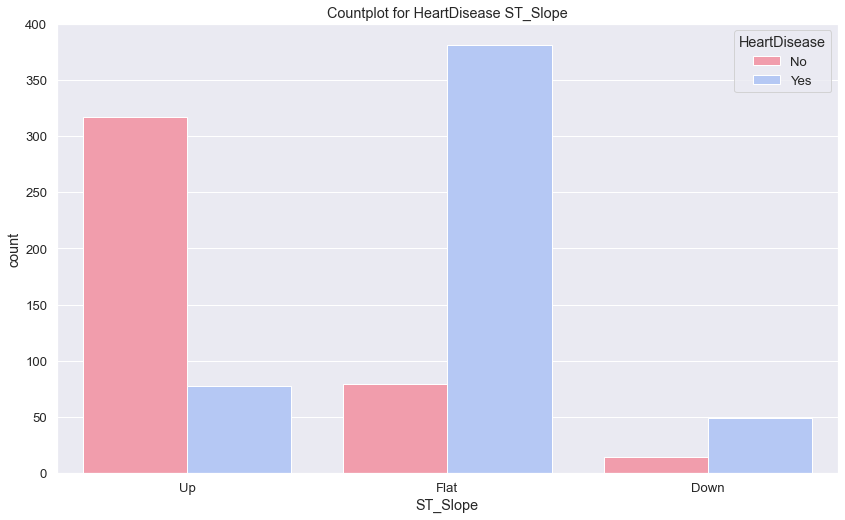

In [319]:
distribution_categorical_features(df, "ST_Slope", "HeartDisease", ["#ff8fa3","#abc4ff"])

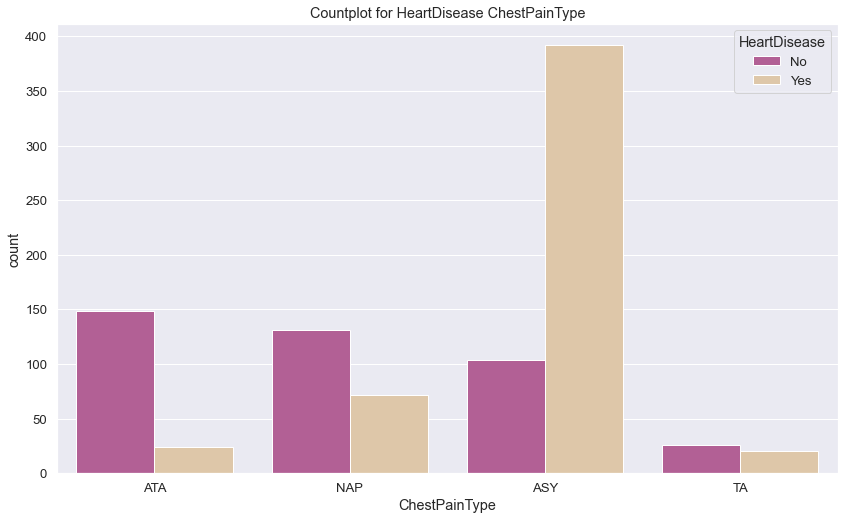

In [320]:
distribution_categorical_features(df, "ChestPainType", "HeartDisease", ["#c05299","#e7c8a0"])

###  Interpretation

- Most of the Patients Heart Disease has Chest Pain Asymptomatic (ASY) type also.
- Most of the Patients with Atypical Angina (ATA) has no Heart Disease.


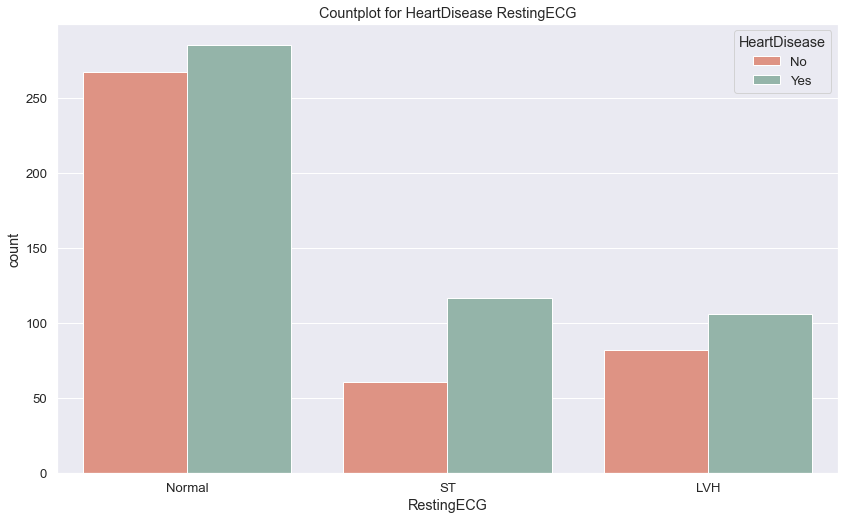

In [322]:
distribution_categorical_features(df, "RestingECG", "HeartDisease", ["#ED8975","#8FB9AA"])


### Interpretation :

- More than 500 patients have a normal resting ECG



[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

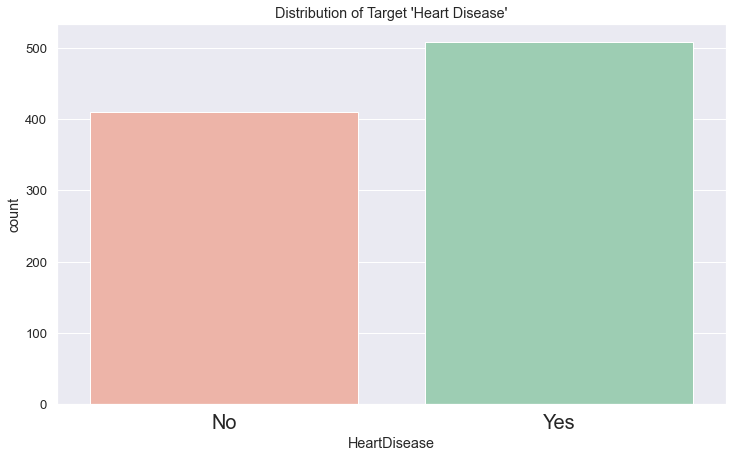

In [324]:
plt.figure(figsize=(12, 7))
heartDisease_countplot = sns.countplot(x=df.HeartDisease,palette=["#f8ad9d","#95d5b2"])
heartDisease_countplot.set_title("Distribution of Target 'Heart Disease'")
heartDisease_countplot.set_xticklabels(['No', 'Yes'], fontsize=20)


###  Interpretation : 

- Target Data is balanced



## 5-2 Numerical Features :

In [325]:
def kde_numerical_features(column, target) : 
    fig, ax = plt.subplots(figsize = (13,5))
    sns.kdeplot(df[df[target]=='Yes'][column], alpha=0.5,shade = True, color="red", label="HeartDisease", ax = ax)
    sns.kdeplot(df[df[target]=='No'][column], alpha=0.5,shade = True, color="#fccc79", label="NoHeartDisease ", ax = ax)
    plt.title('KDE-Plot of {}'.format(column), fontsize = 18)
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")
    ax.legend();
    plt.show()

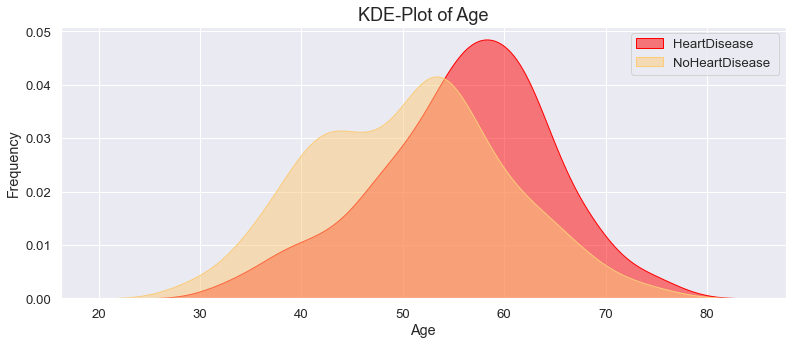

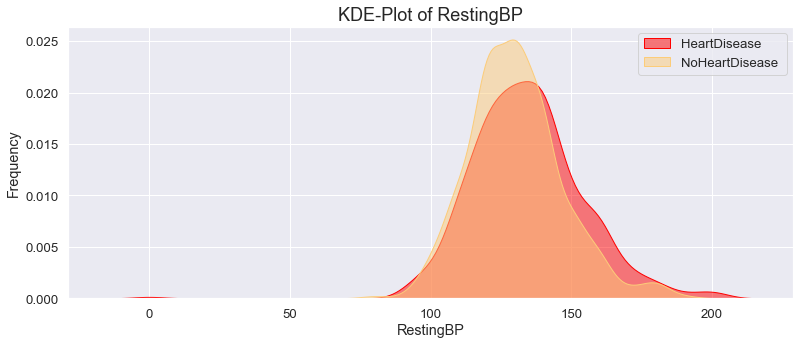

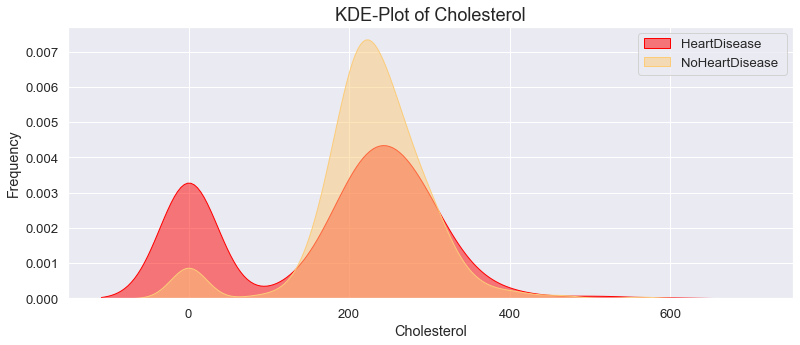

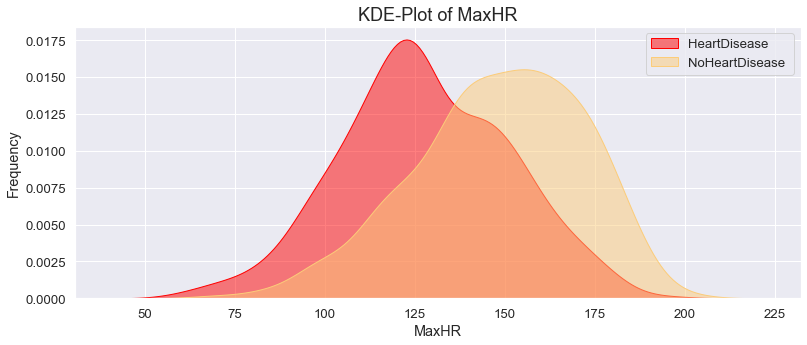

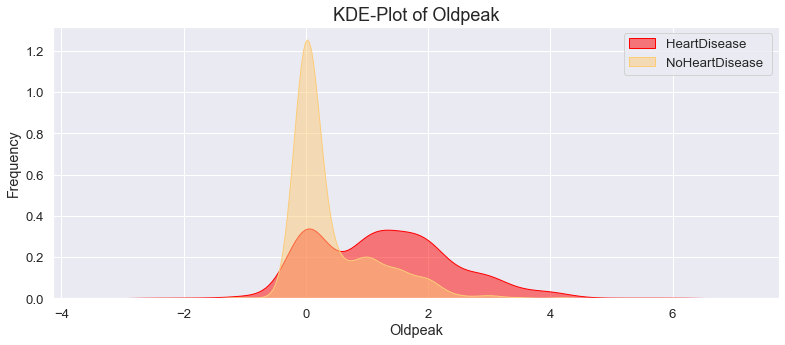

In [326]:
for column in numerical_columns : 
    kde_numerical_features(column, 'HeartDisease')

## Summary KDE-plot and Descriptive Statistics of Numerical features : 

<div class="alert alert-block alert-success">  
<dl>
<dt style="color: black" >📍 Age : </dt>
    <dd>- Average Age is 53.</dd>
    <dd>- Maximum Age is 77</dd>
    <dd>- Minimum Age is 28</dd>
    <dd>- Most of heart disease Patients have age between 55 and 65</dd>
</dl>
</div>

<div class="alert alert-block alert-info">  
<dl>
<dt style="color: black">📍 OldPeak : </dt>
    <dd>- Old peak = ST depression induced by exercise relative to rest</dd>
    <dd>- Average OldPeak is 0.88</dd>
    <dd>- Maximum OldPeak is 6.2</dd> 
    <dd>- Minimum OldPeak is -2.6</dd> 
    <dd>- Most patients with 0 oldpeak, don't have Heart disease</dd>
</dl>
</div>
<div class="alert alert-block alert-danger">  
<dl>
<dt style="color: black">📍 Cholesterol : </dt>
    <dd>- For person aged 20 years and older, the Cholesterol level should be between 125 and 200 mg/dL. <a href='https://www.verywellhealth.com/cholesterol-levels-by-age-chart-5190176'>Source</a></dd>
    <dd>- Average Cholesterol is 198.7 mg/dl</dd>
    <dd>- Maximum is 603 >>> 200 mg/dl</dd> 
    <dd>- Minimum Cholesterol is 0 => Cholesterol should be != 0</dd> 
    <dd>- Most patients with 0 oldpeak, don't have Heart disease</dd>
</dl>
</div>
<div class="alert alert-block alert-warning">  
<dl>
<dt style="color: black">📍 MaxHR : </dt>
    <dd>- There are a number of formulas out there for calculating max heart rate. The easiest and most commonly used one is to simply subtract your age from 220. So if you're 40 years old, your max heart rate would be 180 bpm. <a href='https://www.whoop.com/thelocker/calculating-max-heart-rate/'>Source</a></dd>
    <dd> - Average MaxHR is 136. Age average is 53 so based of this formula the MaxHR average will be around 167</dd>
    <dd> - Maximum is 202 >>> 200 mg/dl</dd> 
    <dd> - Minimum MaxHR is 60 => So 220 - 60 = Age = 160 years old ! hmm 🤔 </dd> 
    <dd> - Based on the formula is not logic (the oldest man in the world is 119 years old 😁 ) </dd>
    <dd> - MaxHR : Calculate your resting heart rate by counting how many times your heart beats per minute when you are at rest, such as first thing in the morning. It's usually somewhere between 60 and 100 beats per minute for the average adult.<a href="https://www.mayoclinic.org/healthy-lifestyle/fitness/in-depth/exercise-intensity/art-20046887">Source</a><br>- So 60 can be a result of calculation with another formula</dd>
    <dd>- Most of tested patients with heart disease have around 120 maxHR </dd>
</dl> 
</div>
<div class="alert alert-block alert-success">  
<dl>
<dt style="color: black" >📍 RestingBP : </dt>
    <dd>- A normal blood pressure level is less than 120/80 mmHg..</dd>
    <dd>- Minimum is 0 => Must be an outlier data</dd>
    <dd>- Maximum Age is 200</dd>
    <dd>- Most tested Patients have RestingBP between 120 and 150</dd>
</dl>
</div>

In [192]:
colors = ['lightcoral','deepskyblue',
          'orchid',    'tomato',
          'teal',      'darkcyan',
          'limegreen', 'darkorange']

def distribution_plot(column, title):

    fig = plt.figure(figsize=(17, 7))
    grid = GridSpec(nrows=2, ncols=1, figure=fig)
    color = np.random.choice(colors, 1)[0]

    ax0 = fig.add_subplot(grid[0, :])
    ax0.set_title(f'Histogram and BoxPlot of {title}')
    sns.histplot(column, ax=ax0, color=color)

    ax1 = fig.add_subplot(grid[1, :])
    plt.axis('off')
    sns.boxplot(x=column, ax=ax1, color=color)
    

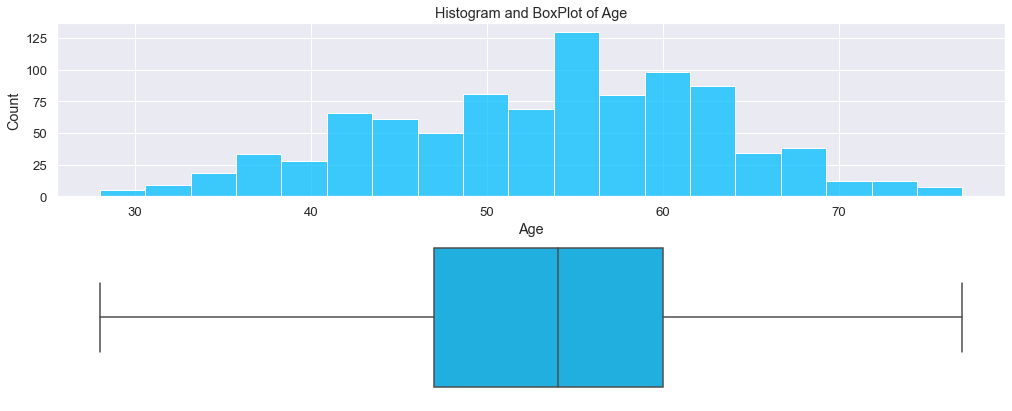

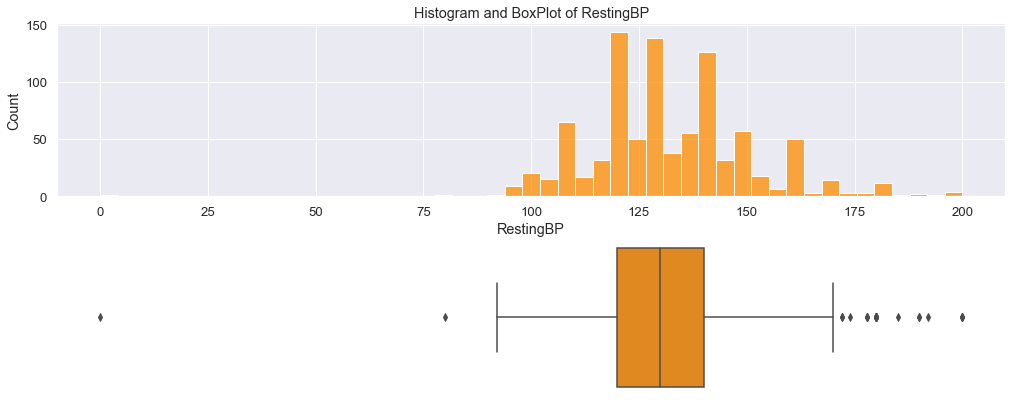

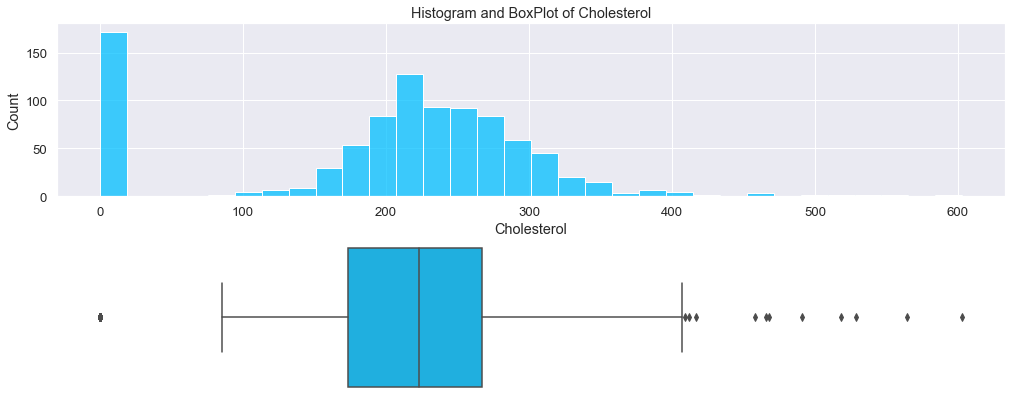

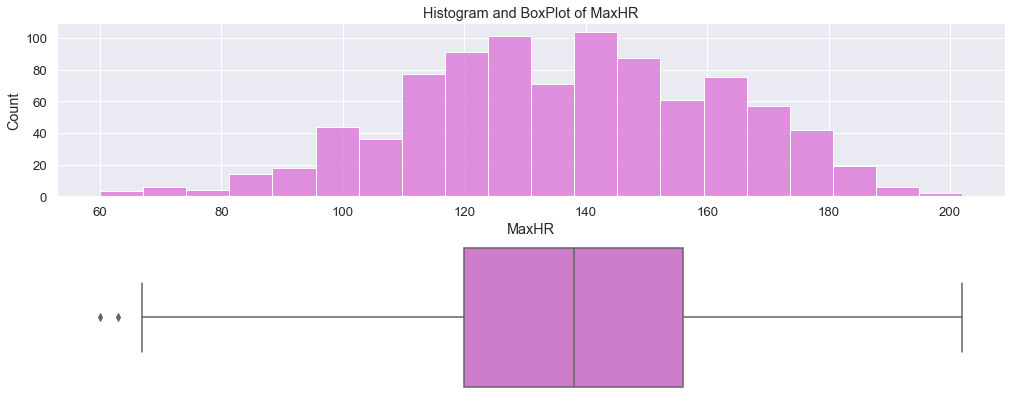

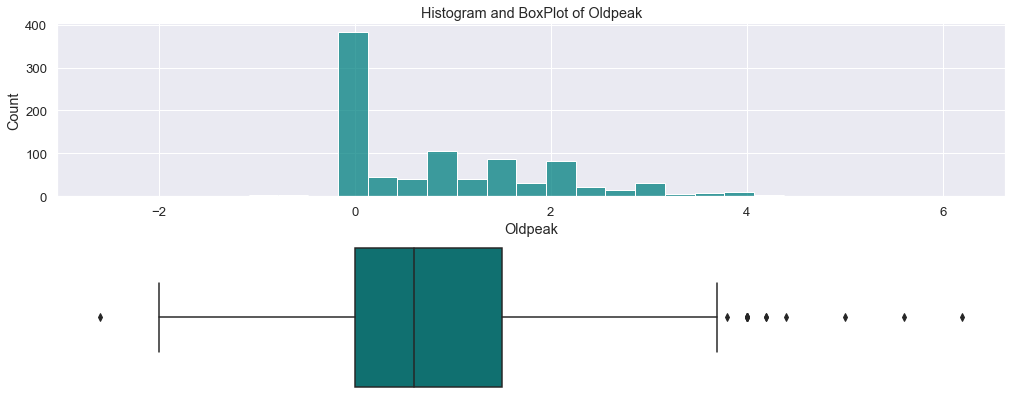

In [193]:
for col in numerical_columns:
    distribution_plot(df[col], col)

<h1 id="section6" style="color: #1d3557;">6 - Feature Engineering </h1>

### 6-1 Deleting Outliers  


In [194]:
def make_pretty(styler):
    styler.set_caption("Skewness")
    return styler.background_gradient(axis=None, cmap="YlGnBu")

df[numerical_columns].skew().to_frame().rename(columns={0: 'Skewness'}).sort_values(by=['Skewness'], ascending=False).style.pipe(make_pretty)

,Skewness
Oldpeak,1.022872
RestingBP,0.179839
MaxHR,-0.144359
Age,-0.195933
Cholesterol,-0.610086


In [195]:
df1 = df[df.Cholesterol != 0]
df1 = df1[df1.RestingBP > 70]

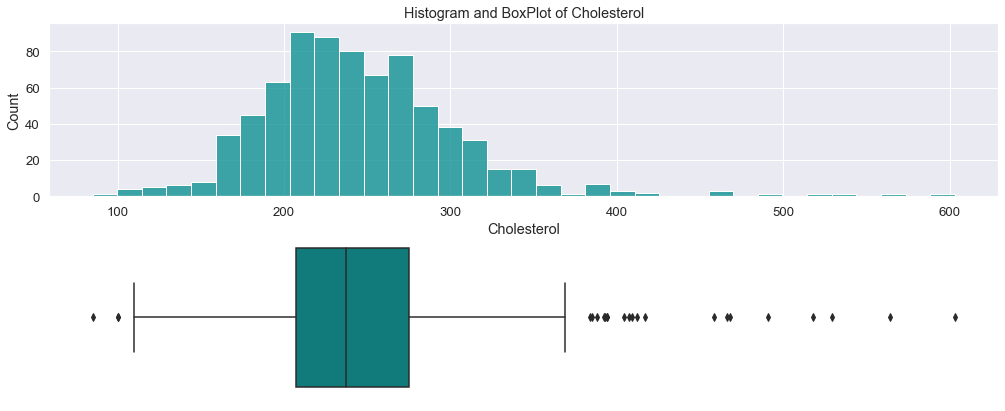

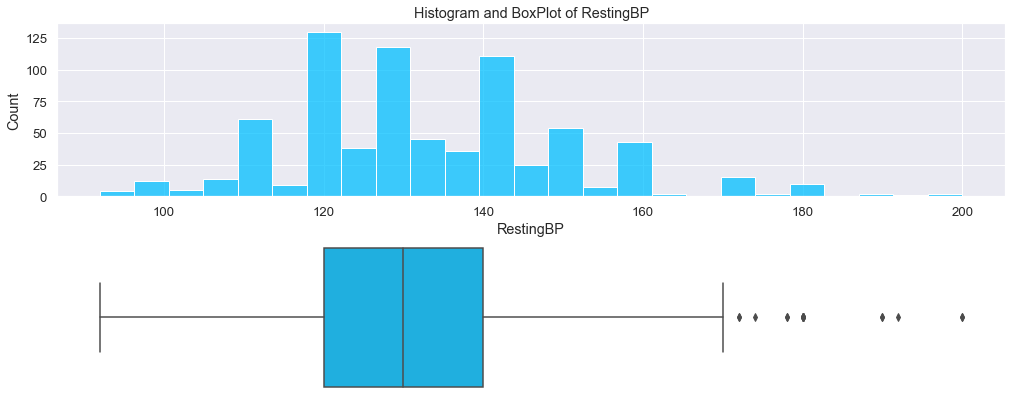

In [196]:
for col in ["Cholesterol", "RestingBP"]:
    distribution_plot(df1[col], col)

In [197]:
final_df = pd.get_dummies(df1, columns=categorical_columns[:-1])
final_df

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,172,0.0,No,0,1,0,1,...,1,0,0,1,0,1,0,0,0,1
1,49,160,180,156,1.0,Yes,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,98,0.0,No,0,1,0,1,...,1,0,0,0,1,1,0,0,0,1
3,48,138,214,108,1.5,Yes,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
4,54,150,195,122,0.0,No,0,1,0,0,...,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,132,1.2,Yes,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
914,68,144,193,141,3.4,Yes,0,1,1,0,...,0,1,0,1,0,1,0,0,1,0
915,57,130,131,115,1.2,Yes,0,1,1,0,...,1,0,0,1,0,0,1,0,1,0
916,57,130,236,174,0.0,Yes,1,0,0,1,...,1,0,1,0,0,1,0,0,1,0


In [198]:
final_df['HeartDisease'] = final_df['HeartDisease'].map({'Yes': 1, 'No': 0})

In [199]:
final_df

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,172,0.0,0,0,1,0,1,...,1,0,0,1,0,1,0,0,0,1
1,49,160,180,156,1.0,1,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,98,0.0,0,0,1,0,1,...,1,0,0,0,1,1,0,0,0,1
3,48,138,214,108,1.5,1,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
4,54,150,195,122,0.0,0,0,1,0,0,...,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,132,1.2,1,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
914,68,144,193,141,3.4,1,0,1,1,0,...,0,1,0,1,0,1,0,0,1,0
915,57,130,131,115,1.2,1,0,1,1,0,...,1,0,0,1,0,0,1,0,1,0
916,57,130,236,174,0.0,1,1,0,0,1,...,1,0,1,0,0,1,0,0,1,0


In [200]:
col_names = df.columns.tolist()
print ("Column names:")
print (col_names)

Column names:
['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


In [201]:
notPatient = final_df.loc[final_df['HeartDisease'] == 0]
patient    = final_df.loc[final_df['HeartDisease'] == 1]

In [202]:
final_df.shape, notPatient.shape, patient.shape 

((746, 22), (390, 22), (356, 22))

In [203]:
print(notPatient.shape[0]*100/final_df.shape[0])

52.27882037533512


In [204]:
print(patient.shape[0]*100/final_df.shape[0])

47.72117962466488


###  Data Imbalancing <a class="anchor" id="1.15"></a>
[Task 01](#1)

In [205]:
df1 = final_df.copy()
df2 = final_df.copy()
# splitting dataframe by groups
# grouping by particular dataframe column
 
grouped = df2.groupby(final_df.HeartDisease)
df_class_0 = grouped.get_group(0)
df_class_1 = grouped.get_group(1)
df_class_1

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
1,49,160,180,156,1.0,1,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0
3,48,138,214,108,1.5,1,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
8,37,140,207,130,1.5,1,0,1,1,0,...,1,0,0,1,0,0,1,0,1,0
11,58,136,164,99,2.0,1,0,1,0,1,...,1,0,0,0,1,0,1,0,1,0
13,49,140,234,140,1.0,1,0,1,1,0,...,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,57,140,241,123,0.2,1,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
913,45,110,264,132,1.2,1,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
914,68,144,193,141,3.4,1,0,1,1,0,...,0,1,0,1,0,1,0,0,1,0
915,57,130,131,115,1.2,1,0,1,1,0,...,1,0,0,1,0,0,1,0,1,0


In [206]:
df_class_0.shape, df_class_1.shape

((390, 22), (356, 22))

#### Low Imbalance dataset (65% and 35%) <a class="anchor" id="1.15.1"></a>
[Task 01](#1)

[Data Imbalancing](#1.15)

In [207]:
df_resample_class1 = resample(df_class_0, replace=True, n_samples=189)  # 35 % 189*65/35=351
df_resample_class2 = resample(df_class_1, replace=True, n_samples=351) # 65 %
df_low_imbalance = pd.concat([df_resample_class1, df_resample_class2])

df_class_0.shape, df_class_1.shape, df_resample_class1.shape, df_resample_class2.shape, df_low_imbalance.shape

((390, 22), (356, 22), (189, 22), (351, 22), (540, 22))

#### Medium Imbalance dataset (75% and 25%) <a class="anchor" id="1.15.2"></a>
[Task 01](#1)

[Data Imbalancing](#1.15)

In [208]:
df_resample_class1 = resample(df_class_0, replace=True, n_samples=118)  # 25 % 118*75/25=354
df_resample_class2 = resample(df_class_1, replace=True, n_samples=354) # 75 %
df_medium_imbalance = pd.concat([df_resample_class1, df_resample_class2])

df_class_0.shape, df_class_1.shape, df_resample_class1.shape, df_resample_class2.shape, df_medium_imbalance.shape

((390, 22), (356, 22), (118, 22), (354, 22), (472, 22))

#### High Imbalance dataset (90% and 10%) <a class="anchor" id="1.15.3"></a>
[Task 01](#1)

[Data Imbalancing](#1.15)

In [209]:
df_resample_class1 = resample(df_class_0, replace=True, n_samples=39)  # 10 % 39*90/10=351
df_resample_class2 = resample(df_class_1, replace=True, n_samples=351) # 90 %
df_high_imbalance = pd.concat([df_resample_class1, df_resample_class2])
df_class_0.shape, df_class_1.shape, df_resample_class1.shape, df_resample_class2.shape, df_high_imbalance.shape
df_high_imbalance

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
626,53,142,226,111,0.0,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,1
58,54,150,365,134,1.0,0,0,1,1,0,...,1,0,0,0,1,1,0,0,0,1
849,62,130,231,146,1.8,0,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
67,32,110,225,184,0.0,0,0,1,0,1,...,1,0,0,1,0,1,0,0,0,1
92,52,120,210,148,0.0,0,1,0,0,1,...,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,57,140,241,123,0.2,1,1,0,1,0,...,1,0,0,1,0,0,1,0,1,0
220,46,130,222,112,0.0,1,0,1,1,0,...,1,0,0,1,0,1,0,0,1,0
841,62,130,263,97,1.2,1,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0
888,52,128,204,156,1.0,1,0,1,1,0,...,0,1,0,1,0,0,1,0,1,0


In [210]:
# df_new.to_csv("heart_new.csv", index=False)

## Task 02<a class="anchor" id="2"></a>
[Table of Contents](#0)

To establish a baseline, perform stratified cross-validation on each of the datasets and their surrogates and train a random forest. Report baseline results using appropriate metrics.

### Declare feature vector and target variable, Normalization and Train - Test Split   <a class="anchor" id="2.2"></a>
[Task 02](#2)

In [211]:
# get datasets
def get_dataset_low():    
    X = df_low_imbalance.drop(["HeartDisease"], axis = 1)
    y= df_low_imbalance[["HeartDisease"]]  
    x_max = np.max(X)
    x_min = np.min(X)
    X = (X - x_min) / (x_max - x_min)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify=y,random_state = 3, shuffle=True)
    return X_train, X_test, y_train, y_test

def get_dataset_medium():    
    X = df_medium_imbalance.drop(["HeartDisease"], axis = 1)
    y= df_medium_imbalance[["HeartDisease"]]  
    x_max = np.max(X)
    x_min = np.min(X)
    X = (X - x_min) / (x_max - x_min)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 3, shuffle=True)
    return X_train, X_test, y_train, y_test

def get_dataset_high():    
    X = df_high_imbalance.drop(["HeartDisease"], axis = 1)
    y= df_high_imbalance[["HeartDisease"]]  
    x_max = np.max(X)
    x_min = np.min(X)
    X = (X - x_min) / (x_max - x_min) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 3, shuffle=True)
    return X_train, X_test, y_train, y_test


### Random Forest Classifier <a class="anchor" id="2.3"></a>
[Task 02](#2)

In [212]:

model_parameters = {"Random Forest": {"model": RandomForestClassifier(), 
                                      "params": {"n_estimators": [10, 50, 100], 
                                                 "max_features": ["auto", "sqrt", "log2"], 
                                                 "max_depth": list(range(1, 15, 3))}}
#                     ,
#                    "Decision Tree": {"model": DecisionTreeClassifier(), 
#                                      "params": {"criterion": ["gini", "entropy"], 
#                                                 "max_features": ["auto", "sqrt", "log2"], 
#                                                 "max_depth": list(range(1, 30, 3))}}
                   }

In [213]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 4)
scores = []
X_train_low, X_test_low, y_train_low, y_test_low = get_dataset_low()
for model_name, parameters in model_parameters.items():
    rf_low = RandomizedSearchCV(parameters["model"], parameters["params"], cv = cv, n_iter = 10)
    rf_low.fit(X_train_low, y_train_low)
    y_pred_prob_low = rf_low.predict_proba(X_test_low) 
    y_pred_low = np.argmax(y_pred_prob_low, axis = 1)    
    scores.append([model_name, dict(rf_low.best_params_), rf_low.best_score_, accuracy_score(y_pred_low, y_test_low)])
print("Low Imbalance Dataset")
print(scores)


Low Imbalance Dataset
[['Random Forest', {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 10}, 0.9321003401360546, 0.9259259259259259]]


In [214]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 4)
scores = []
X_train_medium, X_test_medium, y_train_medium, y_test_medium = get_dataset_medium()
for model_name, parameters in model_parameters.items():
    rf_medium = RandomizedSearchCV(parameters["model"], parameters["params"], cv = cv, n_iter = 10)
    rf_medium.fit(X_train_medium, y_train_medium)
    y_pred_prob_medium = rf_medium.predict_proba(X_test_medium) 
    y_pred_medium = np.argmax(y_pred_prob_medium, axis = 1)    
    scores.append([model_name, dict(rf_medium.best_params_), rf_medium.best_score_, accuracy_score(y_pred_medium, y_test_medium)])
print("Medium Imbalance Dataset")
print(scores)

Medium Imbalance Dataset
[['Random Forest', {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 13}, 0.9228959025470654, 0.9583333333333334]]


In [215]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 4)
scores = []
X_train_high, X_test_high, y_train_high, y_test_high = get_dataset_high()
for model_name, parameters in model_parameters.items():
    rf_high = RandomizedSearchCV(parameters["model"], parameters["params"], cv = cv, n_iter = 10)
    rf_high.fit(X_train_high, y_train_high)
    y_pred_prob_high = rf_high.predict_proba(X_test_high) 
    y_pred_high = np.argmax(y_pred_prob_high, axis = 1)    
    scores.append([model_name, dict(rf_high.best_params_), rf_high.best_score_, accuracy_score(y_pred_high, y_test_high)])
print("High Imbalance Dataset")
print(scores)

High Imbalance Dataset
[['Random Forest', {'n_estimators': 10, 'max_features': 'sqrt', 'max_depth': 13}, 0.945138888888889, 0.9230769230769231]]


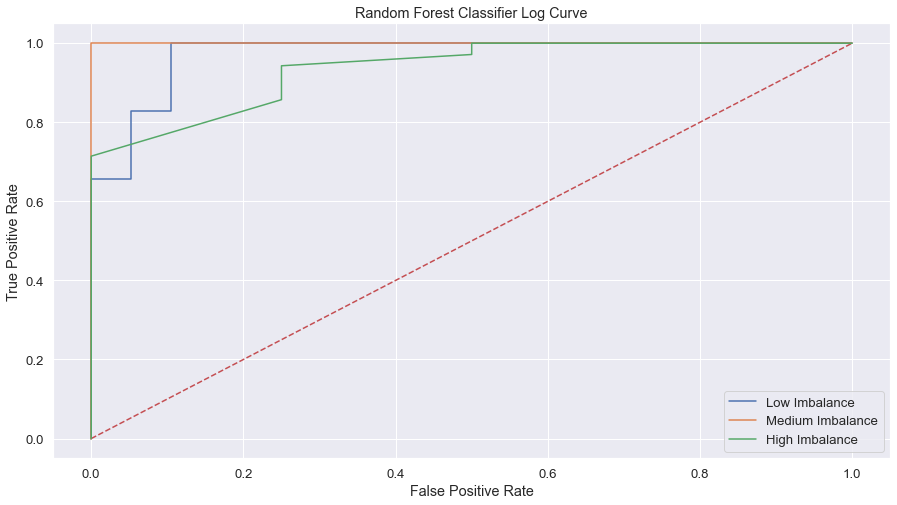

In [217]:
#ROC Curve
fpr_low, tpr_low, thresholds_low = roc_curve(y_test_low, y_pred_prob_low[:, 1])
fpr_medium, tpr_medium, thresholds_medium = roc_curve(y_test_medium, y_pred_prob_medium[:, 1])
fpr_high, tpr_high, thresholds_high = roc_curve(y_test_high, y_pred_prob_high[:, 1])

#Plot Curve
plt.figure(figsize = (15, 8))
plt.plot([0,1], [0,1], "r--")
plt.plot(fpr_low, tpr_low, label = "Low Imbalance")
plt.plot(fpr_medium, tpr_medium, label = "Medium Imbalance")
plt.plot(fpr_high, tpr_high, label = "High Imbalance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest Classifier Log Curve")
plt.legend()

# plt.savefig('heart_disease_ROC_Curve_low_medium_high.pdf')

plt.show()

### precision_recall_curve

Random Forest (Low Balanced Data): f1=0.946 auc=0.984
Random Forest (Medium Balanced Data): f1=0.971 auc=1.000
Random Forest (High Balanced Data): f1=0.958 auc=0.992


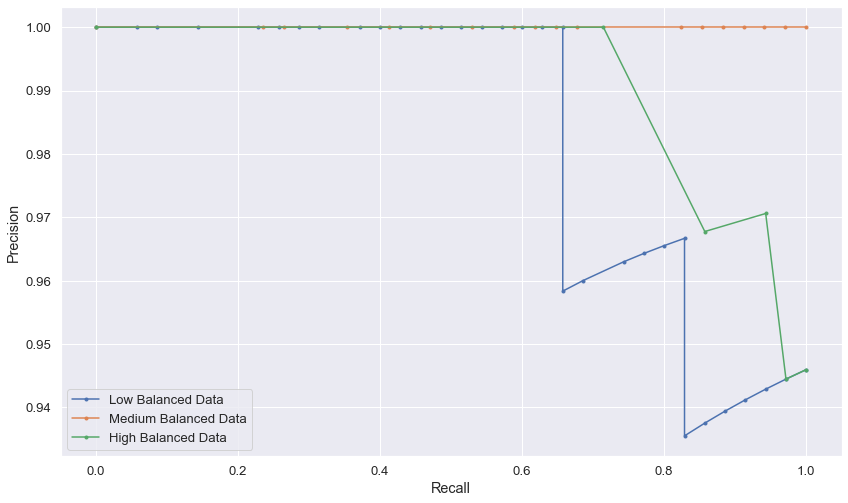

In [218]:
#PR Curve
y_predict_low = rf_low.predict(X_test_low)
y_predict_medium = rf_medium.predict(X_test_medium)
y_predict_high = rf_high.predict(X_test_high)

precision_low, recall_low, _ = precision_recall_curve(y_test_low, y_pred_prob_low[:, 1])
precision_medium, recall_medium, _ = precision_recall_curve(y_test_medium, y_pred_prob_medium[:, 1])
precision_high, recall_high, _ = precision_recall_curve(y_test_high, y_pred_prob_high[:, 1])

f1_low, auc_low = f1_score(y_test_low, y_predict_low), auc(recall_low, precision_low)
f1_medium, auc_medium = f1_score(y_test_medium, y_predict_medium), auc(recall_medium, precision_medium)
f1_high, auc_high = f1_score(y_test_high, y_predict_high), auc(recall_high, precision_high)

# summarize scores
print('Random Forest (Low Balanced Data): f1=%.3f auc=%.3f' % (f1_low, auc_low))
print('Random Forest (Medium Balanced Data): f1=%.3f auc=%.3f' % (f1_medium, auc_medium))
print('Random Forest (High Balanced Data): f1=%.3f auc=%.3f' % (f1_high, auc_high))

# plot the precision-recall curves
plt.plot(recall_low, precision_low, marker='.', label='Low Balanced Data')
plt.plot(recall_medium, precision_medium, marker='.', label='Medium Balanced Data')
plt.plot(recall_high, precision_high, marker='.', label='High Balanced Data')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.savefig('heart_disease_PR_Curve_low_medium_high.pdf')
plt.show()

### Precision Score

In [219]:
final_results_low = []
confusion_matrix_list_low = []
    
score_low = precision_score(y_test_low, y_predict_low)
cm_low = confusion_matrix(y_test_low, y_predict_low)

final_results_low.append((score_low))
confusion_matrix_list_low.append((cm_low))

final_results_low

[0.8974358974358975]

In [220]:
final_results_medium = []
confusion_matrix_list_medium = []
    
score_medium = precision_score(y_test_medium, y_predict_medium)
cm_medium = confusion_matrix(y_test_medium, y_predict_medium)

final_results_medium.append((score_medium))
confusion_matrix_list_medium.append((cm_medium))

final_results_medium

[0.9444444444444444]

In [221]:
final_results_high = []
confusion_matrix_list_high = []

score_high = precision_score(y_test_high, y_predict_high)
cm_high = confusion_matrix(y_test_high, y_predict_high)

final_results_high.append((score_high))
confusion_matrix_list_high.append((cm_high))

final_results_high

[0.9444444444444444]

### Confusion Matrix

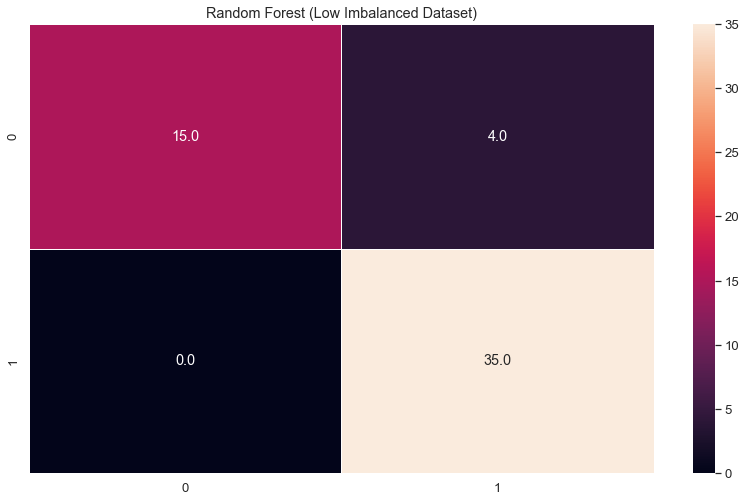

In [222]:
for i in confusion_matrix_list_low:
    plt.figure()
    sns.heatmap(i, annot = True, linewidths = 0.6, fmt = '.1f')
    plt.title("Random Forest (Low Imbalanced Dataset)")
    plt.show()
    

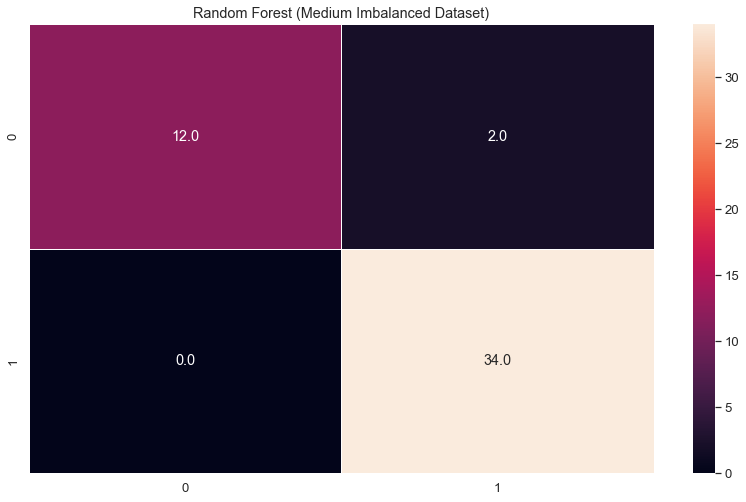

In [223]:
for i in confusion_matrix_list_medium:
    plt.figure()
    sns.heatmap(i, annot = True, linewidths = 0.6, fmt = '.1f')
    plt.title("Random Forest (Medium Imbalanced Dataset)")
    plt.show()

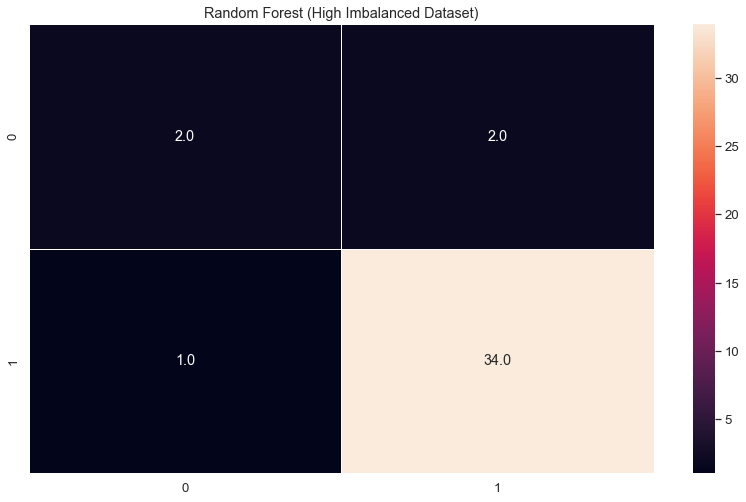

In [224]:
for i in confusion_matrix_list_high:
    plt.figure()
    sns.heatmap(i, annot = True, linewidths = 0.6, fmt = '.1f')
    plt.title("Random Forest (High Imbalanced Dataset)")
    plt.show()

In [225]:
models = {}
# Random Forest
models['Random Forest'] = RandomForestClassifier()

In [226]:
MSE, MAE, R_Squared_score, RMSE, accuracy = {}, {}, {}, {}, {}
for key in models.keys(): 
    # Fit the classifier model
    models[key].fit(X_train_low, y_train_low)    
    # Prediction 
    predictions = models[key].predict(X_test_low)   
    # Calculate mean_squared_error, mean_absolute_error, r2_score,RMSE and accuracy_score Metrics
    MSE[key] = mean_squared_error(predictions, y_test_low)
    MAE[key] = mean_absolute_error(predictions, y_test_low)
    R_Squared_score[key] = r2_score(predictions, y_test_low)
    RMSE[key] = mean_squared_error(predictions, y_test_low, squared=False)
    accuracy[key] = accuracy_score(predictions, y_test_low)

In [227]:
df_model = pd.DataFrame(index=models.keys(), columns=['MSE', 'MAE', 'R_Squared_score', 'RMSE', 'Accuracy'])

df_model['MSE'] = MSE.values()
df_model['MAE'] = MAE.values()
df_model['R_Squared_score'] = R_Squared_score.values()
df_model['RMSE'] = RMSE.values()
df_model['Accuracy'] = accuracy.values()

df_model

,MSE,MAE,R_Squared_score,RMSE,Accuracy
Random Forest,0.055556,0.055556,0.733553,0.235702,0.944444


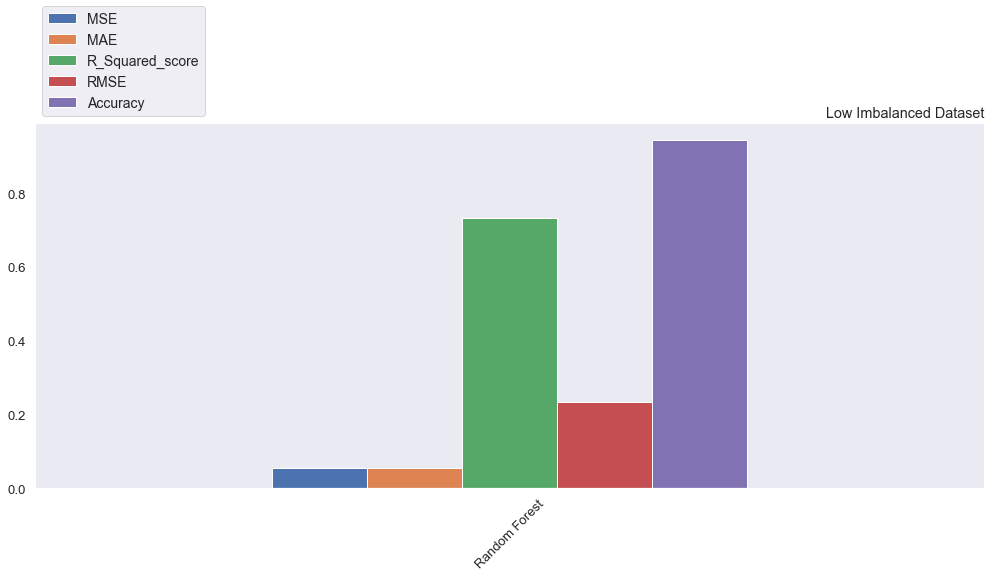

In [228]:
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 14})
plt.grid()
plt.title("Low Imbalanced Dataset", loc="right")
plt.tight_layout()
plt.savefig('heart_disease_accuracy_metrics_bar_graphs_metrics_low.pdf')
plt.savefig('heart_disease_accuracy_metrics_bar_graphs_metrics_low.png')

In [120]:
MSE, MAE, R_Squared_score, RMSE, accuracy = {}, {}, {}, {}, {}
for key in models.keys(): 
    # Fit the classifier model
    models[key].fit(X_train_medium, y_train_medium)    
    # Prediction 
    predictions = models[key].predict(X_test_medium)   
    # Calculate mean_squared_error, mean_absolute_error, r2_score,RMSE and accuracy_score Metrics
    MSE[key] = mean_squared_error(predictions, y_test_medium)
    MAE[key] = mean_absolute_error(predictions, y_test_medium)
    R_Squared_score[key] = r2_score(predictions, y_test_medium)
    RMSE[key] = mean_squared_error(predictions, y_test_medium, squared=False)
    accuracy[key] = accuracy_score(predictions, y_test_medium)

In [249]:
df_model = pd.DataFrame(index=models.keys(), columns=['MSE', 'MAE', 'R_Squared_score', 'RMSE', 'Accuracy'])

df_model['MSE'] = MSE.values()
df_model['MAE'] = MAE.values()
df_model['R_Squared_score'] = R_Squared_score.values()
df_model['RMSE'] = RMSE.values()
df_model['Accuracy'] = accuracy.values()

df_model

,MSE,MAE,R_Squared_score,RMSE,Accuracy
Random Forest,0.051282,0.051282,0.442857,0.226455,0.948718


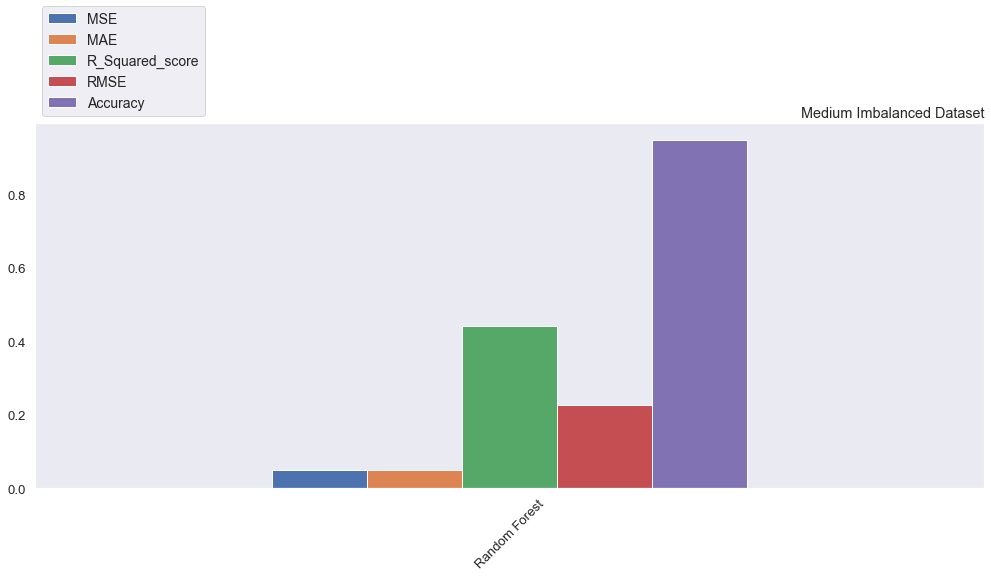

In [250]:
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 14})
plt.grid()
plt.title("Medium Imbalanced Dataset", loc="right")
plt.tight_layout()

plt.savefig('fig_2_heart_disease_accuracy_metrics_bar_graphs_metrics_medium.pdf')
plt.savefig('fig_2_heart_disease_accuracy_metrics_bar_graphs_metrics_Medium.png')

In [254]:
MSE, MAE, R_Squared_score, RMSE, accuracy = {}, {}, {}, {}, {}
for key in models.keys(): 
    # Fit the classifier model
    models[key].fit(X_train_high, y_train_high)    
    # Prediction 
    predictions = models[key].predict(X_test_high)   
    # Calculate mean_squared_error, mean_absolute_error, r2_score,RMSE and accuracy_score Metrics
    MSE[key] = mean_squared_error(predictions, y_test_high)
    MAE[key] = mean_absolute_error(predictions, y_test_high)
#     a=r2_score(predictions, y_test_high)
    R_Squared_score[key] = r2_score(predictions, y_test_high)
    RMSE[key] = mean_squared_error(predictions, y_test_high, squared=False)
    accuracy[key] = accuracy_score(predictions, y_test_high)

In [255]:
df_model = pd.DataFrame(index=models.keys(), columns=['MSE', 'MAE', 'R_Squared_score', 'RMSE', 'Accuracy'])

df_model['MSE'] = MSE.values()
df_model['MAE'] = MAE.values()

df_model['R_Squared_score'] = R_Squared_score.values()
df_model['RMSE'] = RMSE.values()
df_model['Accuracy'] = accuracy.values()

df_model

,MSE,MAE,R_Squared_score,RMSE,Accuracy
Random Forest,0.051282,0.051282,-0.054054,0.226455,0.948718


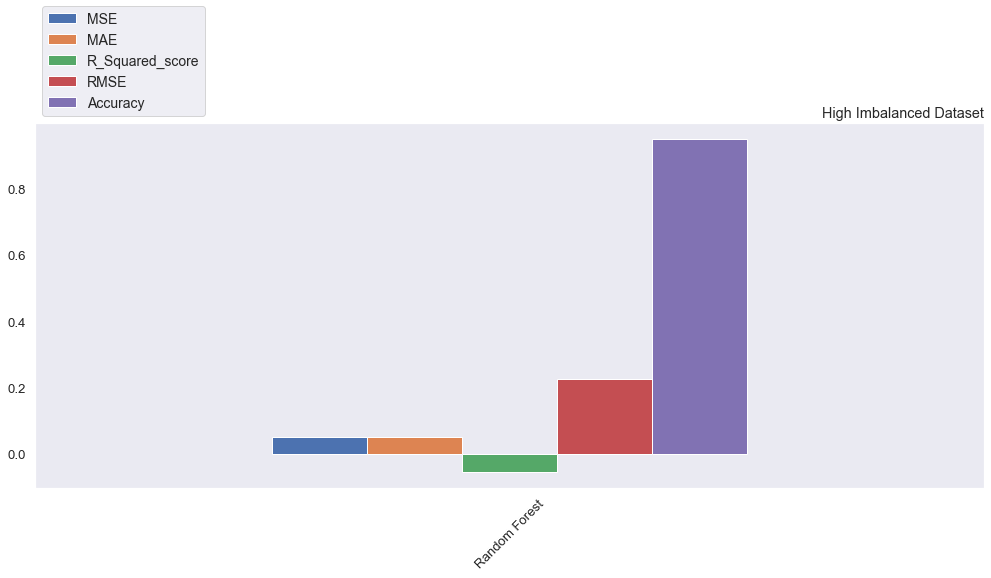

In [256]:
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 14})
plt.grid()
plt.title("High Imbalanced Dataset", loc="right")
plt.tight_layout()
plt.savefig('fig_3_heart_disease_accuracy_metrics_bar_graphs_Curve_high.pdf')
plt.savefig('fig_3_heart_disease_accuracy_metrics_bar_graphs_Curve_high.png')

##  Task 03 <a class="anchor" id="3"></a>
[Table of Contents](#0)

Create 10 stratified folds (to ensure the imbalance ratio remains the same in each fold) for each of the datasets.

### Stratified 10 Folds <a class="anchor" id="3.1"></a>
[Task 03](#3)

In [126]:
X_train, X_test, y_train, y_test = get_dataset_low()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
for train_index, test_index in cv.split(X_train, y_train):
    X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]

In [127]:
X_train, X_test, y_train, y_test = get_dataset_medium()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
for train_index, test_index in cv.split(X_train, y_train):
    X_train_medium, X_test_medium = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_medium, y_test_medium = y_train.iloc[train_index], y_train.iloc[test_index]

In [128]:
X_train, X_test, y_train, y_test = get_dataset_high()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
for train_index, test_index in cv.split(X_train, y_train):
    X_train_high, X_test_high = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_high, y_test_high = y_train.iloc[train_index], y_train.iloc[test_index]

##  Task 04 <a class="anchor" id="4"></a>
[Table of Contents](#0)

4. Using the data of 9 of these folds:
    1. Using the Elbow method and the Silhouette method, identify the number of clusters in the dataset.There should be some level of agreement between these indices (or at least you should be able to identify lower and upper bounds).

### Optimal number of clusters<a class="anchor" id="4.1"></a>
[Task 04](#4)

####  Silhouette analysis to find optimal number of clusters<a class="anchor" id="4.1.1"></a>
[Task 04](#4)

[Optimal number of clusters](#4.1)

In [129]:
X_train, X_test, y_train, y_test = get_dataset_low()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Low Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        X=X_train_low
        range_n_clusters = [2, 3, 4, 5, 6]
        for n_clusters in range_n_clusters:
            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)

            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette_avg = silhouette_score(X, cluster_labels)
            print(f"For n_clusters = {n_clusters} The average silhouette_score is : {silhouette_avg}")

    k=k+1

Low Imbalance Dataset
Fold: 1
For n_clusters = 2 The average silhouette_score is : 0.2503193844832823
For n_clusters = 3 The average silhouette_score is : 0.22623650131342074
For n_clusters = 4 The average silhouette_score is : 0.21595979581970912
For n_clusters = 5 The average silhouette_score is : 0.22944101892438842
For n_clusters = 6 The average silhouette_score is : 0.22273977029071448
Fold: 2
For n_clusters = 2 The average silhouette_score is : 0.2533458698823755
For n_clusters = 3 The average silhouette_score is : 0.22410080078201985
For n_clusters = 4 The average silhouette_score is : 0.22367220349785474
For n_clusters = 5 The average silhouette_score is : 0.22656912326984432
For n_clusters = 6 The average silhouette_score is : 0.22977468704765597
Fold: 3
For n_clusters = 2 The average silhouette_score is : 0.24665846212090775
For n_clusters = 3 The average silhouette_score is : 0.223201758297199
For n_clusters = 4 The average silhouette_score is : 0.2179442802951262
For n_clus

In [130]:
X_train, X_test, y_train, y_test = get_dataset_medium()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Medium Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_medium10, X_test_medium10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium10, y_test_medium10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_medium, X_test_medium = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium, y_test_medium = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        X=X_train_medium
        range_n_clusters = [2, 3, 4, 5, 6]
        for n_clusters in range_n_clusters:
            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)

            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette_avg = silhouette_score(X, cluster_labels)
            print(f"For n_clusters = {n_clusters} The average silhouette_score is : {silhouette_avg}")

    k=k+1

Medium Imbalance Dataset
Fold: 1
For n_clusters = 2 The average silhouette_score is : 0.23930003483847692
For n_clusters = 3 The average silhouette_score is : 0.23104263464051789
For n_clusters = 4 The average silhouette_score is : 0.21472868990889704
For n_clusters = 5 The average silhouette_score is : 0.23910130068404176
For n_clusters = 6 The average silhouette_score is : 0.2380033610223537
Fold: 2
For n_clusters = 2 The average silhouette_score is : 0.23321387849759637
For n_clusters = 3 The average silhouette_score is : 0.2303322147212467
For n_clusters = 4 The average silhouette_score is : 0.2350823028425742
For n_clusters = 5 The average silhouette_score is : 0.22196655599295315
For n_clusters = 6 The average silhouette_score is : 0.23662610180251592
Fold: 3
For n_clusters = 2 The average silhouette_score is : 0.237179329769819
For n_clusters = 3 The average silhouette_score is : 0.23183393527376614
For n_clusters = 4 The average silhouette_score is : 0.21650406993955756
For n_c

In [131]:
X_train, X_test, y_train, y_test = get_dataset_high()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("High Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_high10, X_test_high10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high10, y_test_high10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_high, X_test_high = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high, y_test_high = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        X=X_train_high
        range_n_clusters = [2, 3, 4, 5, 6]
        for n_clusters in range_n_clusters:
            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)

            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette_avg = silhouette_score(X, cluster_labels)
            print(f"For n_clusters = {n_clusters} The average silhouette_score is : {silhouette_avg}")

    k=k+1

High Imbalance Dataset
Fold: 1
For n_clusters = 2 The average silhouette_score is : 0.23808147442694882
For n_clusters = 3 The average silhouette_score is : 0.2410384161661566
For n_clusters = 4 The average silhouette_score is : 0.2208208957500874
For n_clusters = 5 The average silhouette_score is : 0.2277440107691936
For n_clusters = 6 The average silhouette_score is : 0.2358863741232141
Fold: 2
For n_clusters = 2 The average silhouette_score is : 0.2413575883862565
For n_clusters = 3 The average silhouette_score is : 0.24396010043415553
For n_clusters = 4 The average silhouette_score is : 0.2156989759962507
For n_clusters = 5 The average silhouette_score is : 0.23597127359475467
For n_clusters = 6 The average silhouette_score is : 0.24681295265522563
Fold: 3
For n_clusters = 2 The average silhouette_score is : 0.2402392738687215
For n_clusters = 3 The average silhouette_score is : 0.24042078072019418
For n_clusters = 4 The average silhouette_score is : 0.22900286457878058
For n_clust

#### Elbow method to find optimal number of clusters<a class="anchor" id="4.1.2"></a>
[Task 04](#4)

[Optimal number of clusters](#4.1)

Low Imbalance Dataset
Fold: 1


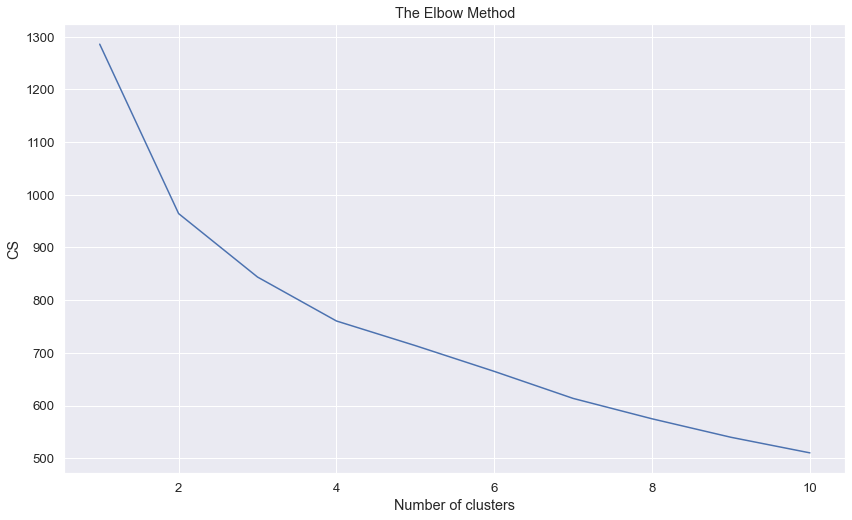

Fold: 2


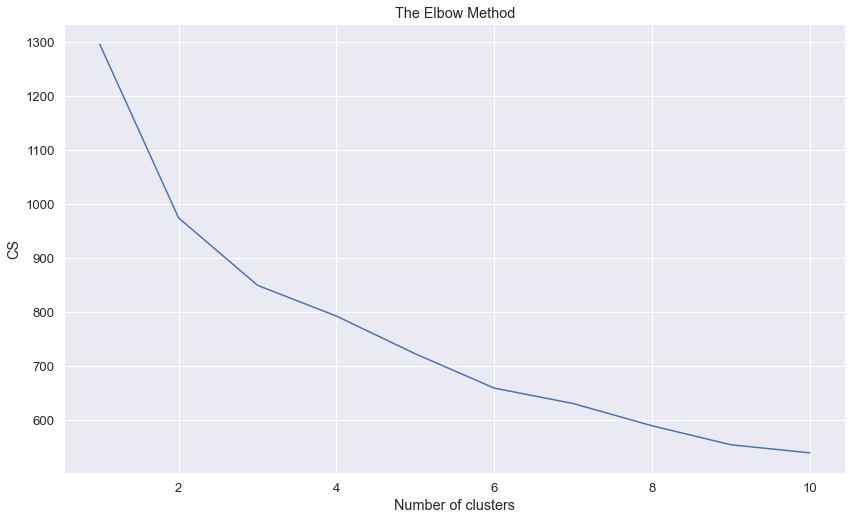

Fold: 3


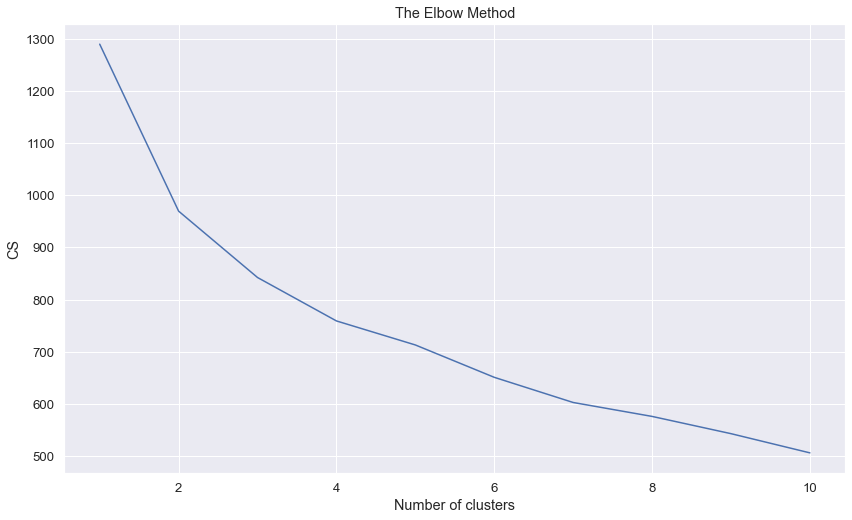

Fold: 4


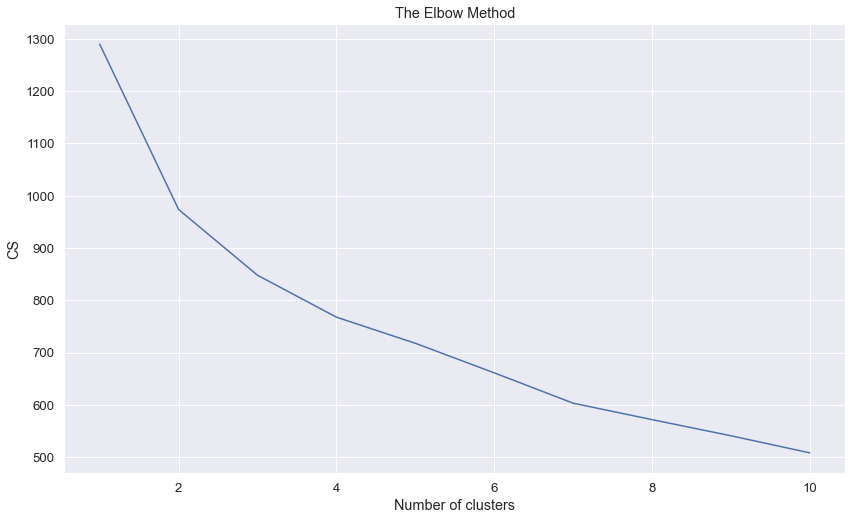

Fold: 5


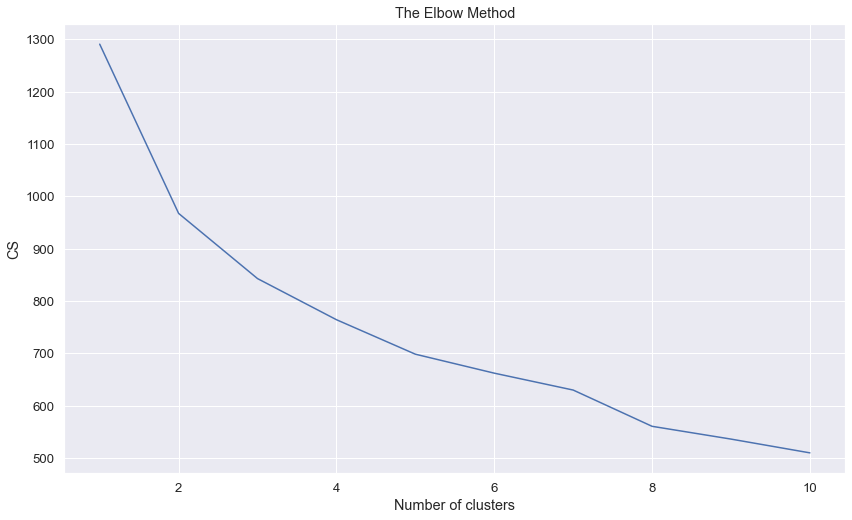

Fold: 6


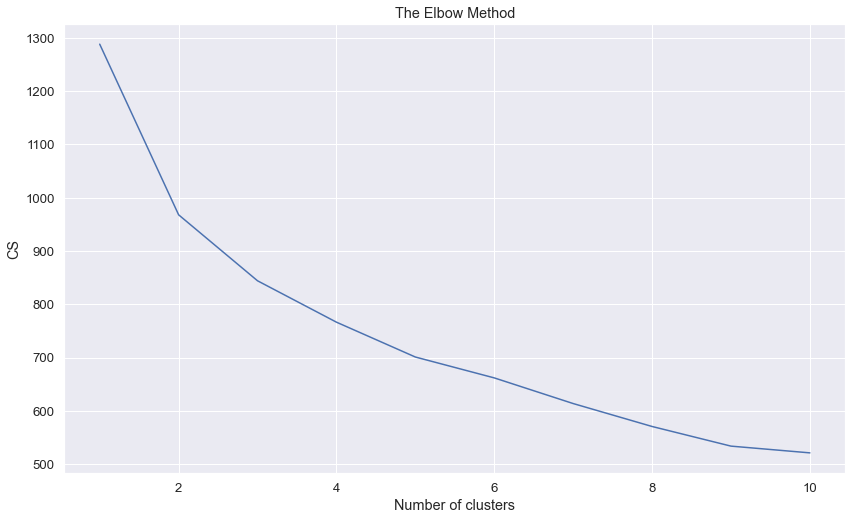

Fold: 7


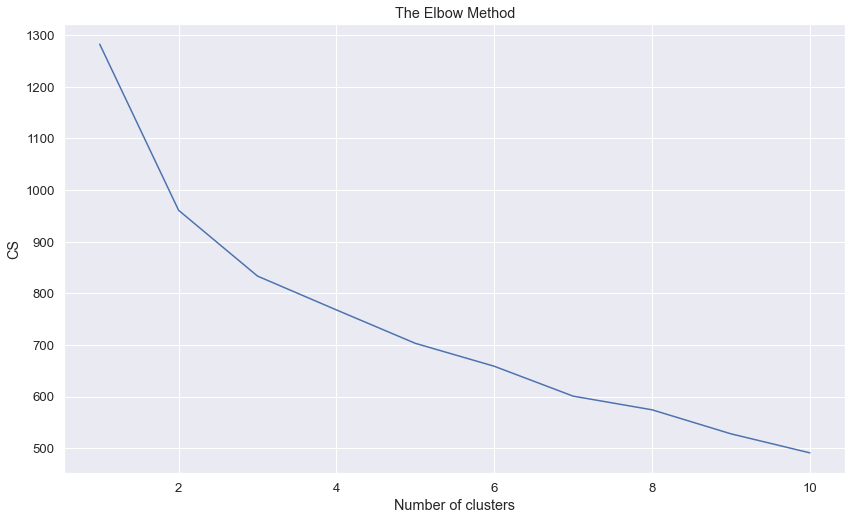

Fold: 8


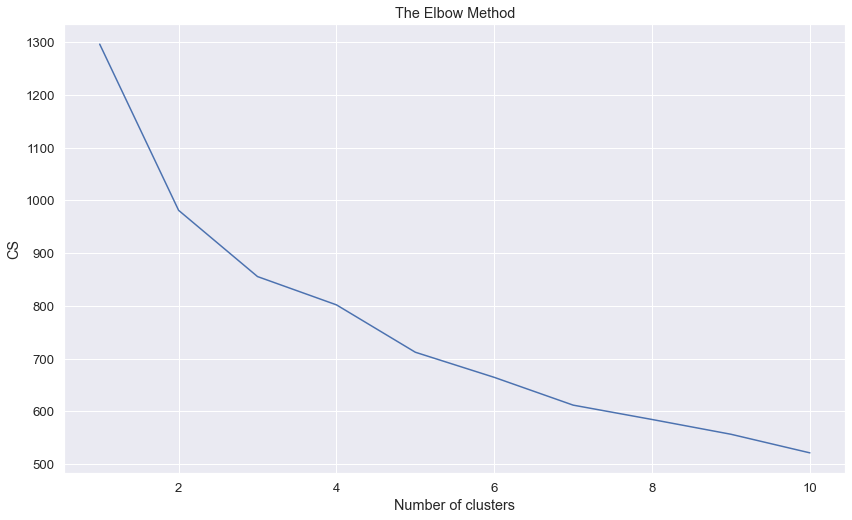

Fold: 9


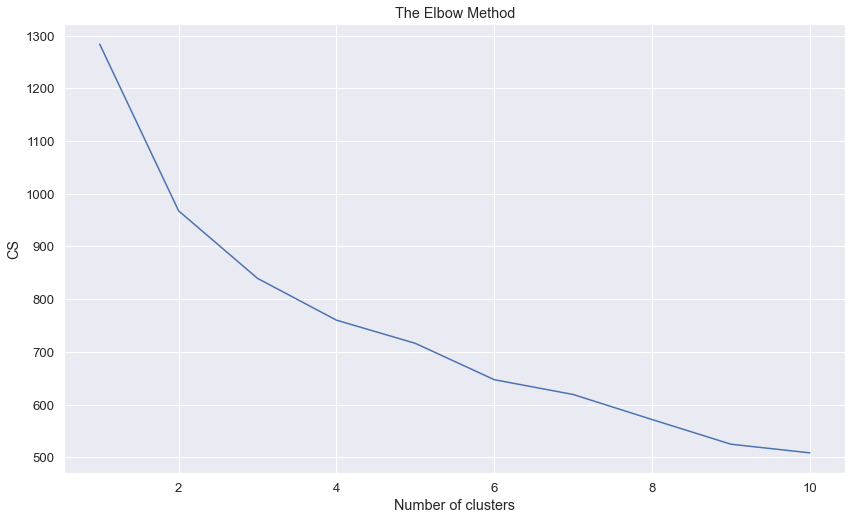

In [132]:
X_train, X_test, y_train, y_test = get_dataset_low()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Low Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        cs = []
        for i in range(1, 11):
            kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
            kmeans.fit(X_train_low)
            cs.append(kmeans.inertia_)
        plt.plot(range(1, 11), cs)
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('CS')
        plt.show()  

    k=k+1

Medium Imbalance Dataset
Fold: 1


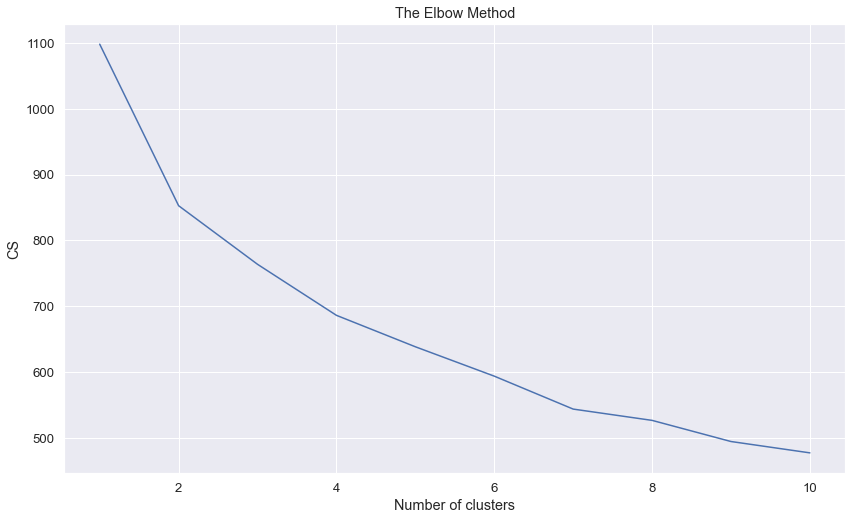

Fold: 2


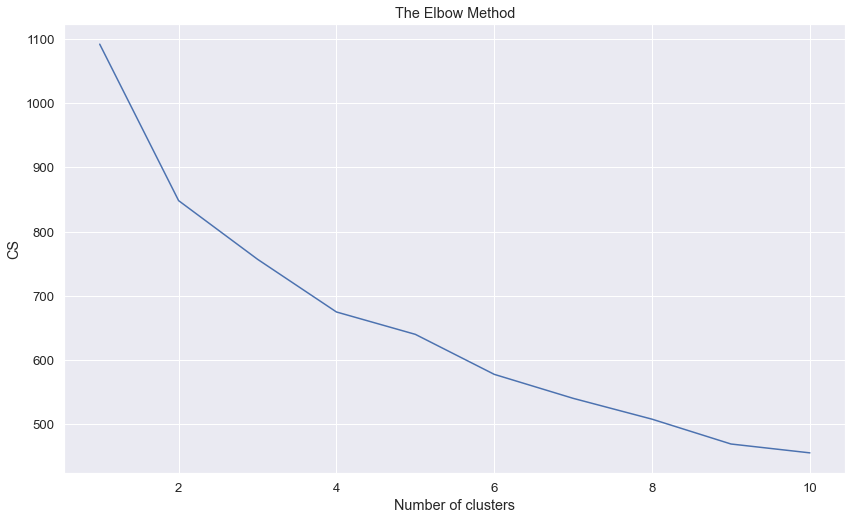

Fold: 3


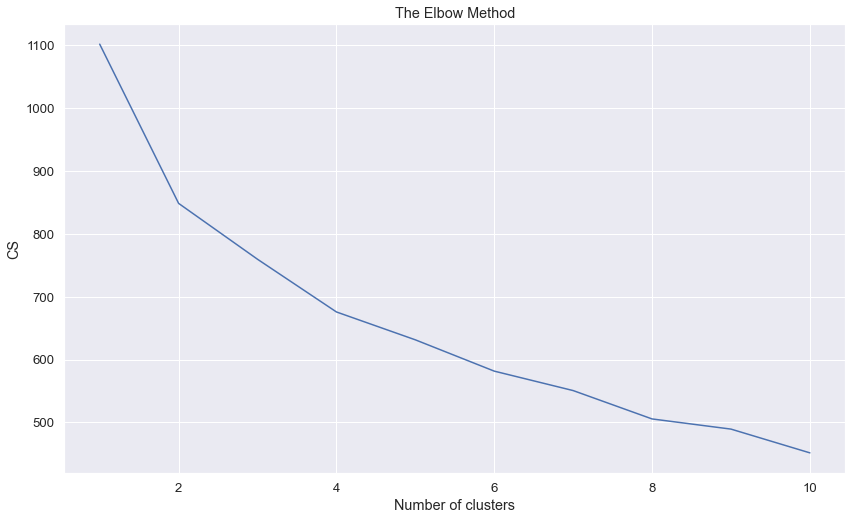

Fold: 4


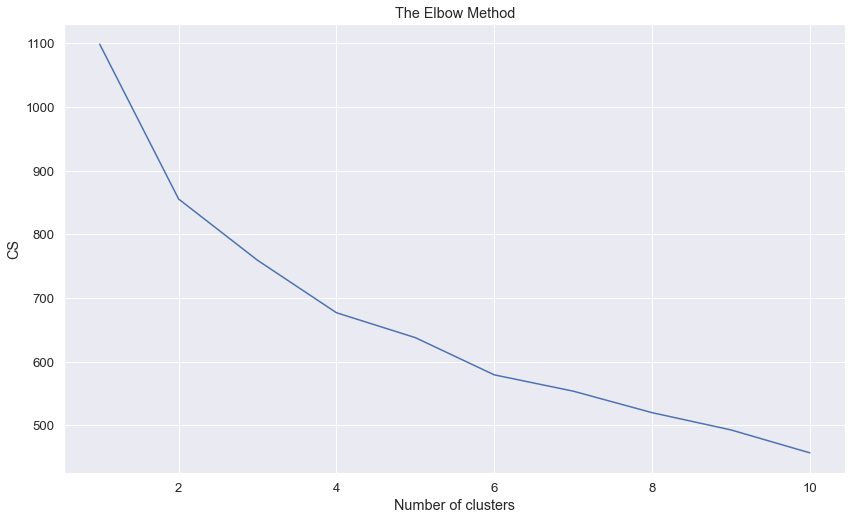

Fold: 5


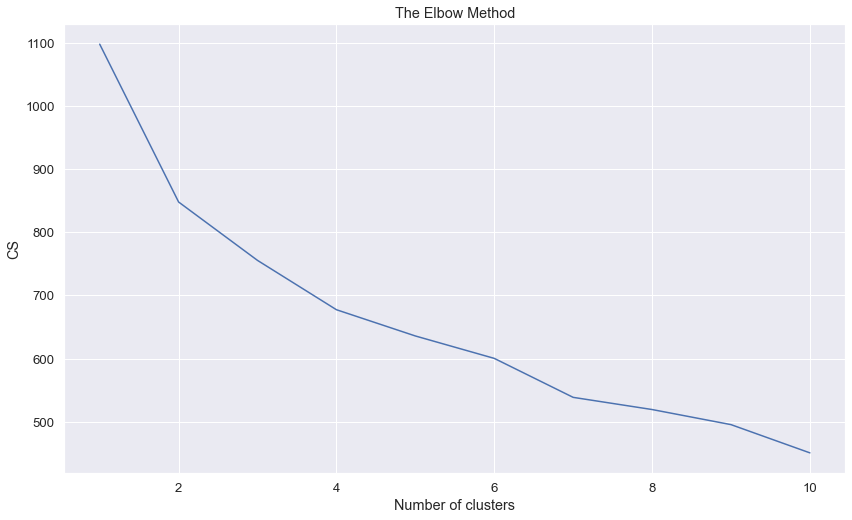

Fold: 6


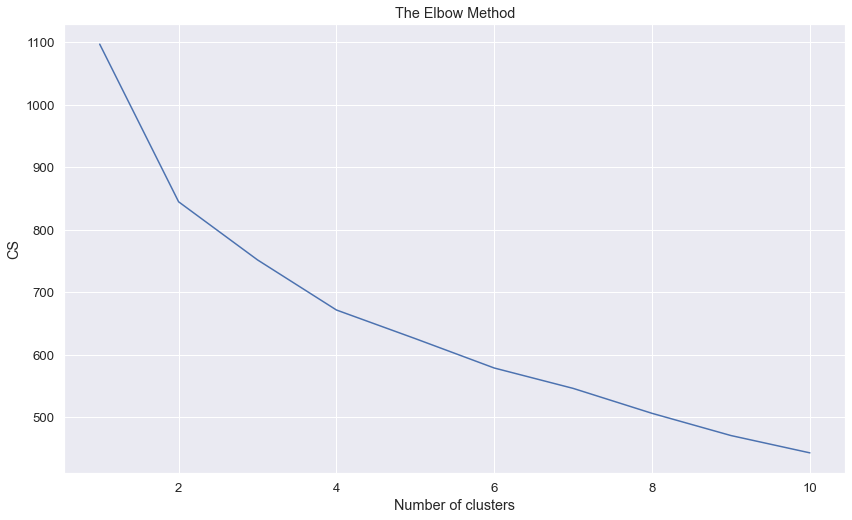

Fold: 7


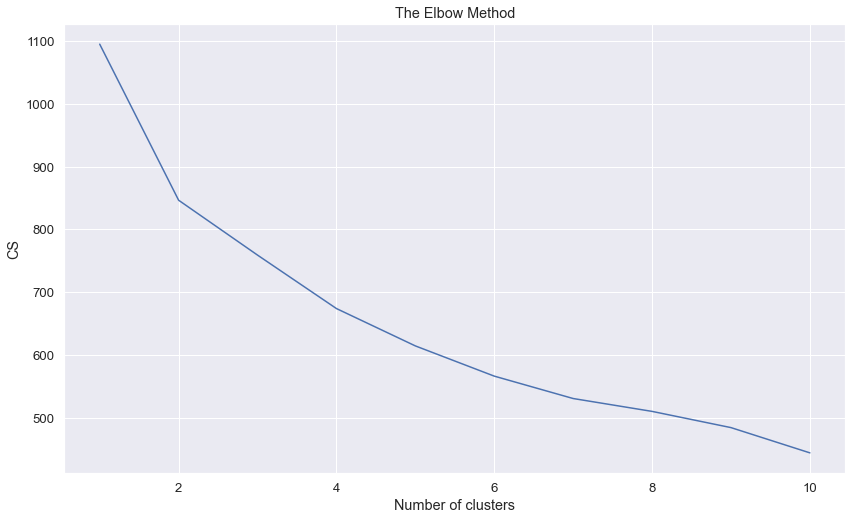

Fold: 8


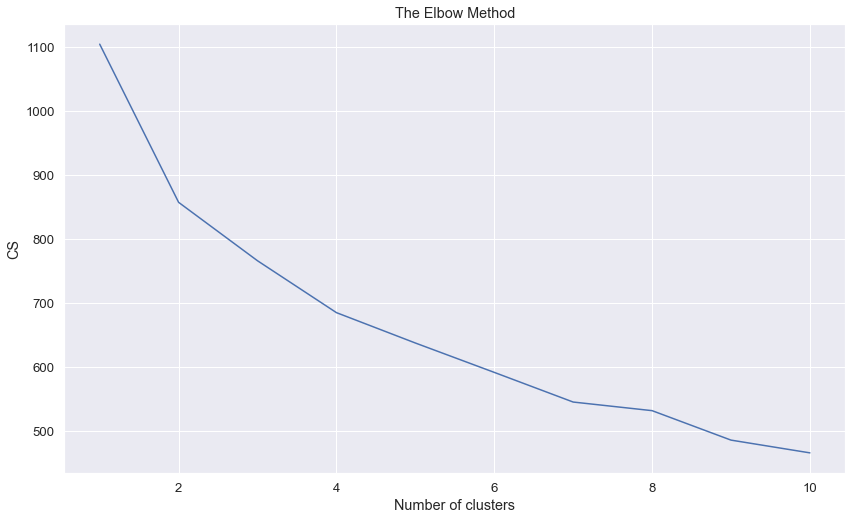

Fold: 9


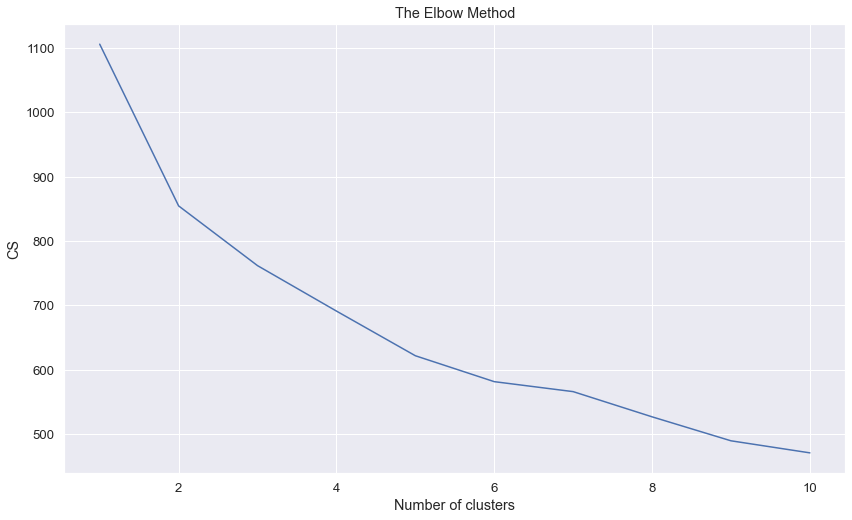

In [195]:
X_train, X_test, y_train, y_test = get_dataset_medium()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Medium Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_medium10, X_test_medium10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium10, y_test_medium10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_medium, X_test_medium = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium, y_test_medium = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        cs = []
        for i in range(1, 11):
            kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
            kmeans.fit(X_train_medium)
            cs.append(kmeans.inertia_)
        plt.plot(range(1, 11), cs)
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('CS')
        plt.show()  

    k=k+1

High Imbalance Dataset
Fold: 1


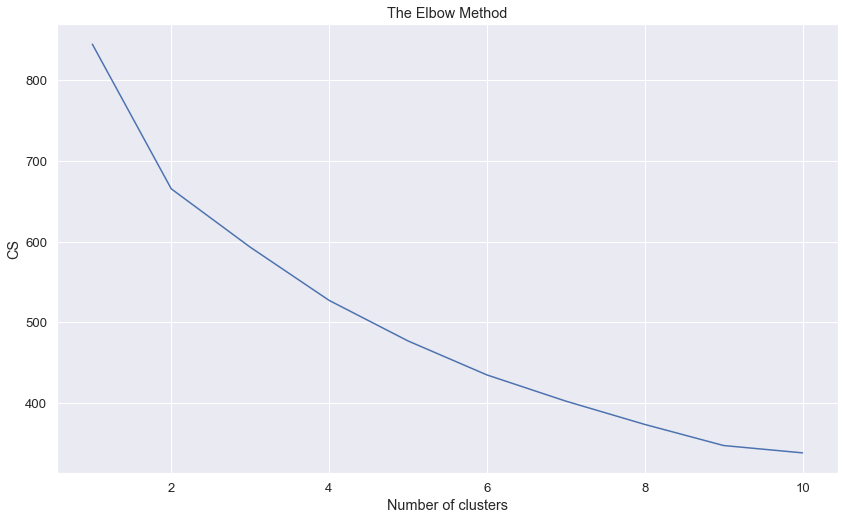

Fold: 2


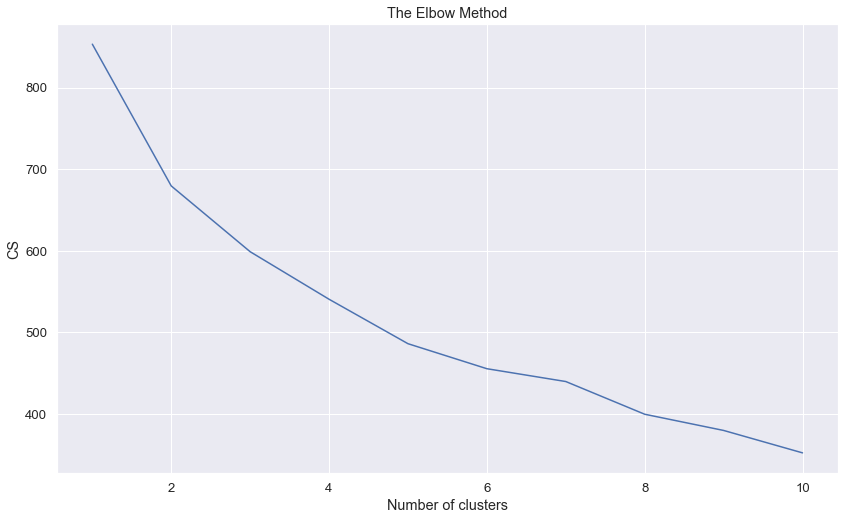

Fold: 3


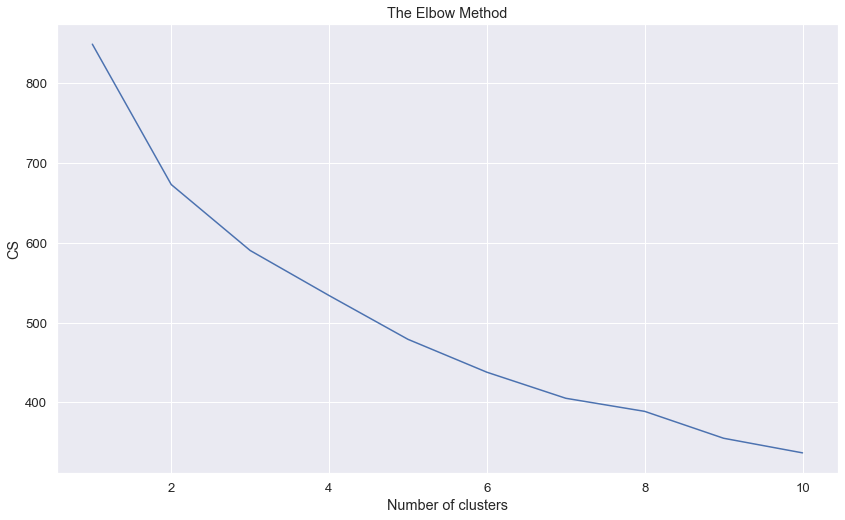

Fold: 4


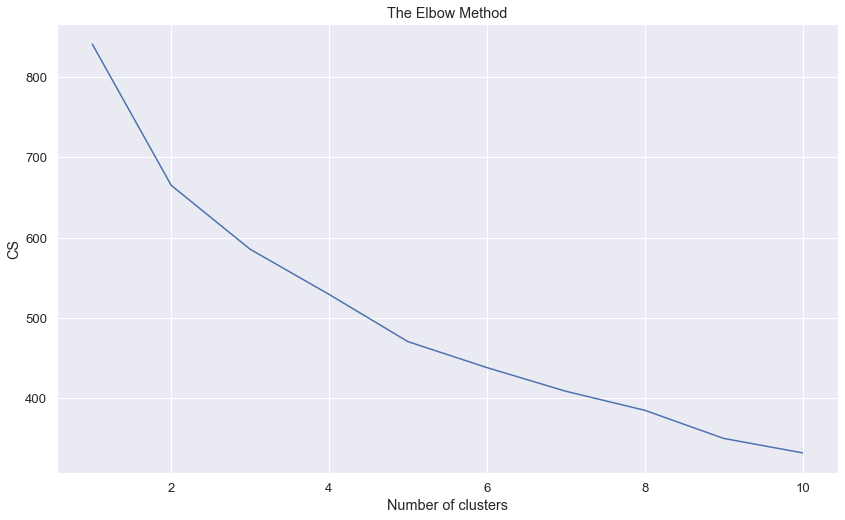

Fold: 5


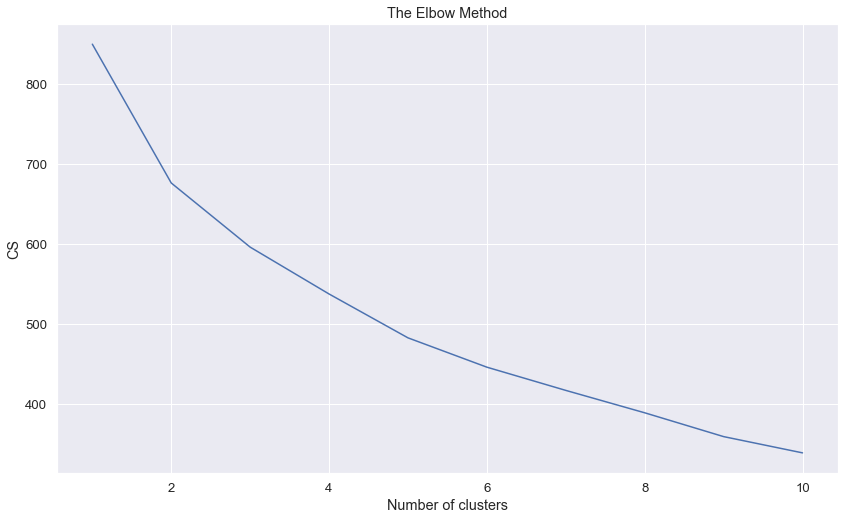

Fold: 6


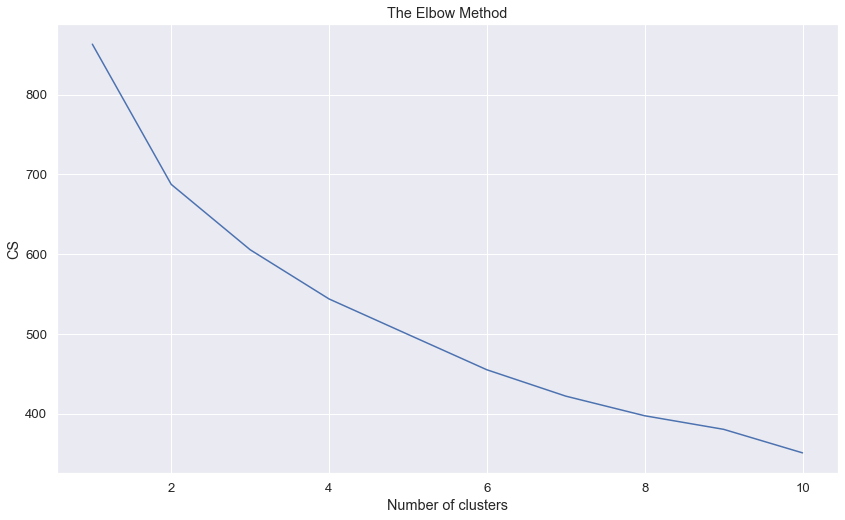

Fold: 7


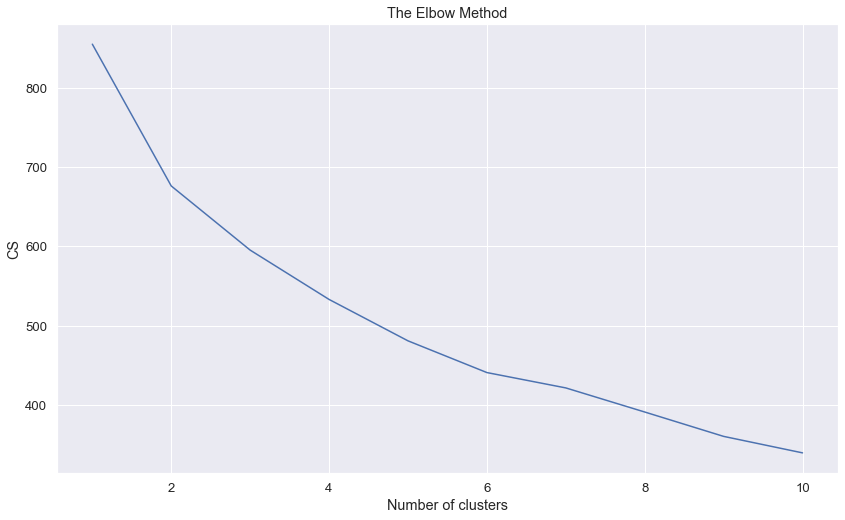

Fold: 8


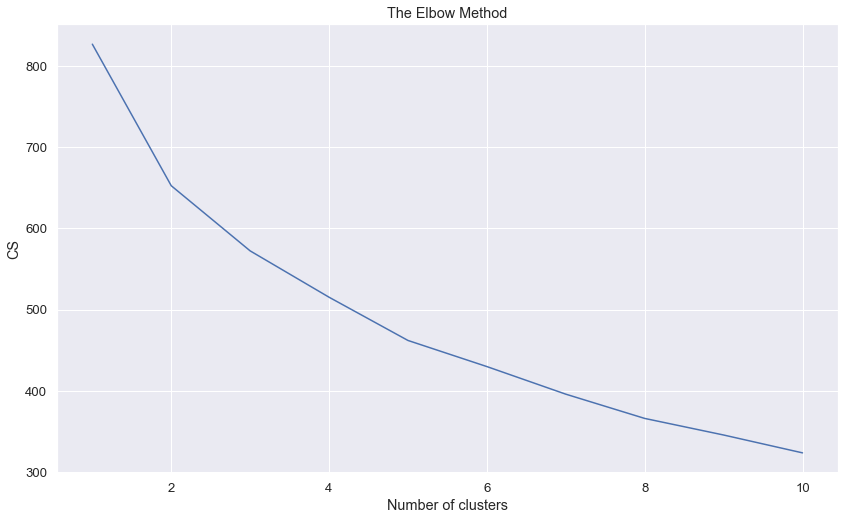

Fold: 9


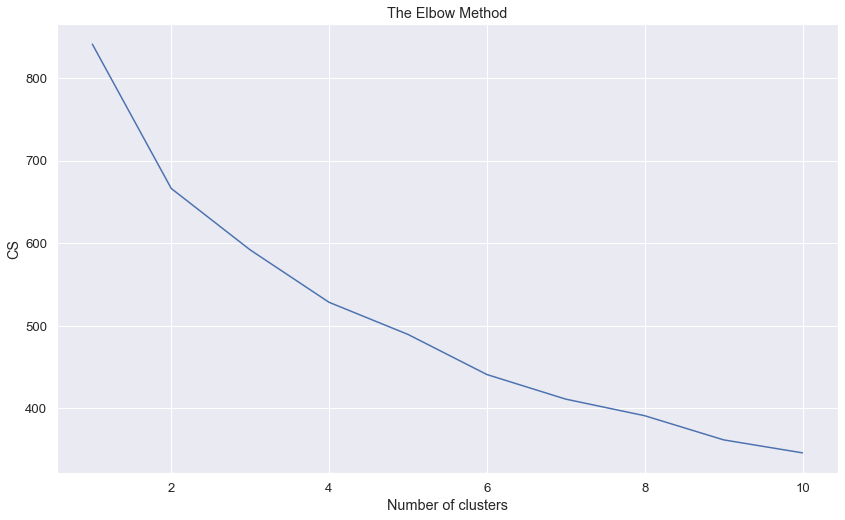

In [196]:
X_train, X_test, y_train, y_test = get_dataset_high()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("High Imbalance Dataset")
k=1
for train_index, test_index in cv.split(X_train, y_train):
    if k == 10:
        X_train_high10, X_test_high10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high10, y_test_high10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        X_train_high, X_test_high = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high, y_test_high = y_train.iloc[train_index], y_train.iloc[test_index]  
        print(f"Fold: {k}")
        cs = []
        for i in range(1, 11):
            kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
            kmeans.fit(X_train_high)
            cs.append(kmeans.inertia_)
        plt.plot(range(1, 11), cs)
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('CS')
        plt.show()  

    k=k+1

### KMeans Cluster (n_clusters = 2)<a class="anchor" id="4.2"></a>
[Task 04](#4)
    
    B. Run k-means in the data set using the identified number of clusters. Select as final clustering that with the lowest output criteria.

Low Imbalance Dataset
KFOLD:  1
Ideal: 0.499
> folds=2, accuracy=0.856 (0.830,0.881)
> folds=3, accuracy=0.619 (0.145,0.890)
> folds=4, accuracy=0.525 (0.138,0.909)
> folds=5, accuracy=0.702 (0.115,0.898)
> folds=6, accuracy=0.391 (0.096,0.877)
> folds=7, accuracy=0.676 (0.145,0.905)
> folds=8, accuracy=0.702 (0.164,0.945)
> folds=9, accuracy=0.540 (0.104,0.918)
> folds=10, accuracy=0.507 (0.091,0.930)


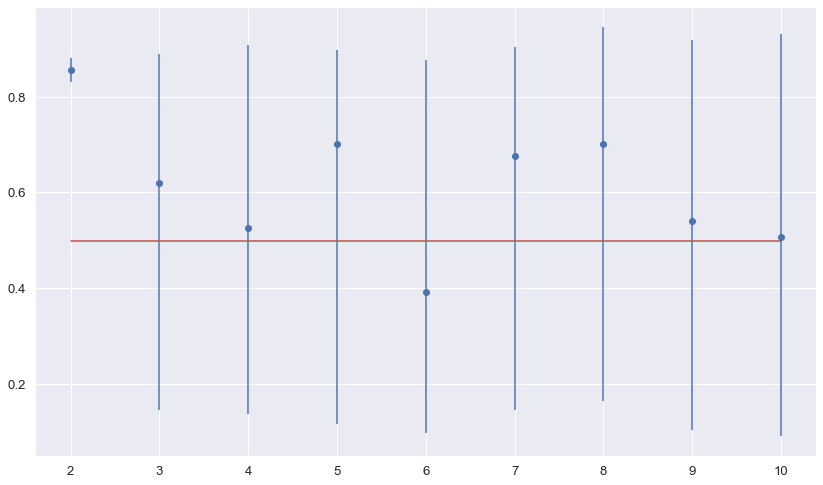

KFOLD:  2
Ideal: 0.487
> folds=2, accuracy=0.856 (0.844,0.868)
> folds=3, accuracy=0.149 (0.123,0.179)
> folds=4, accuracy=0.488 (0.118,0.853)
> folds=5, accuracy=0.556 (0.125,0.851)
> folds=6, accuracy=0.605 (0.110,0.863)
> folds=7, accuracy=0.444 (0.127,0.889)
> folds=8, accuracy=0.582 (0.073,0.873)
> folds=9, accuracy=0.703 (0.104,0.939)
> folds=10, accuracy=0.511 (0.091,0.955)


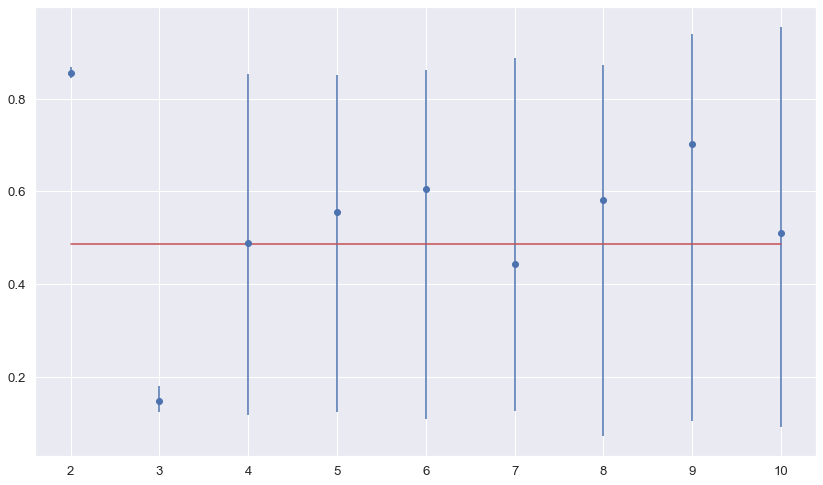

KFOLD:  3
Ideal: 0.501
> folds=2, accuracy=0.805 (0.743,0.868)
> folds=3, accuracy=0.651 (0.228,0.863)
> folds=4, accuracy=0.525 (0.156,0.891)
> folds=5, accuracy=0.455 (0.114,0.864)
> folds=6, accuracy=0.719 (0.123,0.877)
> folds=7, accuracy=0.542 (0.095,0.921)
> folds=8, accuracy=0.489 (0.091,0.873)
> folds=9, accuracy=0.481 (0.102,0.918)
> folds=10, accuracy=0.357 (0.091,0.886)


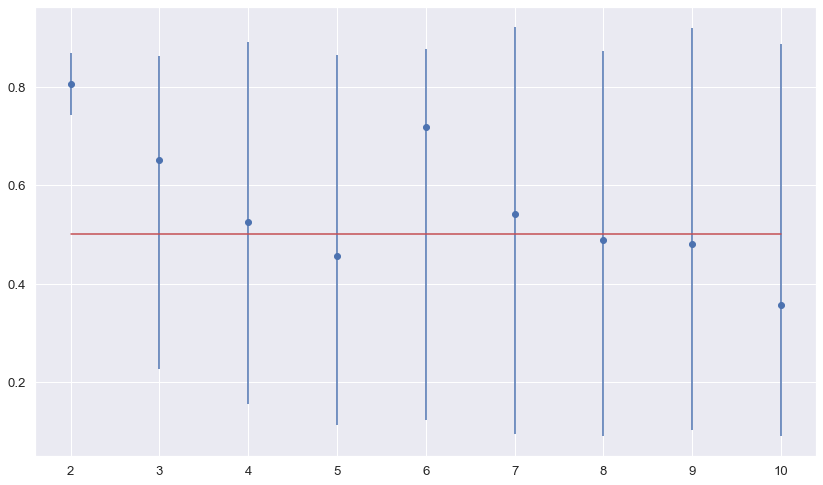

KFOLD:  4
Ideal: 0.478
> folds=2, accuracy=0.856 (0.839,0.872)
> folds=3, accuracy=0.151 (0.137,0.166)
> folds=4, accuracy=0.509 (0.156,0.908)
> folds=5, accuracy=0.300 (0.114,0.874)
> folds=6, accuracy=0.519 (0.151,0.918)
> folds=7, accuracy=0.641 (0.129,0.921)
> folds=8, accuracy=0.398 (0.055,0.873)
> folds=9, accuracy=0.333 (0.104,0.939)
> folds=10, accuracy=0.574 (0.093,0.932)


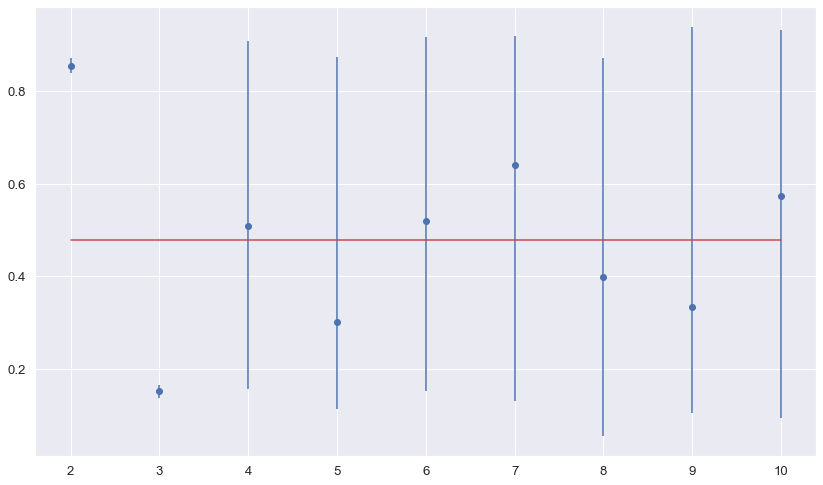

KFOLD:  5
Ideal: 0.524
> folds=2, accuracy=0.449 (0.132,0.766)
> folds=3, accuracy=0.153 (0.116,0.200)
> folds=4, accuracy=0.663 (0.138,0.881)
> folds=5, accuracy=0.579 (0.125,0.864)
> folds=6, accuracy=0.477 (0.096,0.863)
> folds=7, accuracy=0.650 (0.113,0.921)
> folds=8, accuracy=0.412 (0.091,0.891)
> folds=9, accuracy=0.556 (0.061,0.917)
> folds=10, accuracy=0.578 (0.114,0.932)


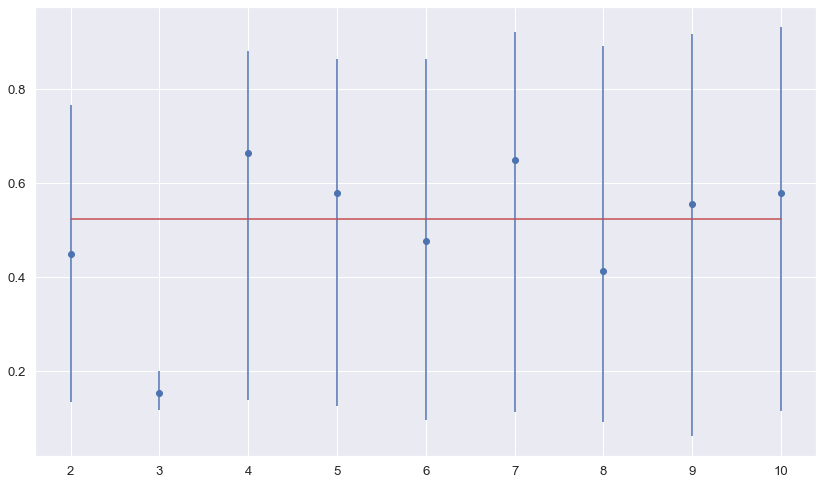

KFOLD:  6
Ideal: 0.517
> folds=2, accuracy=0.190 (0.165,0.215)
> folds=3, accuracy=0.856 (0.834,0.870)
> folds=4, accuracy=0.330 (0.109,0.872)
> folds=5, accuracy=0.290 (0.103,0.864)
> folds=6, accuracy=0.475 (0.082,0.931)
> folds=7, accuracy=0.343 (0.081,0.905)
> folds=8, accuracy=0.665 (0.093,0.909)
> folds=9, accuracy=0.539 (0.041,0.918)
> folds=10, accuracy=0.534 (0.091,0.909)


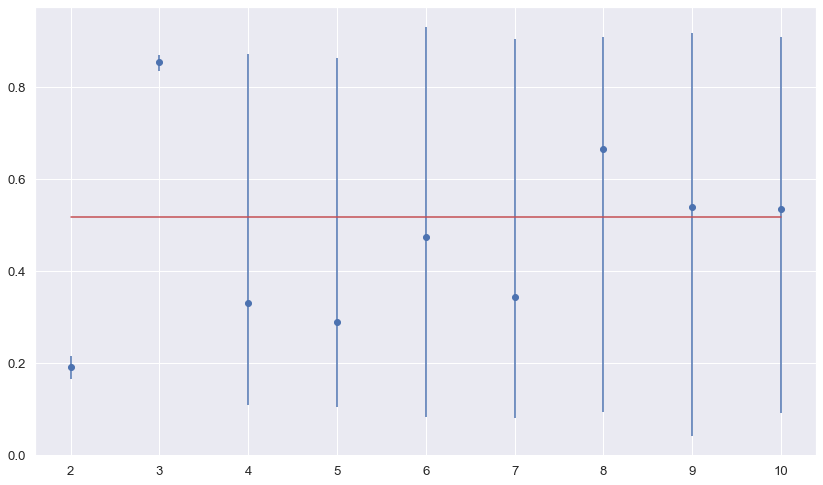

KFOLD:  7
Ideal: 0.537
> folds=2, accuracy=0.811 (0.785,0.836)
> folds=3, accuracy=0.868 (0.829,0.897)
> folds=4, accuracy=0.135 (0.091,0.193)
> folds=5, accuracy=0.469 (0.114,0.886)
> folds=6, accuracy=0.600 (0.055,0.890)
> folds=7, accuracy=0.366 (0.111,0.921)
> folds=8, accuracy=0.398 (0.055,0.909)
> folds=9, accuracy=0.607 (0.102,0.918)
> folds=10, accuracy=0.642 (0.045,0.932)


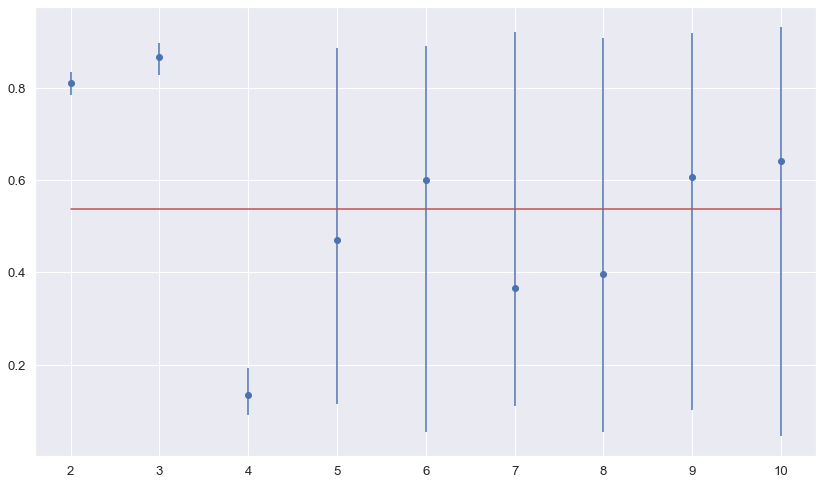

KFOLD:  8
Ideal: 0.498
> folds=2, accuracy=0.144 (0.142,0.146)
> folds=3, accuracy=0.368 (0.130,0.836)
> folds=4, accuracy=0.684 (0.156,0.873)
> folds=5, accuracy=0.429 (0.115,0.875)
> folds=6, accuracy=0.390 (0.110,0.877)
> folds=7, accuracy=0.431 (0.097,0.889)
> folds=8, accuracy=0.418 (0.127,0.907)
> folds=9, accuracy=0.596 (0.102,0.917)
> folds=10, accuracy=0.561 (0.093,0.909)


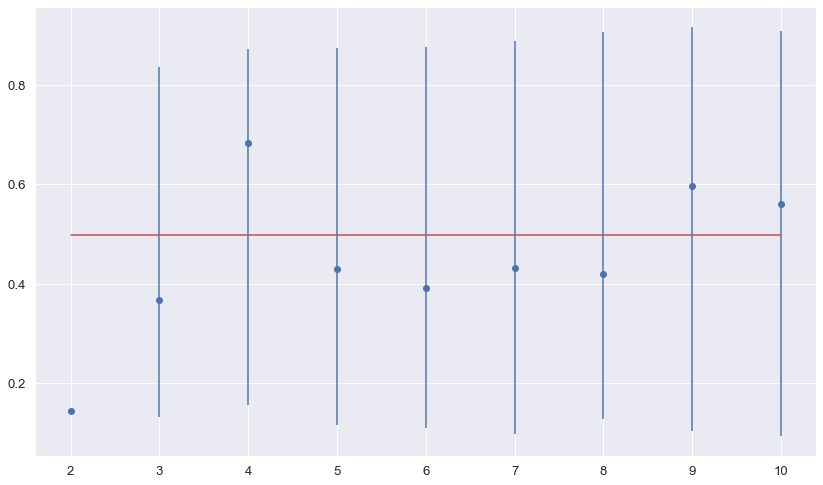

KFOLD:  9
Ideal: 0.500
> folds=2, accuracy=0.144 (0.137,0.151)
> folds=3, accuracy=0.395 (0.158,0.863)
> folds=4, accuracy=0.452 (0.101,0.789)
> folds=5, accuracy=0.559 (0.114,0.885)
> folds=6, accuracy=0.493 (0.123,0.863)
> folds=7, accuracy=0.629 (0.111,0.871)
> folds=8, accuracy=0.601 (0.109,0.891)
> folds=9, accuracy=0.478 (0.122,0.938)
> folds=10, accuracy=0.575 (0.114,0.886)


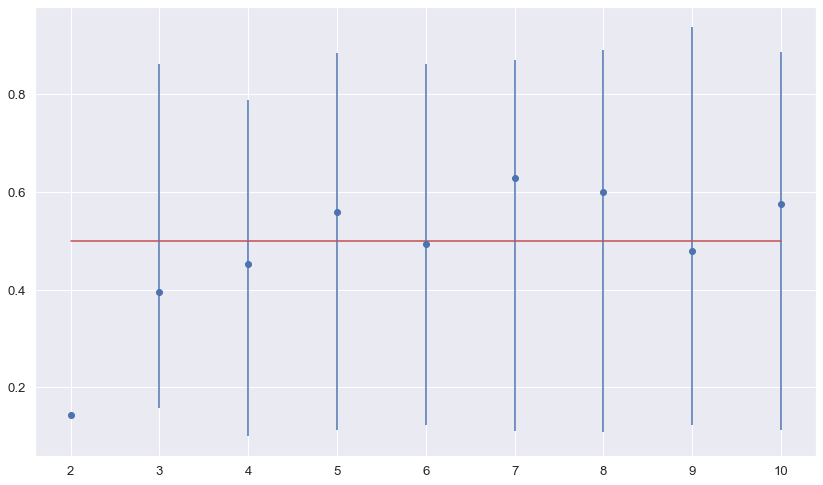

KFOLD:  10


In [133]:
X_train, X_test, y_train, y_test = get_dataset_low()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Low Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        # evaluate the model using a given test condition
        def evaluate_model(cv):
            # get the model
            model = KMeans(n_clusters=2)
            # evaluate the model
            scores = cross_val_score(model, X_train_low, y_train_low, scoring='accuracy', cv=cv, n_jobs=-1)
            # return scores
            return np.mean(scores), scores.min(), scores.max()
        
        # calculate the ideal test condition
        ideal, _, _ = evaluate_model(LeaveOneOut())
        print('Ideal: %.3f' % ideal)
        # define folds to test
        folds = range(2,11)
        # record mean and min/max of each set of results
        means, mins, maxs = list(),list(),list()
        # evaluate each k value
        for k in folds:
            # define the test condition
            cv = KFold(n_splits=k, shuffle=True, random_state=1)
            # evaluate k value
            k_mean, k_min, k_max = evaluate_model(cv)
            # report performance
            print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
            # store mean accuracy
            means.append(k_mean)
            # store min and max relative to the mean
            mins.append(k_mean - k_min)
            maxs.append(k_max - k_mean)
        # line plot of k mean values with min/max error bars
        plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
        # plot the ideal case in a separate color
        plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
        # show the plot
        plt.show()

Medium Imbalance Dataset
KFOLD:  1
Ideal: 0.488
> folds=2, accuracy=0.509 (0.295,0.723)
> folds=3, accuracy=0.601 (0.331,0.787)
> folds=4, accuracy=0.378 (0.253,0.684)
> folds=5, accuracy=0.465 (0.237,0.737)
> folds=6, accuracy=0.425 (0.156,0.746)
> folds=7, accuracy=0.665 (0.327,0.800)
> folds=8, accuracy=0.483 (0.292,0.792)
> folds=9, accuracy=0.376 (0.143,0.738)
> folds=10, accuracy=0.554 (0.237,0.816)


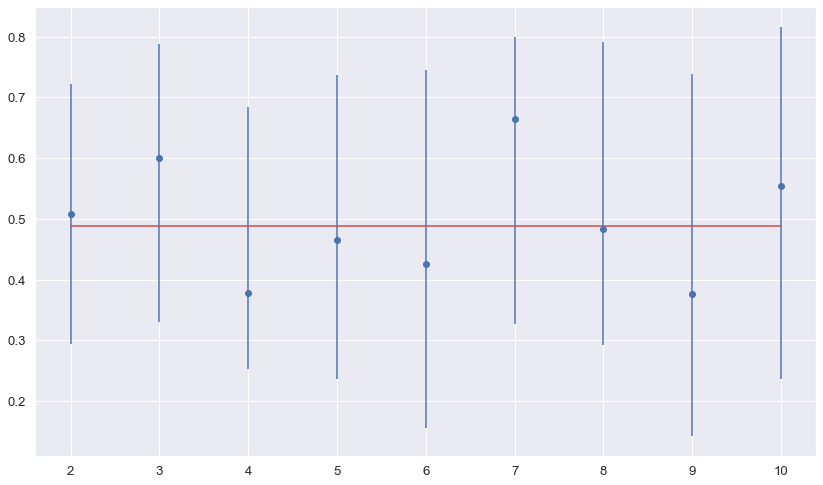

KFOLD:  2
Ideal: 0.444
> folds=2, accuracy=0.475 (0.274,0.675)
> folds=3, accuracy=0.701 (0.685,0.717)
> folds=4, accuracy=0.577 (0.253,0.740)
> folds=5, accuracy=0.627 (0.316,0.737)
> folds=6, accuracy=0.386 (0.254,0.762)
> folds=7, accuracy=0.613 (0.291,0.778)
> folds=8, accuracy=0.519 (0.170,0.812)
> folds=9, accuracy=0.465 (0.190,0.786)
> folds=10, accuracy=0.489 (0.237,0.789)


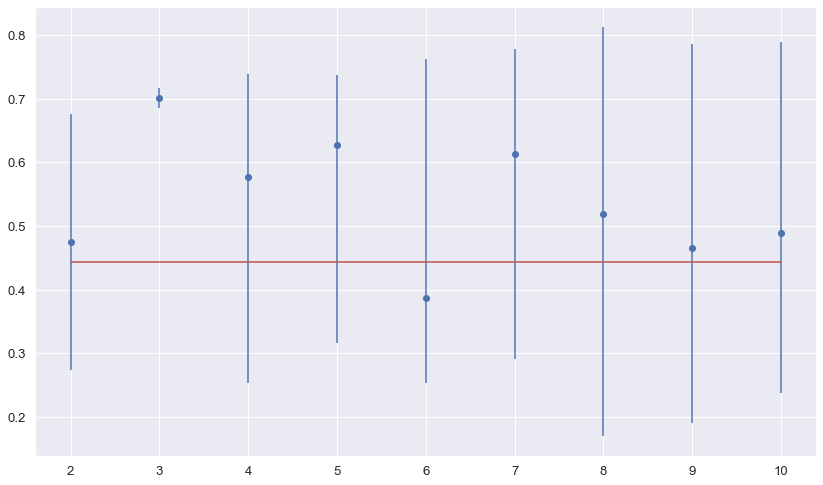

KFOLD:  3
Ideal: 0.493
> folds=2, accuracy=0.483 (0.288,0.679)
> folds=3, accuracy=0.407 (0.276,0.654)
> folds=4, accuracy=0.407 (0.281,0.705)
> folds=5, accuracy=0.368 (0.224,0.658)
> folds=6, accuracy=0.305 (0.234,0.359)
> folds=7, accuracy=0.544 (0.296,0.764)
> folds=8, accuracy=0.523 (0.208,0.750)
> folds=9, accuracy=0.381 (0.190,0.714)
> folds=10, accuracy=0.469 (0.211,0.744)


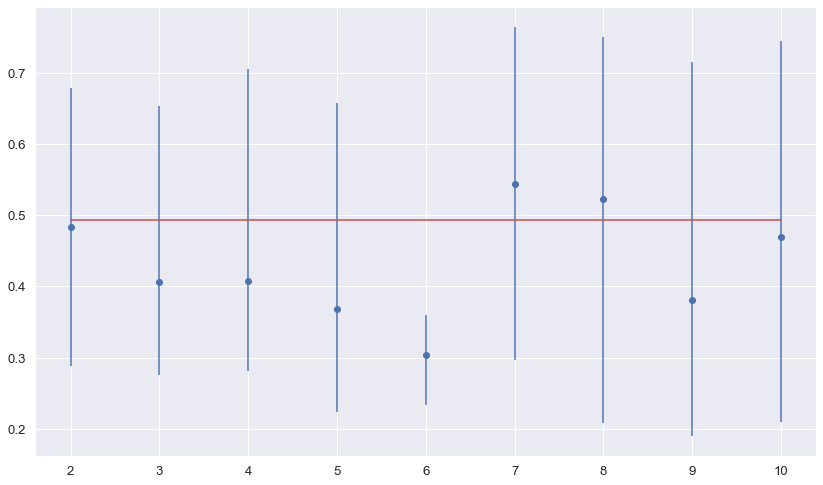

KFOLD:  4
Ideal: 0.504
> folds=2, accuracy=0.312 (0.293,0.332)
> folds=3, accuracy=0.430 (0.283,0.677)
> folds=4, accuracy=0.519 (0.295,0.719)
> folds=5, accuracy=0.603 (0.289,0.740)
> folds=6, accuracy=0.441 (0.219,0.698)
> folds=7, accuracy=0.564 (0.241,0.745)
> folds=8, accuracy=0.467 (0.292,0.729)
> folds=9, accuracy=0.608 (0.286,0.744)
> folds=10, accuracy=0.467 (0.237,0.763)


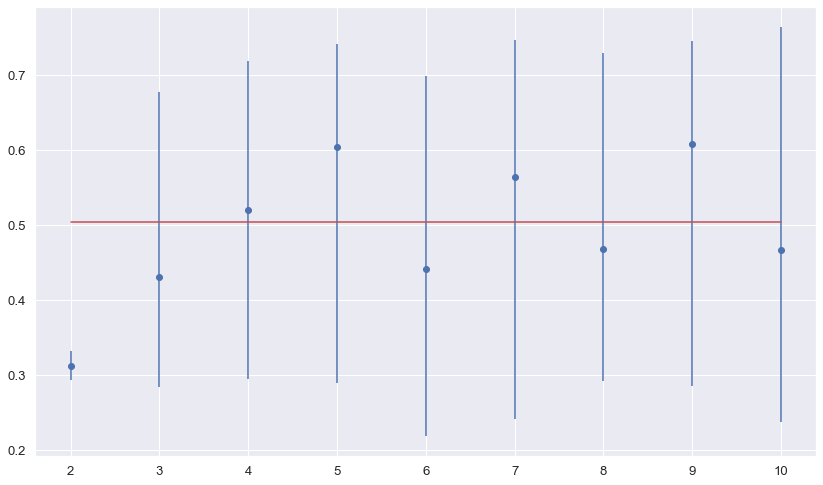

KFOLD:  5
Ideal: 0.466
> folds=2, accuracy=0.312 (0.246,0.377)
> folds=3, accuracy=0.628 (0.409,0.750)
> folds=4, accuracy=0.312 (0.208,0.389)
> folds=5, accuracy=0.571 (0.208,0.763)
> folds=6, accuracy=0.456 (0.203,0.703)
> folds=7, accuracy=0.473 (0.236,0.782)
> folds=8, accuracy=0.421 (0.167,0.792)
> folds=9, accuracy=0.474 (0.209,0.767)
> folds=10, accuracy=0.551 (0.184,0.795)


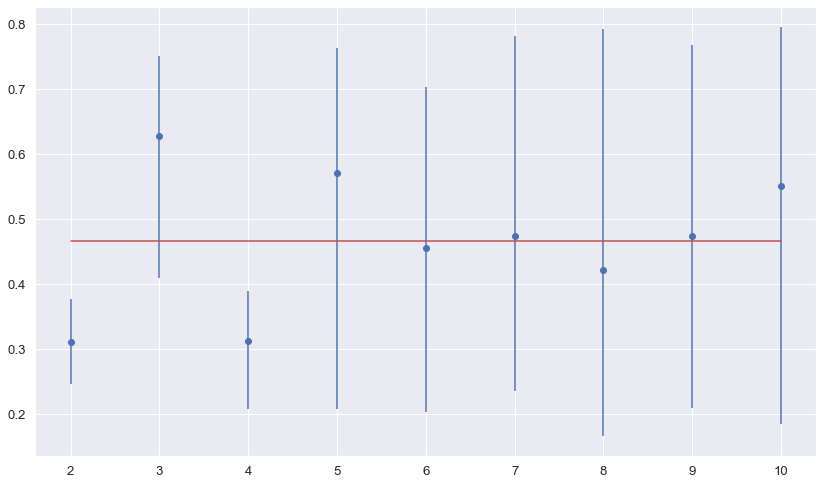

KFOLD:  6
Ideal: 0.508
> folds=2, accuracy=0.500 (0.304,0.696)
> folds=3, accuracy=0.448 (0.289,0.717)
> folds=4, accuracy=0.738 (0.674,0.833)
> folds=5, accuracy=0.617 (0.303,0.753)
> folds=6, accuracy=0.566 (0.250,0.730)
> folds=7, accuracy=0.353 (0.182,0.673)
> folds=8, accuracy=0.510 (0.277,0.812)
> folds=9, accuracy=0.436 (0.186,0.738)
> folds=10, accuracy=0.527 (0.179,0.737)


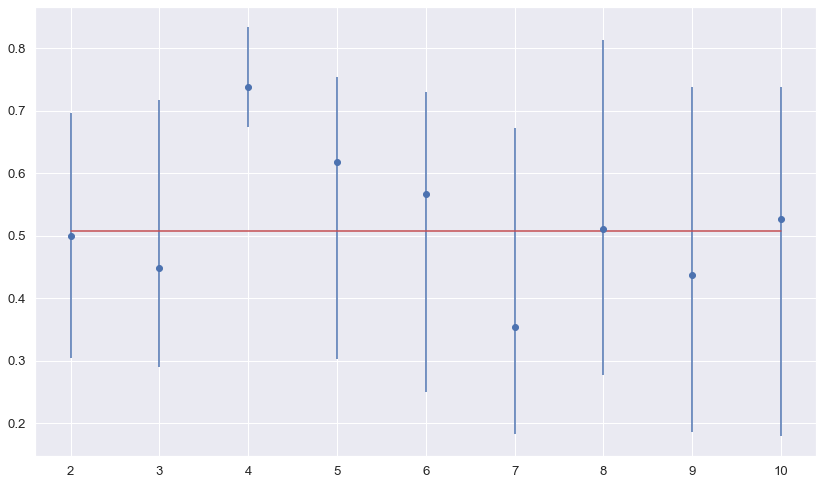

KFOLD:  7
Ideal: 0.492
> folds=2, accuracy=0.484 (0.272,0.696)
> folds=3, accuracy=0.542 (0.260,0.709)
> folds=4, accuracy=0.521 (0.316,0.768)
> folds=5, accuracy=0.512 (0.250,0.711)
> folds=6, accuracy=0.702 (0.609,0.762)
> folds=7, accuracy=0.505 (0.259,0.759)
> folds=8, accuracy=0.418 (0.191,0.688)
> folds=9, accuracy=0.517 (0.214,0.833)
> folds=10, accuracy=0.432 (0.184,0.684)


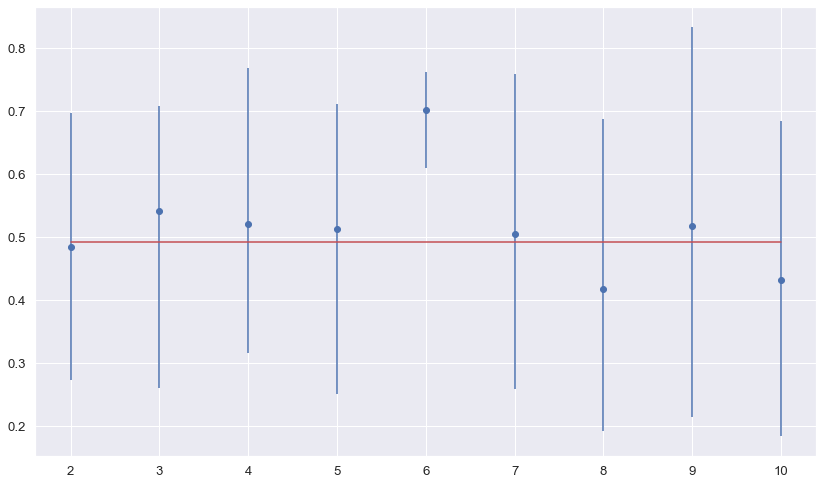

KFOLD:  8


KeyboardInterrupt: 

In [134]:
X_train, X_test, y_train, y_test = get_dataset_medium()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Medium Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_medium10, X_test_medium10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium10, y_test_medium10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_medium, X_test_medium = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_medium, y_test_medium = y_train.iloc[train_index], y_train.iloc[test_index]  
        # evaluate the model using a given test condition
        def evaluate_model(cv):
            # get the model
            model = KMeans(n_clusters=2)
            # evaluate the model
            scores = cross_val_score(model, X_train_medium, y_train_medium, scoring='accuracy', cv=cv, n_jobs=-1)
            # return scores
            return np.mean(scores), scores.min(), scores.max()
        
        # calculate the ideal test condition
        ideal, _, _ = evaluate_model(LeaveOneOut())
        print('Ideal: %.3f' % ideal)
        # define folds to test
        folds = range(2,11)
        # record mean and min/max of each set of results
        means, mins, maxs = list(),list(),list()
        # evaluate each k value
        for k in folds:
            # define the test condition
            cv = KFold(n_splits=k, shuffle=True, random_state=1)
            # evaluate k value
            k_mean, k_min, k_max = evaluate_model(cv)
            # report performance
            print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
            # store mean accuracy
            means.append(k_mean)
            # store min and max relative to the mean
            mins.append(k_mean - k_min)
            maxs.append(k_max - k_mean)
        # line plot of k mean values with min/max error bars
        plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
        # plot the ideal case in a separate color
        plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
        # show the plot
        plt.show()

In [ ]:
X_train, X_test, y_train, y_test = get_dataset_high()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("High Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_high10, X_test_high10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high10, y_test_high10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_high, X_test_high = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_high, y_test_high = y_train.iloc[train_index], y_train.iloc[test_index]  
        # evaluate the model using a given test condition
        def evaluate_model(cv):
            
            # get the model
            model = KMeans(n_clusters=2)
            # evaluate the model
            scores = cross_val_score(model, X_train_high, y_train_high, scoring='accuracy', cv=cv, n_jobs=-1)
            # return scores
            return np.mean(scores), scores.min(), scores.max()
        
        # calculate the ideal test condition
        ideal, _, _ = evaluate_model(LeaveOneOut())
        print('Ideal: %.3f' % ideal)
        # define folds to test
        folds = range(2,11)
        # record mean and min/max of each set of results
        means, mins, maxs = list(),list(),list()
        # evaluate each k value
        for k in folds:
            # define the test condition
            cv = KFold(n_splits=k, shuffle=True, random_state=1)
            # evaluate k value
            k_mean, k_min, k_max = evaluate_model(cv)
            # report performance
            print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
            # store mean accuracy
            means.append(k_mean)
            # store min and max relative to the mean
            mins.append(k_mean - k_min)
            maxs.append(k_max - k_mean)
        # line plot of k mean values with min/max error bars
        plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
        # plot the ideal case in a separate color
        plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
        # show the plot
        plt.show()

### For each cluster, identify its centroid<a class="anchor" id="4.3"></a>
    C. For each cluster, identify its centroid and the number of samples of the minority class in that cluster (as per their labels). Save this information.
[Task 04](#4)

In [ ]:
# y_train_low

[[0.45139238 0.36599161 0.25927415 0.60850402 0.07866135 0.2955665
  0.7044335  0.16256158 0.39408867 0.34975369 0.09359606 0.84236453
  0.15763547 0.23152709 0.64039409 0.12807882 0.98522167 0.01477833
  0.03940887 0.19704433 0.7635468 ]
 [0.57777457 0.3869258  0.27395255 0.42219506 0.25150036 0.1024735
  0.8975265  0.88339223 0.03180212 0.06360424 0.02120141 0.78798587
  0.21201413 0.24734982 0.53710247 0.2155477  0.22614841 0.77385159
  0.08833922 0.85159011 0.06007067]]
[1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0
 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1
 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1
 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0
 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1
 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0
 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 

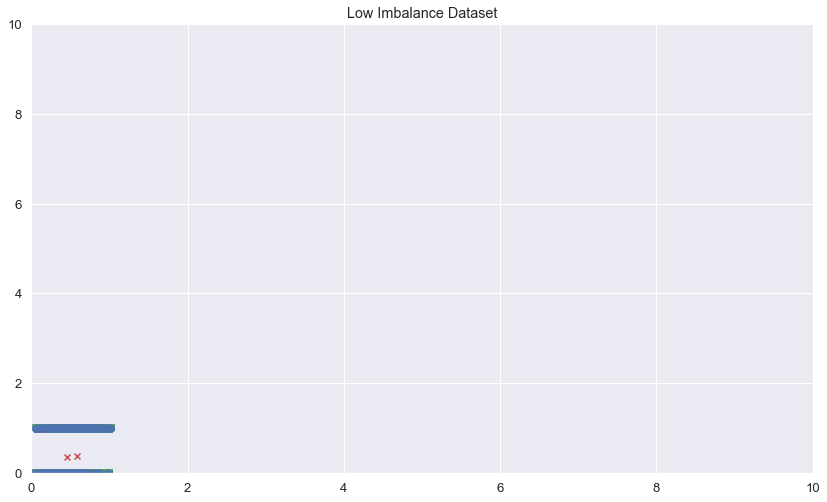

In [135]:
X_train_low, X_test_low, y_train_low, y_test_low = get_dataset_low()
model_low = KMeans(n_clusters=2)
model_low.fit(X_train_low)
centroids = model_low.cluster_centers_

print(centroids)
print(model_low.labels_)
print (Counter(model_low.labels_))

colors = ['b', 'g']
markers = ['o', 'v']
for i, l in enumerate(model_low.labels_):
    plt.scatter(X_train_low.iloc[: , 0], y_train_low['HeartDisease'], c= colors[l], marker=markers[l], s=50, alpha=0.5)
    plt.xlim([0, 10])
    plt.ylim([0, 10])
plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='r')
plt.title("Low Imbalance Dataset")
plt.show()

[[ 5.00667557e-01  3.60289027e-01  3.31939089e-01  5.91762134e-01
   1.33363003e-01  2.42990654e-01  7.57009346e-01  4.29906542e-01
   2.42990654e-01  2.28971963e-01  9.81308411e-02  8.31775701e-01
   1.68224299e-01  2.61682243e-01  6.49532710e-01  8.87850467e-02
   1.00000000e+00  1.11022302e-15  4.20560748e-02  4.57943925e-01
   5.00000000e-01]
 [ 5.68318756e-01  4.22442681e-01  3.43290043e-01  4.37442396e-01
   2.78231293e-01  1.04761905e-01  8.95238095e-01  8.23809524e-01
   2.85714286e-02  1.09523810e-01  3.80952381e-02  7.90476190e-01
   2.09523810e-01  1.90476190e-01  5.71428571e-01  2.38095238e-01
  -1.11022302e-15  1.00000000e+00  7.61904762e-02  8.38095238e-01
   8.57142857e-02]]
[1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1
 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0
 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1
 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0
 

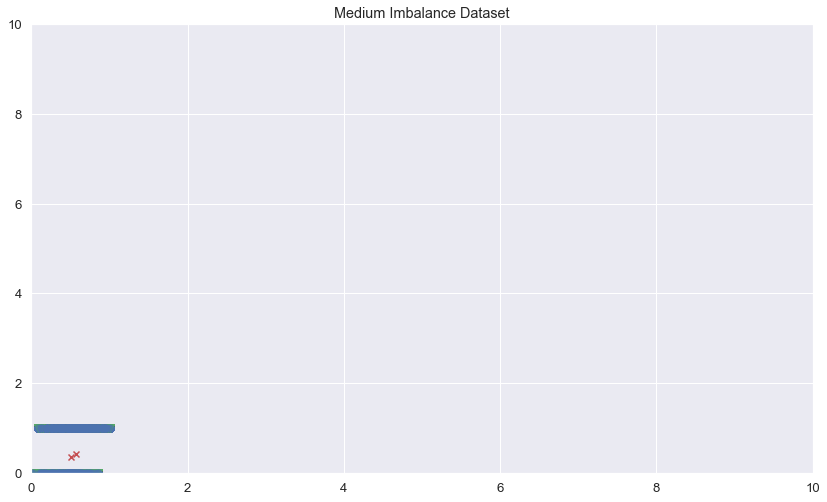

In [136]:
X_train_medium, X_test_medium, y_train_medium, y_test_medium = get_dataset_medium()
model_medium = KMeans(n_clusters=2)
model_medium.fit(X_train_medium)
centroids = model_medium.cluster_centers_

print(centroids)
print(model_medium.labels_)
print (Counter(model_medium.labels_))

colors = ['b', 'g']
markers = ['o', 'v']
for i, l in enumerate(model_medium.labels_):
    plt.scatter(X_train_medium.iloc[: , 0], y_train_medium['HeartDisease'], c= colors[l], marker=markers[l], s=50, alpha=0.5)
    plt.xlim([0, 10])
    plt.ylim([0, 10])
plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='r')
plt.title("Medium Imbalance Dataset")
plt.show()

[[ 5.33742960e-01  4.36092514e-01  2.83358727e-01  4.29834993e-01
   2.89430653e-01  1.05990783e-01  8.94009217e-01  8.57142857e-01
   2.30414747e-02  1.15207373e-01  4.60829493e-03  7.74193548e-01
   2.25806452e-01  1.98156682e-01  5.80645161e-01  2.21198157e-01
  -4.99600361e-16  1.00000000e+00  1.15207373e-01  7.97235023e-01
   8.75576037e-02]
 [ 4.91873964e-01  3.60321036e-01  2.67960401e-01  5.69029851e-01
   1.31319210e-01  2.46268657e-01  7.53731343e-01  5.29850746e-01
   2.23880597e-01  2.08955224e-01  3.73134328e-02  8.35820896e-01
   1.64179104e-01  3.20895522e-01  5.44776119e-01  1.34328358e-01
   1.00000000e+00  4.44089210e-16  5.22388060e-02  6.19402985e-01
   3.28358209e-01]]
[1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0
 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0
 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0
 

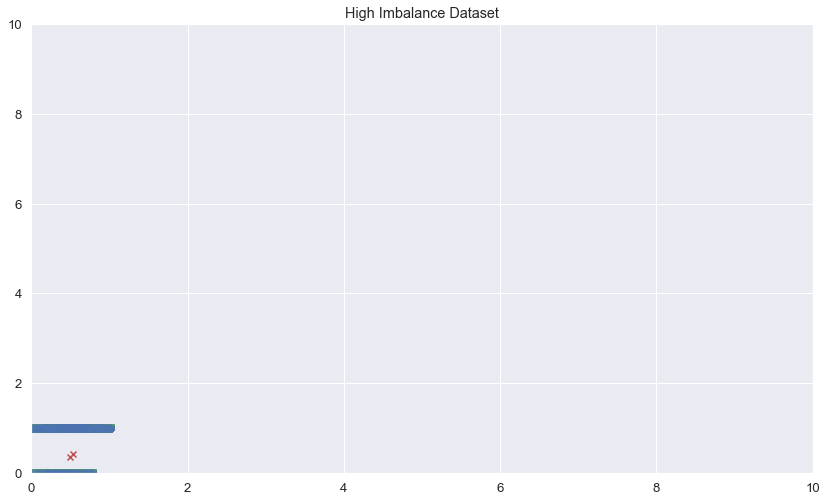

In [137]:
X_train_high, X_test_high, y_train_high, y_test_high = get_dataset_high()
model_high = KMeans(n_clusters=2)
model_high.fit(X_train_high)
centroids = model_high.cluster_centers_

print(centroids)
print(model_high.labels_)
print (Counter(model_high.labels_))

colors = ['b', 'g']
markers = ['o', 'v']
for i, l in enumerate(model_high.labels_):
    plt.scatter(X_train_high.iloc[: , 0], y_train_high['HeartDisease'], c= colors[l], marker=markers[l], s=50, alpha=0.5)
    plt.xlim([0, 10])
    plt.ylim([0, 10])
plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='r')
plt.title("High Imbalance Dataset")
plt.show()

### Train a random forest for each of the clusters<a class="anchor" id="4.4"></a>
    D. Train a random forest for each of the clusters that contains samples from more than one class (i.e., if a cluster only has samples for one of the classes, you don’t need to train a classifier).
[Task 04](#4)

In [140]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore ratios from 10% to 100% in 10% increments
    for i in np.arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        # set max_samples=None to use 100%
        if i == 1.0:
            i = None
        models[key] = RandomForestClassifier(max_samples=i)
    return models

In [141]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

Low Imbalance Dataset
KFOLD:  1
>0.1 0.892 (0.059)
>0.2 0.899 (0.053)
>0.3 0.908 (0.047)
>0.4 0.917 (0.049)
>0.5 0.923 (0.044)
>0.6 0.925 (0.044)
>0.7 0.927 (0.040)
>0.8 0.925 (0.045)
>0.9 0.926 (0.047)
>1.0 0.925 (0.040)


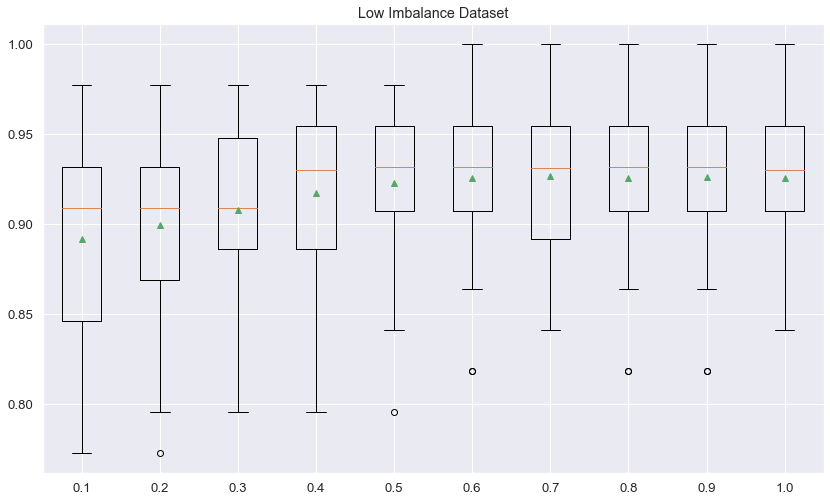

KFOLD:  2
>0.1 0.892 (0.047)
>0.2 0.904 (0.042)
>0.3 0.910 (0.040)
>0.4 0.918 (0.046)
>0.5 0.921 (0.043)
>0.6 0.918 (0.044)
>0.7 0.925 (0.041)
>0.8 0.916 (0.040)
>0.9 0.928 (0.039)
>1.0 0.922 (0.039)


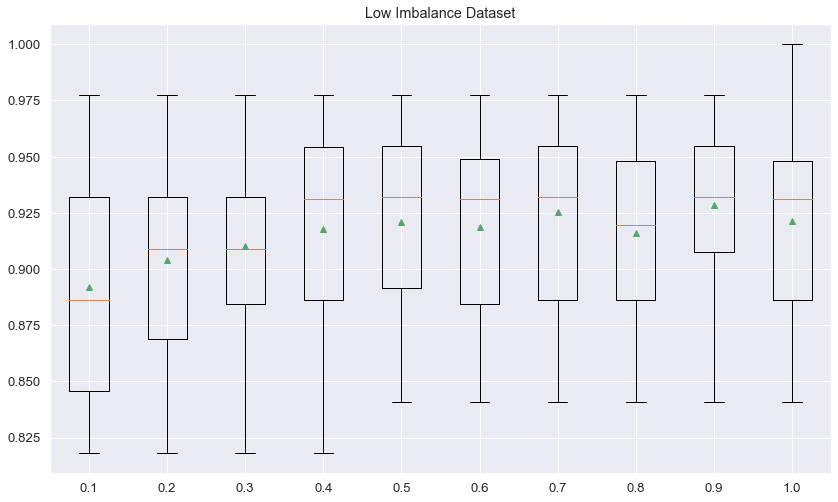

KFOLD:  3
>0.1 0.886 (0.043)
>0.2 0.893 (0.047)
>0.3 0.907 (0.043)
>0.4 0.915 (0.040)
>0.5 0.918 (0.045)
>0.6 0.920 (0.042)
>0.7 0.915 (0.043)
>0.8 0.918 (0.037)
>0.9 0.922 (0.044)
>1.0 0.918 (0.034)


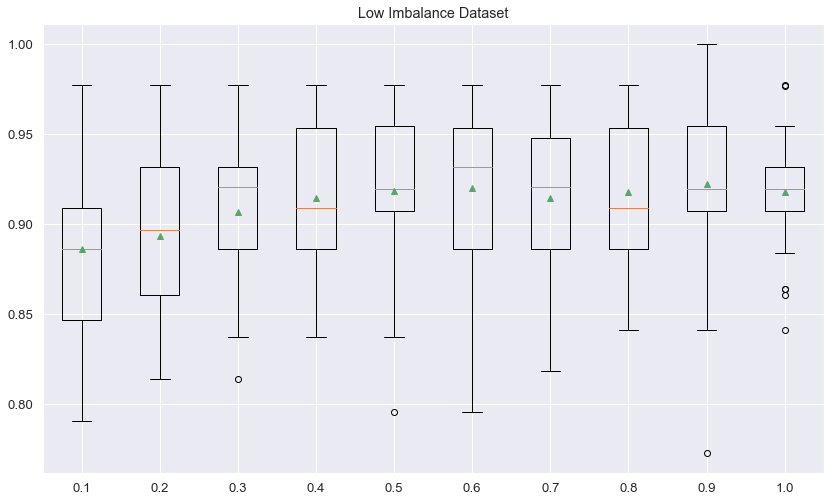

KFOLD:  4
>0.1 0.876 (0.036)
>0.2 0.894 (0.041)
>0.3 0.905 (0.040)
>0.4 0.912 (0.041)
>0.5 0.921 (0.037)
>0.6 0.925 (0.034)
>0.7 0.922 (0.035)
>0.8 0.923 (0.038)
>0.9 0.921 (0.040)
>1.0 0.925 (0.038)


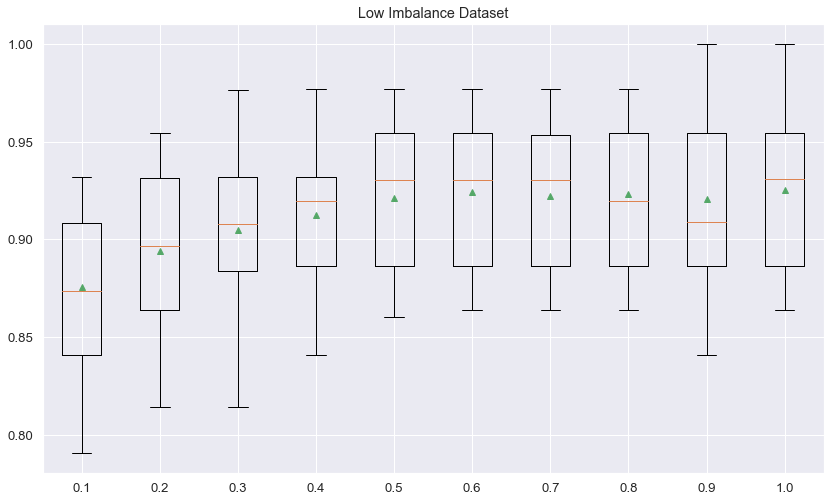

KFOLD:  5
>0.1 0.896 (0.037)
>0.2 0.908 (0.033)
>0.3 0.912 (0.035)
>0.4 0.922 (0.038)
>0.5 0.921 (0.037)
>0.6 0.928 (0.035)
>0.7 0.927 (0.034)
>0.8 0.925 (0.034)
>0.9 0.924 (0.033)
>1.0 0.927 (0.033)


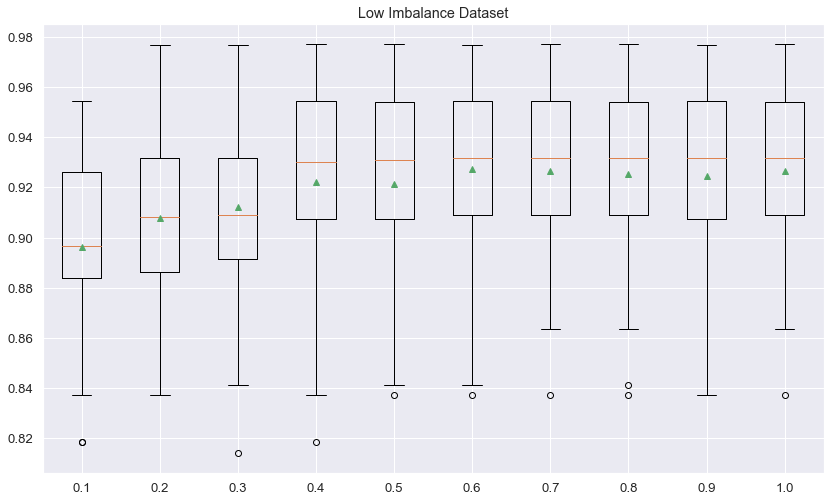

KFOLD:  6
>0.1 0.893 (0.040)
>0.2 0.897 (0.038)
>0.3 0.902 (0.043)
>0.4 0.909 (0.041)
>0.5 0.915 (0.042)
>0.6 0.918 (0.040)
>0.7 0.919 (0.039)
>0.8 0.919 (0.043)
>0.9 0.922 (0.045)
>1.0 0.922 (0.045)


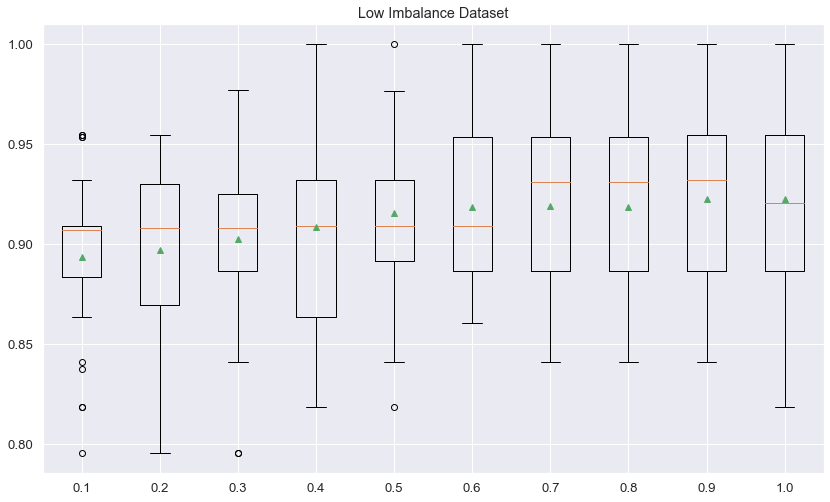

KFOLD:  7
>0.1 0.890 (0.040)
>0.2 0.897 (0.034)
>0.3 0.907 (0.044)
>0.4 0.912 (0.037)
>0.5 0.912 (0.034)
>0.6 0.921 (0.040)
>0.7 0.918 (0.038)
>0.8 0.912 (0.036)
>0.9 0.915 (0.035)
>1.0 0.913 (0.038)


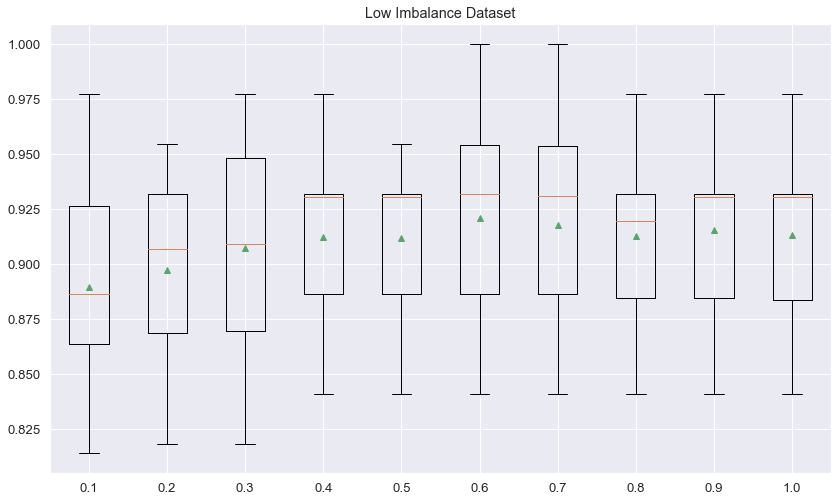

KFOLD:  8
>0.1 0.881 (0.041)
>0.2 0.891 (0.037)
>0.3 0.906 (0.042)
>0.4 0.918 (0.037)
>0.5 0.917 (0.039)
>0.6 0.915 (0.041)
>0.7 0.919 (0.038)
>0.8 0.917 (0.040)
>0.9 0.919 (0.036)
>1.0 0.916 (0.040)


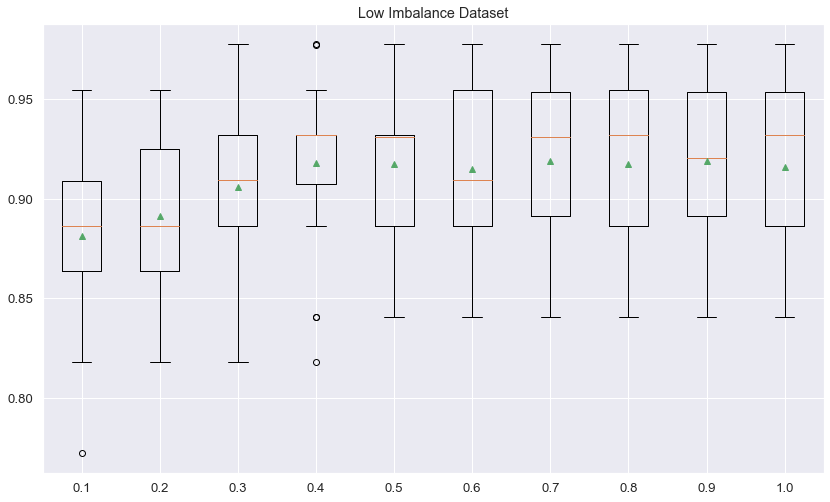

KFOLD:  9
>0.1 0.883 (0.050)
>0.2 0.897 (0.041)
>0.3 0.896 (0.045)
>0.4 0.912 (0.039)
>0.5 0.909 (0.039)
>0.6 0.915 (0.042)
>0.7 0.914 (0.042)
>0.8 0.919 (0.037)
>0.9 0.913 (0.037)
>1.0 0.919 (0.041)


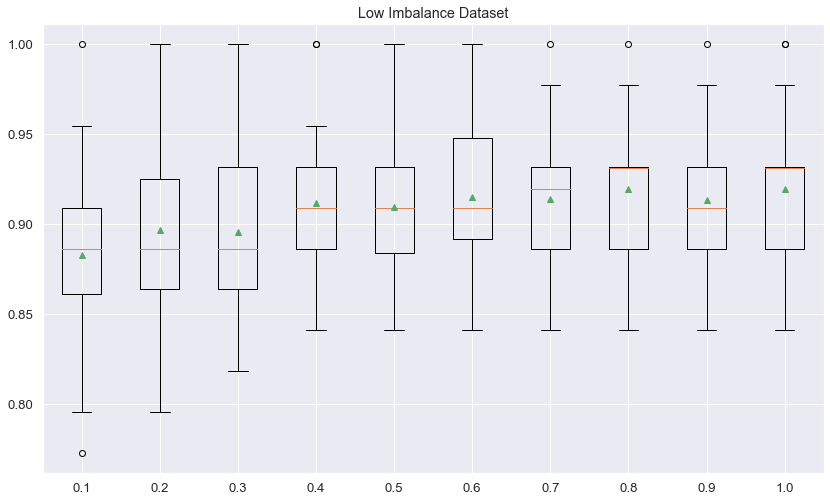

KFOLD:  10


In [143]:
X_train, X_test, y_train, y_test = get_dataset_low()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Low Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        
        models_low = get_models()
        # evaluate the models and store results
        results, names = list(), list()
        for name, model in models_low.items():
            # evaluate the model
            scores = evaluate_model(model, X_train_low, y_train_low)
            # store the results
            results.append(scores)
            names.append(name)
            # summarize the performance along the way
            print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
        # plot model performance for comparison
        plt.boxplot(results, labels=names, showmeans=True)
        plt.title("Low Imbalance Dataset")
        plt.show()

Medium Imbalance Dataset
KFOLD:  1
>0.1 0.900 (0.037)
>0.2 0.899 (0.040)
>0.3 0.912 (0.035)
>0.4 0.915 (0.043)
>0.5 0.925 (0.032)
>0.6 0.922 (0.029)
>0.7 0.927 (0.031)
>0.8 0.929 (0.033)
>0.9 0.930 (0.032)
>1.0 0.924 (0.037)


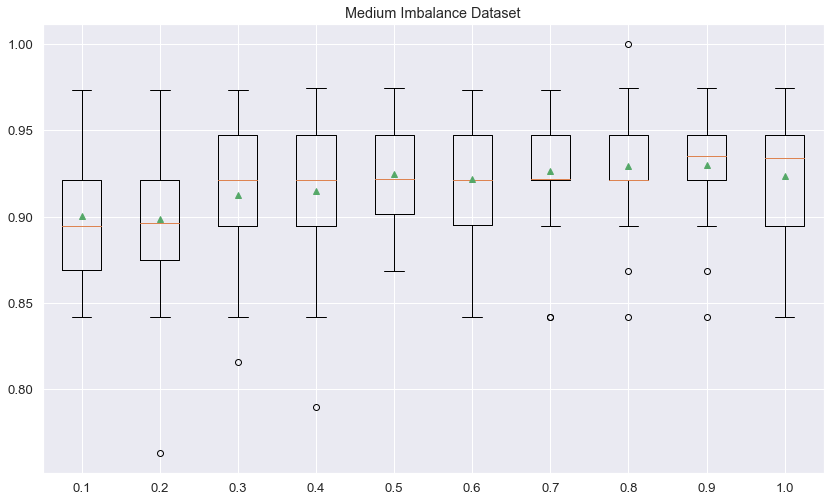

KFOLD:  2
>0.1 0.897 (0.045)
>0.2 0.907 (0.045)
>0.3 0.911 (0.040)
>0.4 0.916 (0.045)
>0.5 0.924 (0.045)
>0.6 0.927 (0.039)
>0.7 0.932 (0.039)
>0.8 0.934 (0.040)
>0.9 0.934 (0.034)
>1.0 0.937 (0.040)


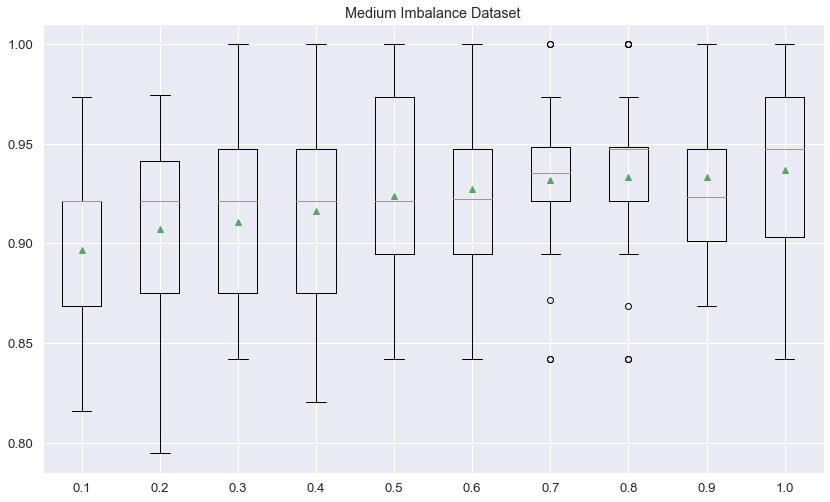

KFOLD:  3
>0.1 0.899 (0.039)
>0.2 0.899 (0.036)
>0.3 0.913 (0.038)
>0.4 0.913 (0.039)
>0.5 0.924 (0.039)
>0.6 0.925 (0.037)
>0.7 0.925 (0.040)
>0.8 0.925 (0.039)
>0.9 0.923 (0.037)
>1.0 0.923 (0.042)


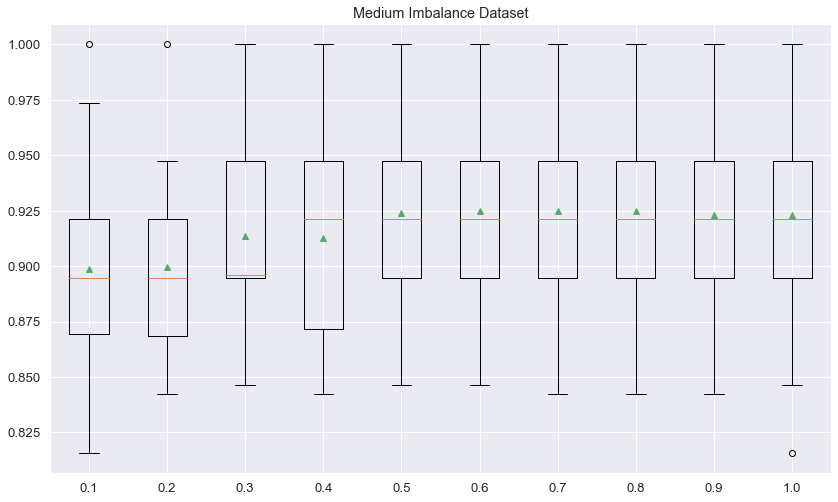

KFOLD:  4
>0.1 0.891 (0.037)
>0.2 0.903 (0.039)
>0.3 0.921 (0.037)
>0.4 0.926 (0.036)
>0.5 0.927 (0.031)
>0.6 0.936 (0.040)
>0.7 0.931 (0.039)
>0.8 0.934 (0.036)
>0.9 0.935 (0.039)
>1.0 0.940 (0.032)


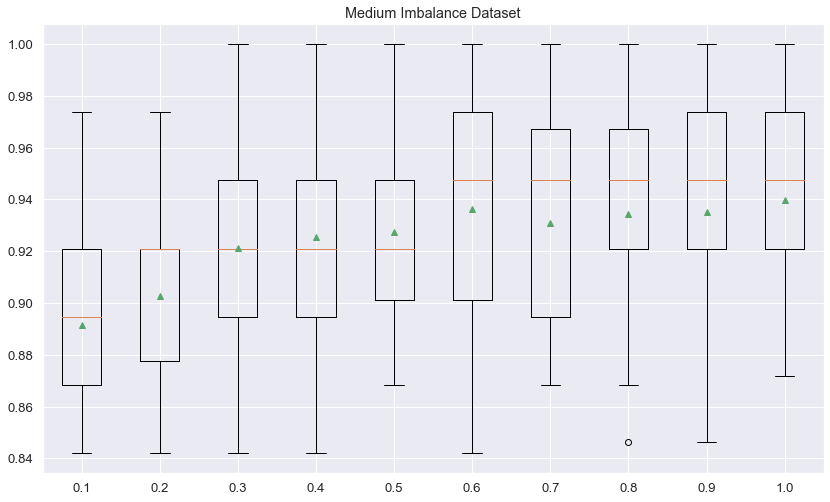

KFOLD:  5
>0.1 0.889 (0.036)
>0.2 0.897 (0.041)
>0.3 0.901 (0.041)
>0.4 0.911 (0.042)
>0.5 0.912 (0.041)
>0.6 0.919 (0.038)
>0.7 0.917 (0.043)
>0.8 0.914 (0.040)
>0.9 0.920 (0.042)
>1.0 0.920 (0.042)


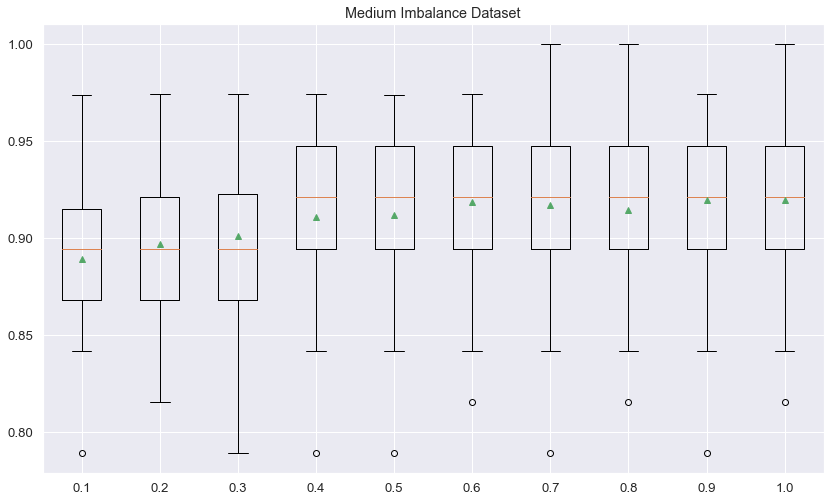

KFOLD:  6
>0.1 0.901 (0.039)
>0.2 0.907 (0.036)
>0.3 0.906 (0.036)
>0.4 0.922 (0.036)
>0.5 0.922 (0.040)
>0.6 0.929 (0.035)
>0.7 0.928 (0.036)
>0.8 0.937 (0.033)
>0.9 0.937 (0.031)
>1.0 0.931 (0.038)


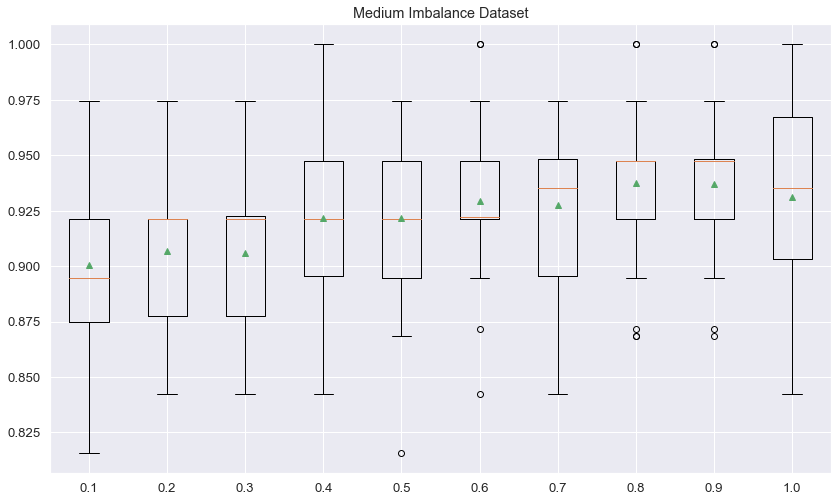

KFOLD:  7
>0.1 0.897 (0.045)
>0.2 0.899 (0.046)
>0.3 0.912 (0.049)
>0.4 0.916 (0.048)
>0.5 0.925 (0.042)
>0.6 0.936 (0.040)
>0.7 0.935 (0.047)
>0.8 0.942 (0.041)
>0.9 0.933 (0.048)
>1.0 0.937 (0.040)


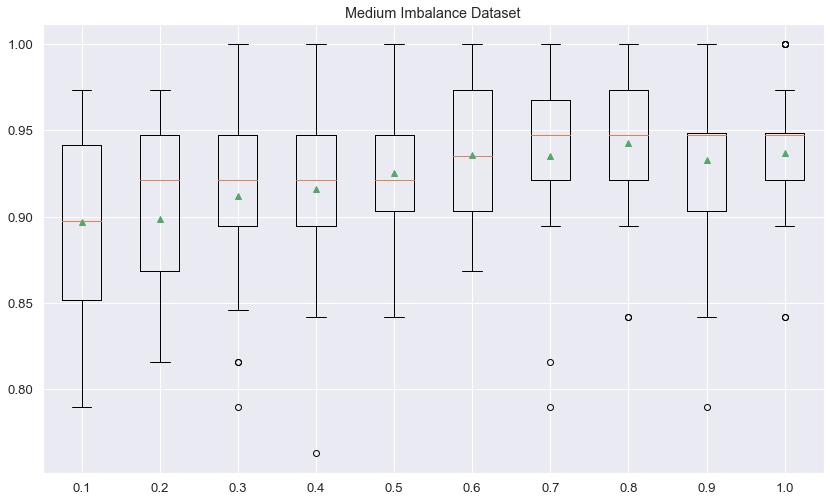

KFOLD:  8
>0.1 0.895 (0.039)
>0.2 0.904 (0.039)
>0.3 0.906 (0.039)
>0.4 0.915 (0.039)
>0.5 0.927 (0.034)
>0.6 0.930 (0.031)
>0.7 0.935 (0.036)
>0.8 0.936 (0.035)
>0.9 0.934 (0.034)
>1.0 0.931 (0.034)


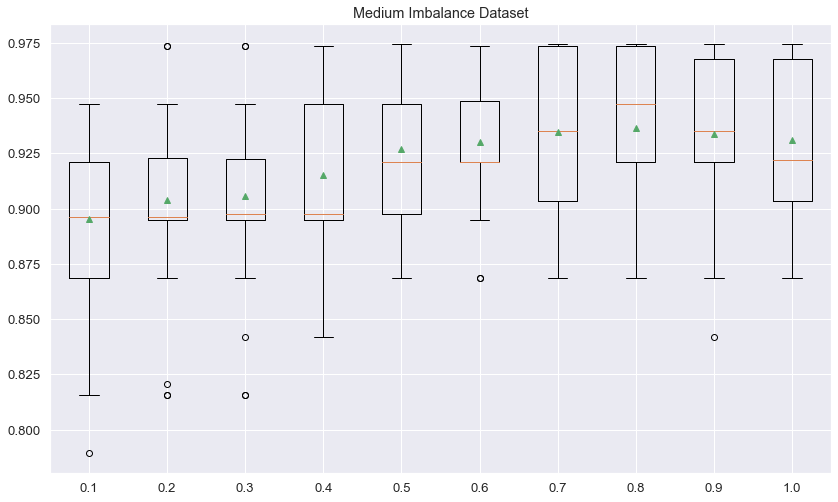

KFOLD:  9
>0.1 0.889 (0.050)
>0.2 0.901 (0.048)
>0.3 0.909 (0.044)
>0.4 0.913 (0.052)
>0.5 0.924 (0.037)
>0.6 0.926 (0.039)
>0.7 0.930 (0.034)
>0.8 0.933 (0.038)
>0.9 0.933 (0.041)
>1.0 0.924 (0.038)


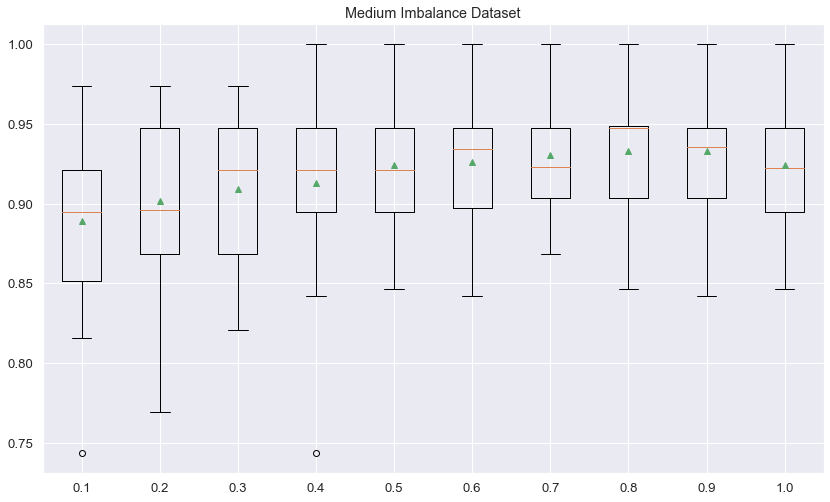

KFOLD:  10


In [144]:
X_train, X_test, y_train, y_test = get_dataset_medium()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("Medium Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        
        models_medium = get_models()
        # evaluate the models and store results
        results, names = list(), list()
        for name, model in models_medium.items():
            # evaluate the model
            scores = evaluate_model(model, X_train_low, y_train_low)
            # store the results
            results.append(scores)
            names.append(name)
            # summarize the performance along the way
            print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
        # plot model performance for comparison
        plt.boxplot(results, labels=names, showmeans=True)
        plt.title("Medium Imbalance Dataset")
        plt.show()

High Imbalance Dataset
KFOLD:  1
>0.1 0.931 (0.027)
>0.2 0.943 (0.031)
>0.3 0.947 (0.025)
>0.4 0.945 (0.033)
>0.5 0.947 (0.026)
>0.6 0.949 (0.034)
>0.7 0.950 (0.032)
>0.8 0.953 (0.029)
>0.9 0.951 (0.032)
>1.0 0.951 (0.031)


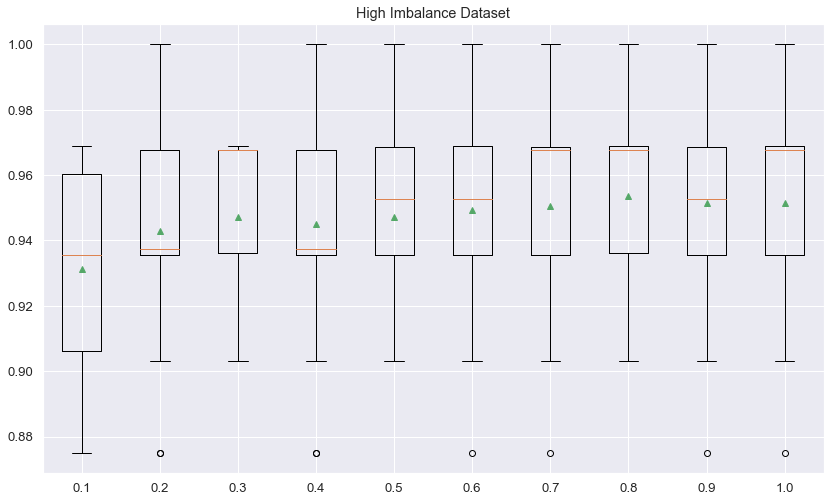

KFOLD:  2
>0.1 0.926 (0.025)
>0.2 0.944 (0.032)
>0.3 0.943 (0.030)
>0.4 0.948 (0.029)
>0.5 0.951 (0.029)
>0.6 0.949 (0.027)
>0.7 0.950 (0.037)
>0.8 0.947 (0.032)
>0.9 0.948 (0.034)
>1.0 0.948 (0.038)


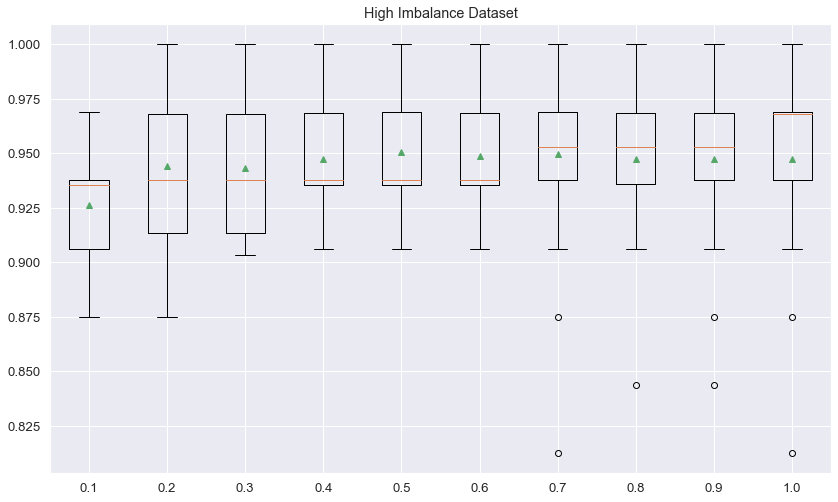

KFOLD:  3
>0.1 0.933 (0.028)
>0.2 0.944 (0.033)
>0.3 0.955 (0.026)
>0.4 0.954 (0.029)
>0.5 0.957 (0.024)
>0.6 0.957 (0.025)
>0.7 0.963 (0.022)
>0.8 0.959 (0.022)
>0.9 0.962 (0.022)
>1.0 0.959 (0.022)


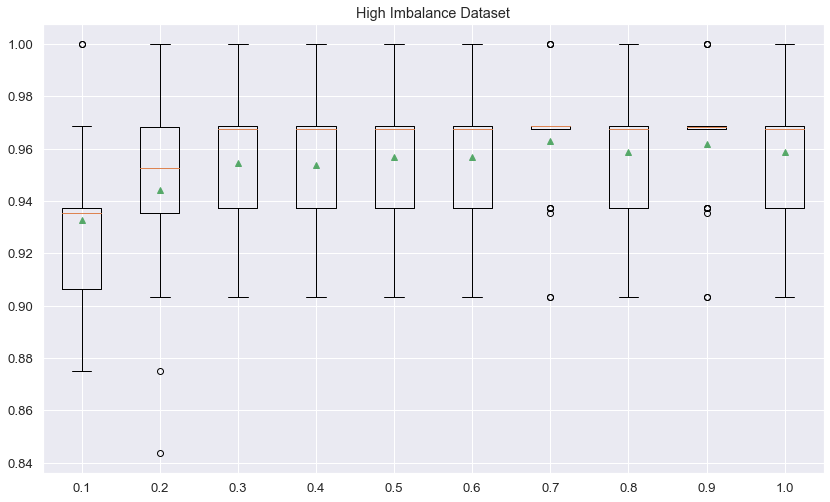

KFOLD:  4
>0.1 0.921 (0.023)
>0.2 0.938 (0.025)
>0.3 0.941 (0.033)
>0.4 0.939 (0.034)
>0.5 0.941 (0.038)
>0.6 0.943 (0.036)
>0.7 0.943 (0.040)
>0.8 0.942 (0.038)
>0.9 0.942 (0.040)
>1.0 0.942 (0.040)


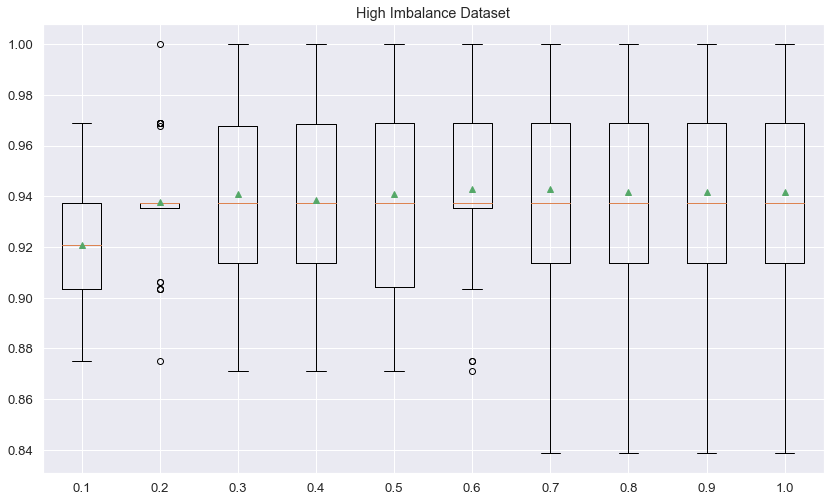

KFOLD:  5
>0.1 0.931 (0.024)
>0.2 0.947 (0.031)
>0.3 0.947 (0.027)
>0.4 0.949 (0.025)
>0.5 0.958 (0.026)
>0.6 0.956 (0.026)
>0.7 0.958 (0.025)
>0.8 0.958 (0.029)
>0.9 0.956 (0.024)
>1.0 0.959 (0.026)


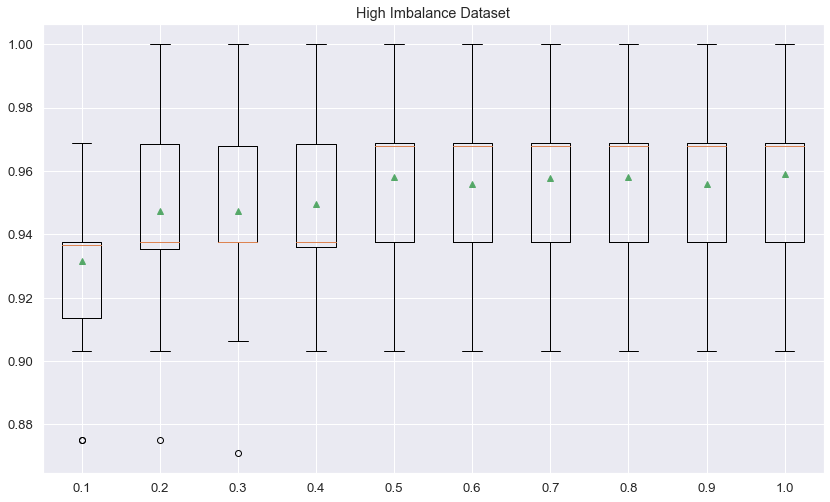

KFOLD:  6
>0.1 0.930 (0.026)
>0.2 0.935 (0.036)
>0.3 0.942 (0.034)
>0.4 0.943 (0.039)
>0.5 0.940 (0.038)
>0.6 0.948 (0.037)
>0.7 0.950 (0.035)
>0.8 0.951 (0.036)
>0.9 0.949 (0.035)
>1.0 0.954 (0.033)


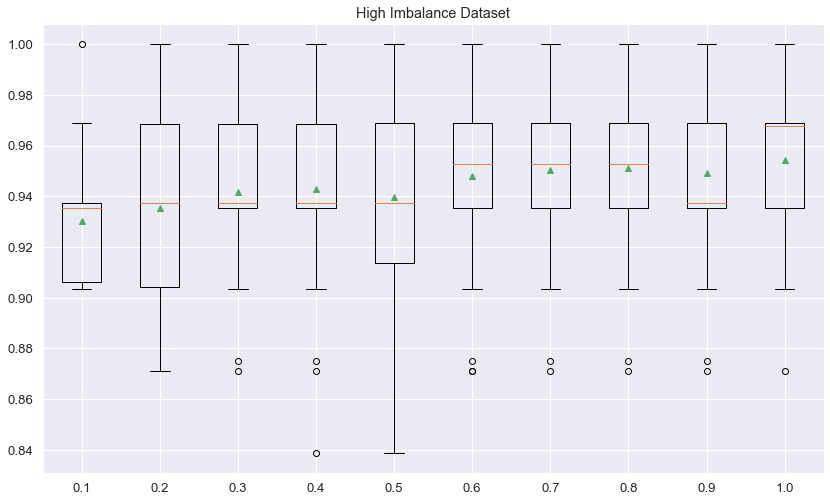

KFOLD:  7
>0.1 0.930 (0.030)
>0.2 0.949 (0.029)
>0.3 0.950 (0.030)
>0.4 0.953 (0.029)
>0.5 0.953 (0.039)
>0.6 0.951 (0.032)
>0.7 0.950 (0.036)
>0.8 0.953 (0.037)
>0.9 0.954 (0.038)
>1.0 0.952 (0.037)


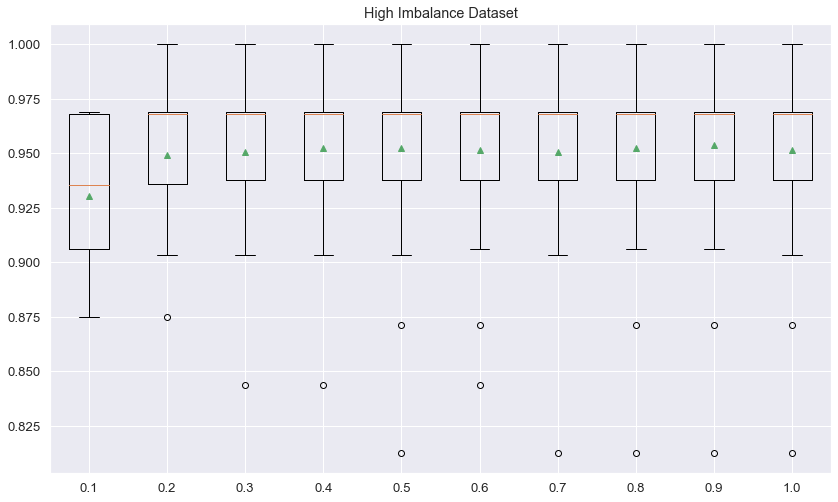

KFOLD:  8
>0.1 0.923 (0.022)
>0.2 0.939 (0.028)
>0.3 0.940 (0.037)
>0.4 0.951 (0.032)
>0.5 0.950 (0.033)
>0.6 0.951 (0.032)
>0.7 0.950 (0.031)
>0.8 0.953 (0.034)
>0.9 0.952 (0.032)
>1.0 0.953 (0.032)


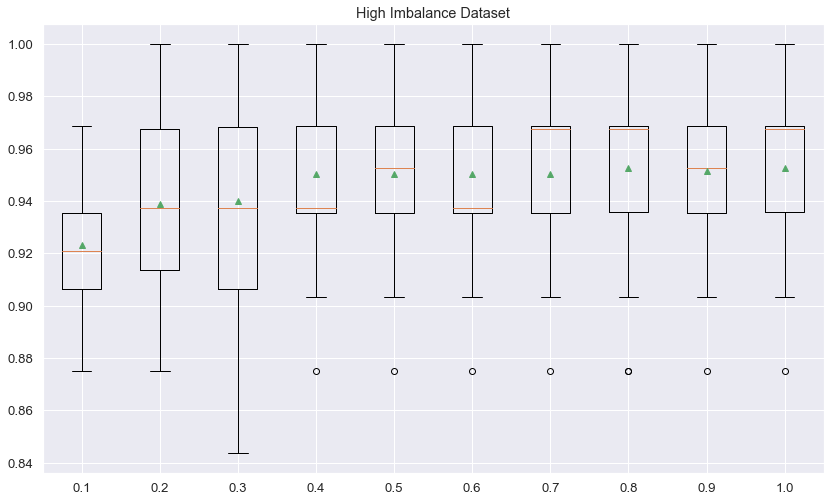

KFOLD:  9
>0.1 0.926 (0.028)
>0.2 0.939 (0.032)


KeyboardInterrupt: 

In [145]:
X_train, X_test, y_train, y_test = get_dataset_high()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
print("High Imbalance Dataset")
j=0
for train_index, test_index in cv.split(X_train, y_train):
    j+=1
    print("KFOLD: ",j)
    if j == 10:
        X_train_low10, X_test_low10 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low10, y_test_low10 = y_train.iloc[train_index], y_train.iloc[test_index]
    else:
        
        X_train_low, X_test_low = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_low, y_test_low = y_train.iloc[train_index], y_train.iloc[test_index]  
        
        models_high = get_models()
        # evaluate the models and store results
        results, names = list(), list()
        for name, model in models_high.items():
            # evaluate the model
            scores = evaluate_model(model, X_train_low, y_train_low)
            # store the results
            results.append(scores)
            names.append(name)
            # summarize the performance along the way
            print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
        # plot model performance for comparison
        plt.boxplot(results, labels=names, showmeans=True)
        plt.title("High Imbalance Dataset")
        plt.show()

### Use unseen fold - 10th Fold <a class="anchor" id="4.4"></a>
    E. Given a sample xi from the unseen fold (the one left out in (3))
        a. Assign xi to its closest cluster.
        b. this cluster has only instances of one class, assign to xi that label. Otherwise, use the model trained with data from that cluster to assign a label to xi
[Task 04](#4)

#### 10th Fold from the Low Imbalance Dataset

Ideal: 0.474
> folds=2, accuracy=0.696 (0.681,0.712)
> folds=3, accuracy=0.589 (0.339,0.717)
> folds=4, accuracy=0.396 (0.260,0.684)
> folds=5, accuracy=0.430 (0.263,0.684)
> folds=6, accuracy=0.512 (0.281,0.734)
> folds=7, accuracy=0.501 (0.236,0.685)
> folds=8, accuracy=0.470 (0.229,0.771)
> folds=9, accuracy=0.562 (0.310,0.791)
> folds=10, accuracy=0.541 (0.282,0.789)


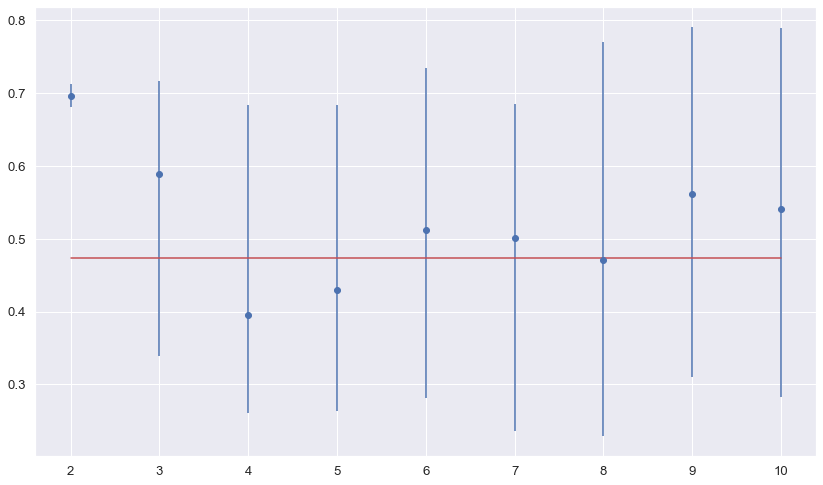

In [146]:
# evaluate the model using a given test condition
def evaluate_model(cv):
    # get the model
    model = KMeans(n_clusters=2)
    # evaluate the model
    scores = cross_val_score(model, X_train_low10, y_train_low10, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return np.mean(scores), scores.min(), scores.max()

# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,11)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    k_mean, k_min, k_max = evaluate_model(cv)
    # report performance
    print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.show()

#### 10th Fold from the Medium Imbalance Dataset

Ideal: 0.518
> folds=2, accuracy=0.516 (0.319,0.712)
> folds=3, accuracy=0.417 (0.289,0.669)
> folds=4, accuracy=0.573 (0.253,0.760)
> folds=5, accuracy=0.696 (0.584,0.792)
> folds=6, accuracy=0.401 (0.203,0.667)
> folds=7, accuracy=0.362 (0.200,0.704)
> folds=8, accuracy=0.448 (0.208,0.812)
> folds=9, accuracy=0.378 (0.163,0.690)
> folds=10, accuracy=0.527 (0.154,0.763)


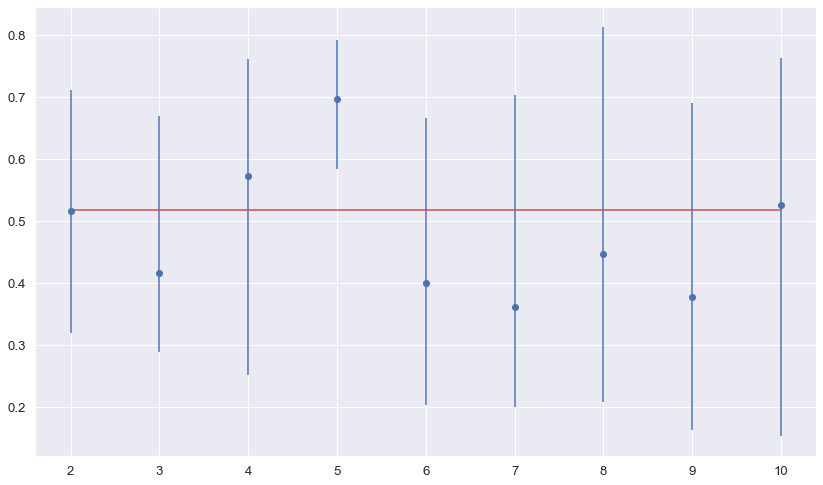

In [147]:
# evaluate the model using a given test condition
def evaluate_model(cv):
    # get the model
    model = KMeans(n_clusters=2)
    # evaluate the model
    scores = cross_val_score(model, X_train_medium10, y_train_medium10, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return np.mean(scores), scores.min(), scores.max()

# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,11)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    k_mean, k_min, k_max = evaluate_model(cv)
    # report performance
    print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.show()

#### 10th Fold from the High Imbalance Dataset

Ideal: 0.500
> folds=2, accuracy=0.693 (0.652,0.734)
> folds=3, accuracy=0.557 (0.295,0.698)
> folds=4, accuracy=0.579 (0.329,0.797)
> folds=5, accuracy=0.455 (0.286,0.703)
> folds=6, accuracy=0.497 (0.189,0.717)
> folds=7, accuracy=0.566 (0.244,0.800)
> folds=8, accuracy=0.492 (0.175,0.769)
> folds=9, accuracy=0.585 (0.229,0.743)
> folds=10, accuracy=0.478 (0.156,0.781)


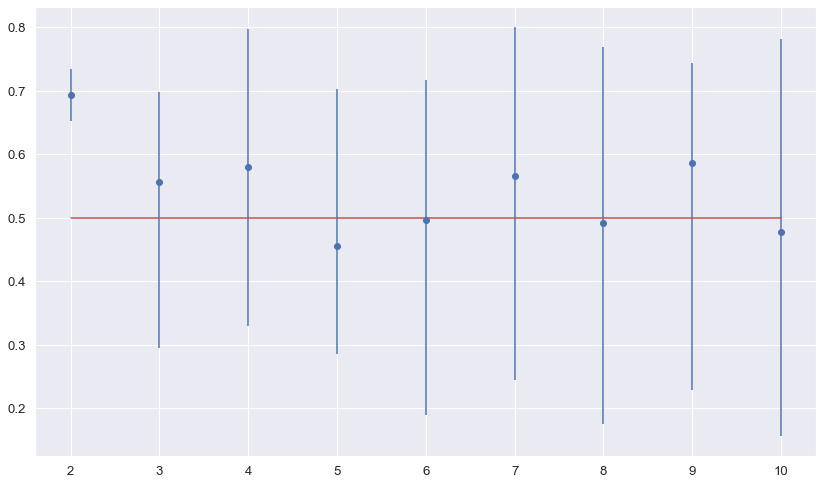

In [148]:
# evaluate the model using a given test condition
def evaluate_model(cv):
    # get the model
    model = KMeans(n_clusters=2)
    # evaluate the model
    scores = cross_val_score(model, X_train_high10, y_train_high10, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return np.mean(scores), scores.min(), scores.max()

# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,11)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    k_mean, k_min, k_max = evaluate_model(cv)
    # report performance
    print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.show()

### Task 05 <a class="anchor" id="5"></a>
[Table of Contents](#0)

5. Do the above for each permutation of 10 bins (like in cross-validation), and present the average and standard deviation of results for each of the datasets and their surrogates using appropriate metric/s.

In [151]:
model = KMeans(n_clusters=2)
cv = StratifiedKFold(10, shuffle=True, random_state=0)

score_Fold_low10, perm_scores_Fold_low10, pvalue_Fold_low10 = permutation_test_score(
    model, X_train_low10, y_train_low10, scoring="accuracy", cv=cv, n_permutations=100
)

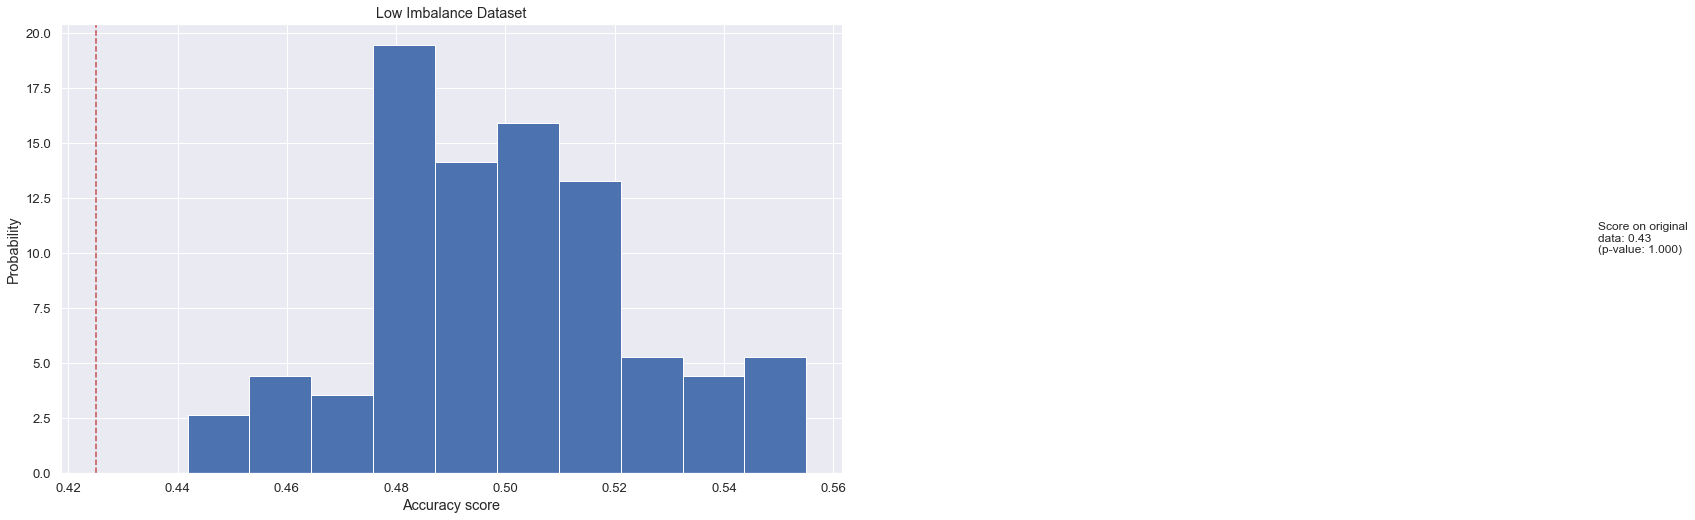

In [258]:
fig, ax = plt.subplots()

ax.hist(perm_scores_Fold_low10, bins=10, density=True)
ax.axvline(score_Fold_low10, ls="--", color="r")
score_label = f"Score on original\ndata: {score_Fold_low10:.2f}\n(p-value: {pvalue_Fold_low10:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_title("Low Imbalance Dataset")
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")
plt.savefig('fig10_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_low.pdf')
plt.savefig('fig10_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_low.png')

In [154]:
model = KMeans(n_clusters=2)
cv = StratifiedKFold(10, shuffle=True, random_state=0)

score_Fold_medium10, perm_scores_Fold_medium10, pvalue_Fold_medium10 = permutation_test_score(
    model, X_train_medium10, y_train_medium10, scoring="accuracy", cv=cv, n_permutations=100
)

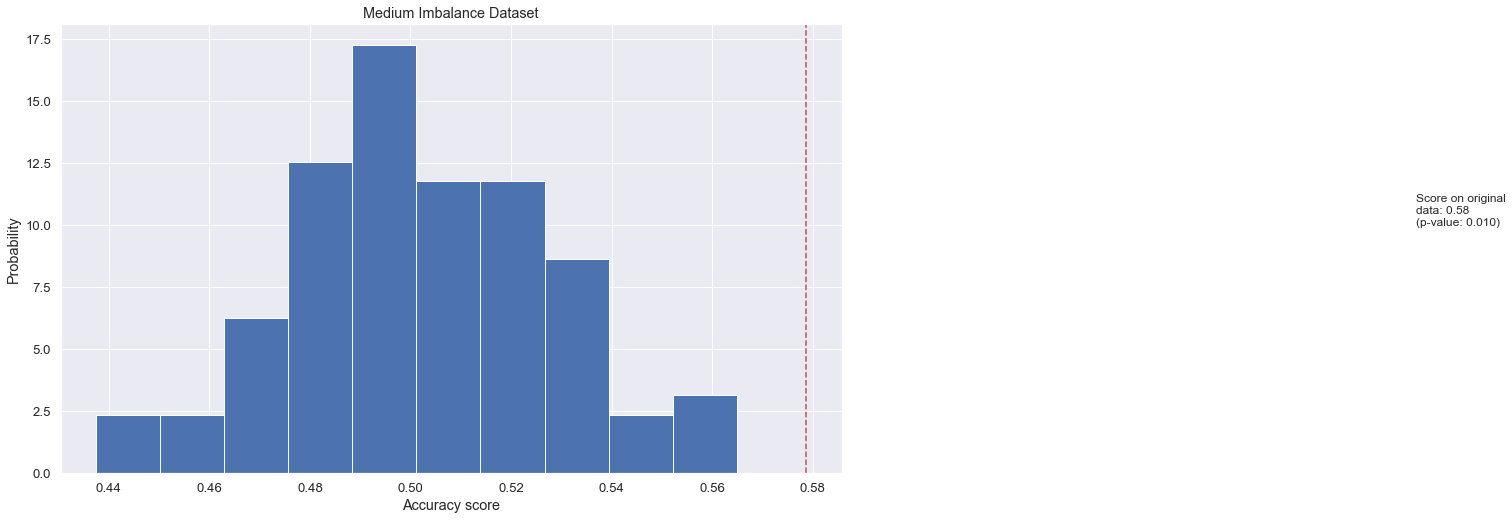

In [327]:
fig, ax = plt.subplots()

ax.hist(perm_scores_Fold_medium10, bins=10, density=True)
ax.axvline(score_Fold_medium10, ls="--", color="r")
score_label = f"Score on original\ndata: {score_Fold_medium10:.2f}\n(p-value: {pvalue_Fold_medium10:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_title("Medium Imbalance Dataset")
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

plt.savefig('fig11_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_medium.pdf')
plt.savefig('fig11_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_medium.png')

In [271]:
model = KMeans(n_clusters=2)
cv = StratifiedKFold(10, shuffle=True, random_state=0)

score_Fold_high10, perm_scores_Fold_high10, pvalue_Fold_high10 = permutation_test_score(
    model, X_train_high10, y_train_high10, scoring="accuracy", cv=cv, n_permutations=100
)

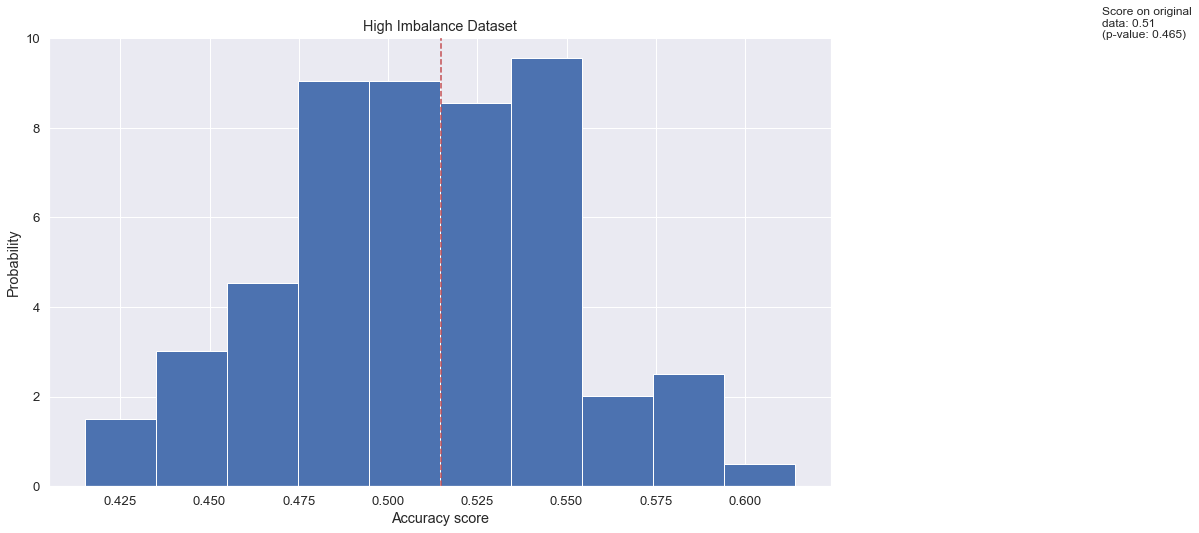

In [272]:
fig, ax = plt.subplots()

ax.hist(perm_scores_Fold_high10, bins=10, density=True)
ax.axvline(score_Fold_high10, ls="--", color="r")
score_label = f"Score on original\ndata: {score_Fold_high10:.2f}\n(p-value: {pvalue_Fold_high10:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_title("High Imbalance Dataset")
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

plt.savefig('fig12_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_high.pdf')
plt.savefig('fig12_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_high.png')

### Task 06 <a class="anchor" id="6"></a>
[Table of Contents](#0)

6. Compare your results with the baseline results from (2). A boxplot of the cross-validation results for each method should help you decide which method is best under which conditions. Are the results significantly better with the new method (e.g., as determined by a permutation test)? How does the data imbalance affect the results?

KMeans: 0.635332 (0.322036)
RF: 0.934099 (0.034148)


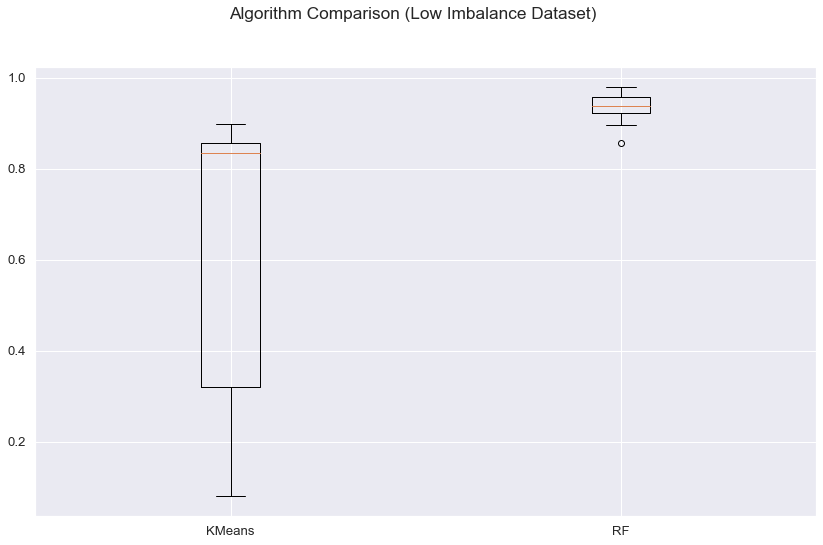

In [273]:
# Compare Algorithms
# load dataset
X_train, X_test, y_train, y_test = get_dataset_low()

# prepare models
models = []
models.append(('KMeans', KMeans(n_clusters=2)))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
#     kfold = model_selection.KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    cv_results =cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison (Low Imbalance Dataset)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('heart_disease_final_comparison_graph_low.pdf')
plt.savefig('fig19_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_low.pdf')
plt.savefig('fig19_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_low.png')
plt.show()


KMeans: 0.518715 (0.223142)
RF: 0.917553 (0.058159)


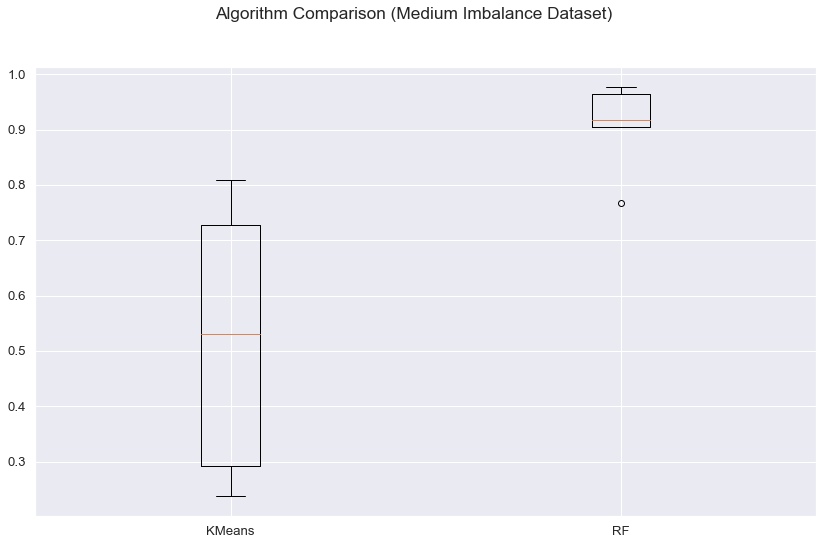

In [269]:
# Compare Algorithms
# load dataset
X_train, X_test, y_train, y_test = get_dataset_medium()

# prepare models
models = []
models.append(('KMeans', KMeans(n_clusters=2)))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
#     kfold = model_selection.KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison (Medium Imbalance Dataset)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
# plt.savefig('heart_disease_final_comparison_graph_medium.pdf')
plt.savefig('fig20_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_medium.pdf')
plt.savefig('fig20_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_medium.png')
plt.show()

KMeans: 0.529603 (0.220416)
RF: 0.943016 (0.046073)


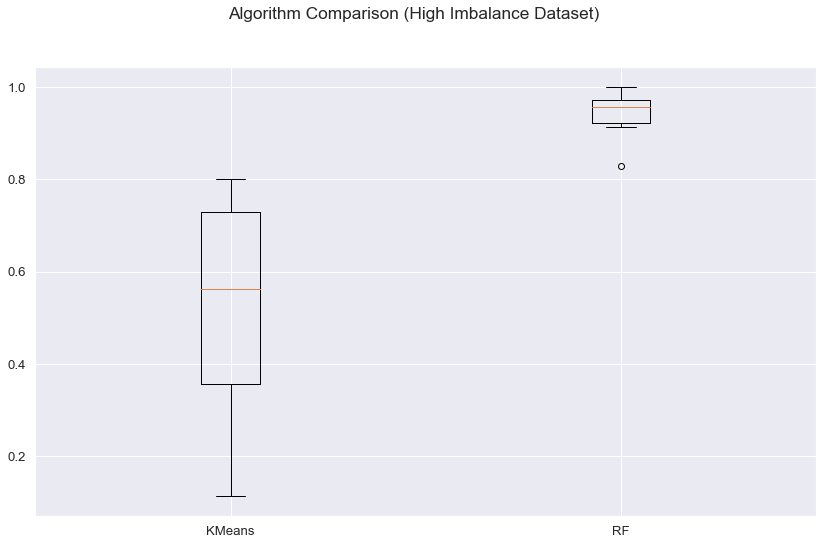

In [268]:
# Compare Algorithms
# load dataset
X_train, X_test, y_train, y_test = get_dataset_high()

# prepare models
models = []
models.append(('KMeans', KMeans(n_clusters=2)))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
#     kfold = model_selection.KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison (High Imbalance Dataset)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
# plt.savefig('heart_disease_final_comparison_graph_high.pdf')

plt.savefig('fig21_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_high.pdf')
plt.savefig('fig21_heart_disease_accuracy_metrics_bar_graphs_Curve_kmeans_high.png')
plt.show()

[Move to Top](#0.1)